# **1. Global Constants**

In [1]:
import itertools
import keras
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image


In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [3]:
load_model = keras.models.load_model('ghostfacenet_v1.h5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# **2. Dataset**

In [4]:
def get_folders(dataset_path):
    """
    List all the directories (person folders) inside the main dataset directory.
    """
    return [os.path.join(dataset_path, folder) for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

def get_images(folder_path):
    """
    Randomly pick and list 5 image files within a specified folder, using a fixed random seed for reproducibility.
    """
    # Pick 5 images at random from the list of all images
    all_images = [file for file in os.listdir(folder_path) if file.endswith('.png')]
    # If there are less than 5 images, it returns all of them
    return random.sample(all_images, min(5, len(all_images)))
    #return [file for file in os.listdir(folder_path) if file.endswith('.png')]

def generate_pairs(dataset_path):
    """
    Generate positive and negative pairs of images and return them as a pandas DataFrame.
    """
    person_folders = get_folders(dataset_path)
    positive_pairs = []
    negative_pairs = []

    # Generate positive pairs
    for folder in person_folders:
        images = get_images(folder)
        for pair in itertools.combinations(images, 2):
            positive_pairs.append((os.path.join(folder, pair[0]), os.path.join(folder, pair[1]), True))
    
    # Generate negative pairs
    all_images = [(folder, image) for folder in person_folders for image in get_images(folder)]
    for _ in range(len(positive_pairs)):  # Assuming we want an equal number of negative pairs
        pair = random.sample(all_images, 2)
        while pair[0][0] == pair[1][0]:  # Ensure pairs are from different folders
            pair = random.sample(all_images, 2)
        negative_pairs.append((os.path.join(pair[0][0], pair[0][1]), os.path.join(pair[1][0], pair[1][1]), False))
    
    # Combine, shuffle, and create a DataFrame
    dataset = positive_pairs + negative_pairs
    random.shuffle(dataset)
    df = pd.DataFrame(dataset, columns=['Image1', 'Image2', 'IsSame'])

    return df

In [5]:
dataset_path = 'dataset'
df_pairs = generate_pairs(dataset_path)
print(df_pairs.head()) 

                Image1               Image2  IsSame
0  dataset/1415/36.png  dataset/1415/22.png    True
1   dataset/309/71.png   dataset/309/34.png    True
2   dataset/310/17.png   dataset/310/39.png    True
3   dataset/880/15.png    dataset/203/8.png   False
4    dataset/213/9.png   dataset/987/54.png   False


In [7]:
print(len(df_pairs))

40000


In [6]:
train_df, test_df = train_test_split(df_pairs, train_size= 0.7, shuffle= True, random_state= RANDOM_SEED)

In [8]:
print(len(test_df))

12000


In [14]:
train_df, test2_df = train_test_split(test_df, train_size= 0.9, shuffle= True, random_state= RANDOM_SEED)

In [15]:
print(len(test2_df))

1200


# **3. Evaluation**

In [9]:
def cosine_similarity(embedding1, embedding2):
    if embedding1 is None or embedding2 is None:
        return np.nan  # Return NaN if either embedding is None
    embedding1 = embedding1.flatten()
    embedding2 = embedding2.flatten()
    # Handle division by zero
    denom = (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    if denom == 0:
        return np.nan  # Return NaN if denominator is zero
    return np.dot(embedding1, embedding2) / denom

In [10]:
def get_embedding(model, image_path):
    """
    Get an image embedding using ghostfacenet_v1 model.
    
    Parameters:
    - image_path: Path to the image file.
    
    Returns:
    - embedding: The embedding vector for the image.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((112, 112))
    img_array = np.array(img).astype('float32')

    # Normalize pixel values to [-1, 1], assuming the model expects this range
    img_array = (img_array - 127.5) / 128.0

    img_array_expanded_dims = np.expand_dims(img_array, axis=0)

    # Get the embedding
    embedding = model.predict(img_array_expanded_dims)
    return embedding

In [16]:
def evaluate_model_with_metrics(model, df_pairs):
    scores = []
    true_labels = []

    for index, row in df_pairs.iterrows():
        image_path1 = row['Image1']
        image_path2 = row['Image2']

        if not os.path.exists(image_path1) or not os.path.exists(image_path2):
            print(f"Skipping comparison due to missing image at row {index}")
            continue

        embedding1 = get_embedding(model, image_path1)
        embedding2 = get_embedding(model, image_path2)

        similarity = cosine_similarity(embedding1, embedding2)
        print(f"Row {index}, Similarity: {similarity}")  # Debugging print

        if not np.isnan(similarity):
            scores.append(similarity)
            true_labels.append(row['IsSame'])

    if not scores:
        print("No valid scores to process.")
        return
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)

    metrics_by_threshold = {}

    for i, threshold in enumerate(thresholds):
        ga = tpr[i]
        gr = 1 - fpr[i]
        far = fpr[i]
        frr = 1 - tpr[i]

        metrics_by_threshold[threshold] = {
            'FAR': far,
            'FRR': frr,
            'GA (Genuine Acceptance Rate)': ga,
            'GR (Genuine Rejection Rate)': gr,
            'ROC AUC': roc_auc
        }
    return metrics_by_threshold

    # Optional: Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    #return metrics_by_threshold

1200, 29minute

1/1 [==============================] - 0s 28ms/step
Row 32823, Similarity: 0.05481868237257004
1/1 [==============================] - 0s 29ms/step
Row 16298, Similarity: 0.5272014737129211
1/1 [==============================] - 0s 31ms/step
Row 28505, Similarity: 0.07632163166999817
1/1 [==============================] - 0s 29ms/step
Row 6689, Similarity: 0.2634856700897217
1/1 [==============================] - 0s 28ms/step
Row 26893, Similarity: 0.5177733302116394
1/1 [==============================] - 0s 29ms/step
Row 36572, Similarity: 0.4055677056312561
1/1 [==============================] - 0s 29ms/step
Row 12335, Similarity: 0.02092672325670719
1/1 [==============================] - 0s 29ms/step
Row 29591, Similarity: 0.13904248178005219
1/1 [==============================] - 0s 28ms/step
Row 18948, Similarity: 0.2621268630027771
1/1 [==============================] - 0s 30ms/step
Row 31067, Similarity: 0.10292112082242966
1/1 [==============================] - 0s 29ms/step
Row 

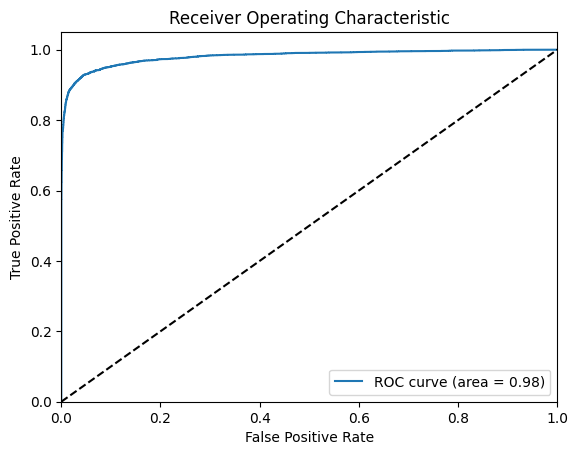

In [17]:
result = evaluate_model_with_metrics(load_model, test_df)

In [18]:
print(result)

{inf: {'FAR': 0.0, 'FRR': 1.0, 'GA (Genuine Acceptance Rate)': 0.0, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.87523055: {'FAR': 0.0, 'FRR': 0.9998356884653302, 'GA (Genuine Acceptance Rate)': 0.00016431153466973383, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.67299485: {'FAR': 0.0, 'FRR': 0.8908971409792967, 'GA (Genuine Acceptance Rate)': 0.10910285902070326, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.6728329: {'FAR': 0.0, 'FRR': 0.8905685179099573, 'GA (Genuine Acceptance Rate)': 0.10943148209004272, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.661421: {'FAR': 0.0, 'FRR': 0.8692080184028919, 'GA (Genuine Acceptance Rate)': 0.13079198159710811, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.661338: {'FAR': 0.0, 'FRR': 0.8688793953335524, 'GA (Genuine Acceptance Rate)': 0.1311206046664476, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.

In [76]:
result = {0.87523055: {'FAR': 0.0, 'FRR': 0.9998356884653302, 'GA (Genuine Acceptance Rate)': 0.00016431153466973383, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.67299485: {'FAR': 0.0, 'FRR': 0.8908971409792967, 'GA (Genuine Acceptance Rate)': 0.10910285902070326, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.6728329: {'FAR': 0.0, 'FRR': 0.8905685179099573, 'GA (Genuine Acceptance Rate)': 0.10943148209004272, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.661421: {'FAR': 0.0, 'FRR': 0.8692080184028919, 'GA (Genuine Acceptance Rate)': 0.13079198159710811, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.661338: {'FAR': 0.0, 'FRR': 0.8688793953335524, 'GA (Genuine Acceptance Rate)': 0.1311206046664476, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.54231274: {'FAR': 0.0, 'FRR': 0.596943805455143, 'GA (Genuine Acceptance Rate)': 0.403056194544857, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9809198578685776}, 0.54229814: {'FAR': 0.00016909029421711193, 'FRR': 0.596943805455143, 'GA (Genuine Acceptance Rate)': 0.403056194544857, 'GR (Genuine Rejection Rate)': 0.9998309097057829, 'ROC AUC': 0.9809198578685776}, 0.47868043: {'FAR': 0.00016909029421711193, 'FRR': 0.4245810055865922, 'GA (Genuine Acceptance Rate)': 0.5754189944134078, 'GR (Genuine Rejection Rate)': 0.9998309097057829, 'ROC AUC': 0.9809198578685776}, 0.4786638: {'FAR': 0.00033818058843422386, 'FRR': 0.4245810055865922, 'GA (Genuine Acceptance Rate)': 0.5754189944134078, 'GR (Genuine Rejection Rate)': 0.9996618194115657, 'ROC AUC': 0.9809198578685776}, 0.46022123: {'FAR': 0.00033818058843422386, 'FRR': 0.3830101873151496, 'GA (Genuine Acceptance Rate)': 0.6169898126848504, 'GR (Genuine Rejection Rate)': 0.9996618194115657, 'ROC AUC': 0.9809198578685776}, 0.46020946: {'FAR': 0.0005072708826513358, 'FRR': 0.3830101873151496, 'GA (Genuine Acceptance Rate)': 0.6169898126848504, 'GR (Genuine Rejection Rate)': 0.9994927291173487, 'ROC AUC': 0.9809198578685776}, 0.45656726: {'FAR': 0.0005072708826513358, 'FRR': 0.37479461058166286, 'GA (Genuine Acceptance Rate)': 0.6252053894183371, 'GR (Genuine Rejection Rate)': 0.9994927291173487, 'ROC AUC': 0.9809198578685776}, 0.45647293: {'FAR': 0.0006763611768684477, 'FRR': 0.37479461058166286, 'GA (Genuine Acceptance Rate)': 0.6252053894183371, 'GR (Genuine Rejection Rate)': 0.9993236388231316, 'ROC AUC': 0.9809198578685776}, 0.45241344: {'FAR': 0.0006763611768684477, 'FRR': 0.3655931646401578, 'GA (Genuine Acceptance Rate)': 0.6344068353598422, 'GR (Genuine Rejection Rate)': 0.9993236388231316, 'ROC AUC': 0.9809198578685776}, 0.45231134: {'FAR': 0.0008454514710855597, 'FRR': 0.3655931646401578, 'GA (Genuine Acceptance Rate)': 0.6344068353598422, 'GR (Genuine Rejection Rate)': 0.9991545485289144, 'ROC AUC': 0.9809198578685776}, 0.4427355: {'FAR': 0.0008454514710855597, 'FRR': 0.3412750575090371, 'GA (Genuine Acceptance Rate)': 0.6587249424909629, 'GR (Genuine Rejection Rate)': 0.9991545485289144, 'ROC AUC': 0.9809198578685776}, 0.44239387: {'FAR': 0.0010145417653026716, 'FRR': 0.3412750575090371, 'GA (Genuine Acceptance Rate)': 0.6587249424909629, 'GR (Genuine Rejection Rate)': 0.9989854582346973, 'ROC AUC': 0.9809198578685776}, 0.4328771: {'FAR': 0.0010145417653026716, 'FRR': 0.31712126191258627, 'GA (Genuine Acceptance Rate)': 0.6828787380874137, 'GR (Genuine Rejection Rate)': 0.9989854582346973, 'ROC AUC': 0.9809198578685776}, 0.43287188: {'FAR': 0.0011836320595197836, 'FRR': 0.31712126191258627, 'GA (Genuine Acceptance Rate)': 0.6828787380874137, 'GR (Genuine Rejection Rate)': 0.9988163679404802, 'ROC AUC': 0.9809198578685776}, 0.4294341: {'FAR': 0.0011836320595197836, 'FRR': 0.3093986197831088, 'GA (Genuine Acceptance Rate)': 0.6906013802168912, 'GR (Genuine Rejection Rate)': 0.9988163679404802, 'ROC AUC': 0.9809198578685776}, 0.42934456: {'FAR': 0.0013527223537368955, 'FRR': 0.3093986197831088, 'GA (Genuine Acceptance Rate)': 0.6906013802168912, 'GR (Genuine Rejection Rate)': 0.9986472776462632, 'ROC AUC': 0.9809198578685776}, 0.42135188: {'FAR': 0.0013527223537368955, 'FRR': 0.2905027932960894, 'GA (Genuine Acceptance Rate)': 0.7094972067039106, 'GR (Genuine Rejection Rate)': 0.9986472776462632, 'ROC AUC': 0.9809198578685776}, 0.42125738: {'FAR': 0.0015218126479540075, 'FRR': 0.2905027932960894, 'GA (Genuine Acceptance Rate)': 0.7094972067039106, 'GR (Genuine Rejection Rate)': 0.998478187352046, 'ROC AUC': 0.9809198578685776}, 0.42116138: {'FAR': 0.0015218126479540075, 'FRR': 0.2900098586920802, 'GA (Genuine Acceptance Rate)': 0.7099901413079198, 'GR (Genuine Rejection Rate)': 0.998478187352046, 'ROC AUC': 0.9809198578685776}, 0.42112285: {'FAR': 0.0016909029421711193, 'FRR': 0.2900098586920802, 'GA (Genuine Acceptance Rate)': 0.7099901413079198, 'GR (Genuine Rejection Rate)': 0.9983090970578289, 'ROC AUC': 0.9809198578685776}, 0.41881052: {'FAR': 0.0016909029421711193, 'FRR': 0.2850805126519882, 'GA (Genuine Acceptance Rate)': 0.7149194873480118, 'GR (Genuine Rejection Rate)': 0.9983090970578289, 'ROC AUC': 0.9809198578685776}, 0.41864517: {'FAR': 0.0018599932363882314, 'FRR': 0.2850805126519882, 'GA (Genuine Acceptance Rate)': 0.7149194873480118, 'GR (Genuine Rejection Rate)': 0.9981400067636118, 'ROC AUC': 0.9809198578685776}, 0.4102269: {'FAR': 0.0018599932363882314, 'FRR': 0.2640486362142622, 'GA (Genuine Acceptance Rate)': 0.7359513637857378, 'GR (Genuine Rejection Rate)': 0.9981400067636118, 'ROC AUC': 0.9809198578685776}, 0.4101901: {'FAR': 0.002029083530605343, 'FRR': 0.2640486362142622, 'GA (Genuine Acceptance Rate)': 0.7359513637857378, 'GR (Genuine Rejection Rate)': 0.9979709164693946, 'ROC AUC': 0.9809198578685776}, 0.40930015: {'FAR': 0.002029083530605343, 'FRR': 0.26256983240223464, 'GA (Genuine Acceptance Rate)': 0.7374301675977654, 'GR (Genuine Rejection Rate)': 0.9979709164693946, 'ROC AUC': 0.9809198578685776}, 0.4092999: {'FAR': 0.002198173824822455, 'FRR': 0.26256983240223464, 'GA (Genuine Acceptance Rate)': 0.7374301675977654, 'GR (Genuine Rejection Rate)': 0.9978018261751775, 'ROC AUC': 0.9809198578685776}, 0.4016248: {'FAR': 0.002198173824822455, 'FRR': 0.24728885967794945, 'GA (Genuine Acceptance Rate)': 0.7527111403220506, 'GR (Genuine Rejection Rate)': 0.9978018261751775, 'ROC AUC': 0.9809198578685776}, 0.40134555: {'FAR': 0.0023672641190395673, 'FRR': 0.24728885967794945, 'GA (Genuine Acceptance Rate)': 0.7527111403220506, 'GR (Genuine Rejection Rate)': 0.9976327358809605, 'ROC AUC': 0.9809198578685776}, 0.40110505: {'FAR': 0.0023672641190395673, 'FRR': 0.2461386789352612, 'GA (Genuine Acceptance Rate)': 0.7538613210647388, 'GR (Genuine Rejection Rate)': 0.9976327358809605, 'ROC AUC': 0.9809198578685776}, 0.40099356: {'FAR': 0.002536354413256679, 'FRR': 0.2461386789352612, 'GA (Genuine Acceptance Rate)': 0.7538613210647388, 'GR (Genuine Rejection Rate)': 0.9974636455867433, 'ROC AUC': 0.9809198578685776}, 0.39449796: {'FAR': 0.002536354413256679, 'FRR': 0.23135064081498524, 'GA (Genuine Acceptance Rate)': 0.7686493591850148, 'GR (Genuine Rejection Rate)': 0.9974636455867433, 'ROC AUC': 0.9809198578685776}, 0.39439234: {'FAR': 0.002705444707473791, 'FRR': 0.23135064081498524, 'GA (Genuine Acceptance Rate)': 0.7686493591850148, 'GR (Genuine Rejection Rate)': 0.9972945552925262, 'ROC AUC': 0.9809198578685776}, 0.39323235: {'FAR': 0.002705444707473791, 'FRR': 0.22937890239894843, 'GA (Genuine Acceptance Rate)': 0.7706210976010516, 'GR (Genuine Rejection Rate)': 0.9972945552925262, 'ROC AUC': 0.9809198578685776}, 0.39316803: {'FAR': 0.0028745350016909027, 'FRR': 0.22937890239894843, 'GA (Genuine Acceptance Rate)': 0.7706210976010516, 'GR (Genuine Rejection Rate)': 0.9971254649983091, 'ROC AUC': 0.9809198578685776}, 0.39287567: {'FAR': 0.0028745350016909027, 'FRR': 0.22905027932960897, 'GA (Genuine Acceptance Rate)': 0.770949720670391, 'GR (Genuine Rejection Rate)': 0.9971254649983091, 'ROC AUC': 0.9809198578685776}, 0.392695: {'FAR': 0.003043625295908015, 'FRR': 0.22905027932960897, 'GA (Genuine Acceptance Rate)': 0.770949720670391, 'GR (Genuine Rejection Rate)': 0.9969563747040919, 'ROC AUC': 0.9809198578685776}, 0.39242283: {'FAR': 0.003043625295908015, 'FRR': 0.22855734472559974, 'GA (Genuine Acceptance Rate)': 0.7714426552744003, 'GR (Genuine Rejection Rate)': 0.9969563747040919, 'ROC AUC': 0.9809198578685776}, 0.39241502: {'FAR': 0.003212715590125127, 'FRR': 0.22855734472559974, 'GA (Genuine Acceptance Rate)': 0.7714426552744003, 'GR (Genuine Rejection Rate)': 0.9967872844098749, 'ROC AUC': 0.9809198578685776}, 0.3904916: {'FAR': 0.003212715590125127, 'FRR': 0.22559973710154457, 'GA (Genuine Acceptance Rate)': 0.7744002628984554, 'GR (Genuine Rejection Rate)': 0.9967872844098749, 'ROC AUC': 0.9809198578685776}, 0.3904882: {'FAR': 0.0033818058843422386, 'FRR': 0.22559973710154457, 'GA (Genuine Acceptance Rate)': 0.7744002628984554, 'GR (Genuine Rejection Rate)': 0.9966181941156578, 'ROC AUC': 0.9809198578685776}, 0.3891369: {'FAR': 0.0033818058843422386, 'FRR': 0.22313506408149852, 'GA (Genuine Acceptance Rate)': 0.7768649359185015, 'GR (Genuine Rejection Rate)': 0.9966181941156578, 'ROC AUC': 0.9809198578685776}, 0.38906193: {'FAR': 0.0037199864727764627, 'FRR': 0.22313506408149852, 'GA (Genuine Acceptance Rate)': 0.7768649359185015, 'GR (Genuine Rejection Rate)': 0.9962800135272235, 'ROC AUC': 0.9809198578685776}, 0.383009: {'FAR': 0.0037199864727764627, 'FRR': 0.21376930660532367, 'GA (Genuine Acceptance Rate)': 0.7862306933946763, 'GR (Genuine Rejection Rate)': 0.9962800135272235, 'ROC AUC': 0.9809198578685776}, 0.38294545: {'FAR': 0.0038890767669935745, 'FRR': 0.21376930660532367, 'GA (Genuine Acceptance Rate)': 0.7862306933946763, 'GR (Genuine Rejection Rate)': 0.9961109232330064, 'ROC AUC': 0.9809198578685776}, 0.38284776: {'FAR': 0.0038890767669935745, 'FRR': 0.213604995070654, 'GA (Genuine Acceptance Rate)': 0.786395004929346, 'GR (Genuine Rejection Rate)': 0.9961109232330064, 'ROC AUC': 0.9809198578685776}, 0.38267303: {'FAR': 0.004227257355427798, 'FRR': 0.213604995070654, 'GA (Genuine Acceptance Rate)': 0.786395004929346, 'GR (Genuine Rejection Rate)': 0.9957727426445722, 'ROC AUC': 0.9809198578685776}, 0.38045776: {'FAR': 0.004227257355427798, 'FRR': 0.20933289516924092, 'GA (Genuine Acceptance Rate)': 0.7906671048307591, 'GR (Genuine Rejection Rate)': 0.9957727426445722, 'ROC AUC': 0.9809198578685776}, 0.3804485: {'FAR': 0.00439634764964491, 'FRR': 0.20933289516924092, 'GA (Genuine Acceptance Rate)': 0.7906671048307591, 'GR (Genuine Rejection Rate)': 0.9956036523503551, 'ROC AUC': 0.9809198578685776}, 0.37784514: {'FAR': 0.00439634764964491, 'FRR': 0.2045678606638186, 'GA (Genuine Acceptance Rate)': 0.7954321393361814, 'GR (Genuine Rejection Rate)': 0.9956036523503551, 'ROC AUC': 0.9809198578685776}, 0.37761658: {'FAR': 0.004565437943862023, 'FRR': 0.2045678606638186, 'GA (Genuine Acceptance Rate)': 0.7954321393361814, 'GR (Genuine Rejection Rate)': 0.995434562056138, 'ROC AUC': 0.9809198578685776}, 0.37638018: {'FAR': 0.004565437943862023, 'FRR': 0.2017745645744331, 'GA (Genuine Acceptance Rate)': 0.7982254354255669, 'GR (Genuine Rejection Rate)': 0.995434562056138, 'ROC AUC': 0.9809198578685776}, 0.37617144: {'FAR': 0.0047345282380791345, 'FRR': 0.2017745645744331, 'GA (Genuine Acceptance Rate)': 0.7982254354255669, 'GR (Genuine Rejection Rate)': 0.9952654717619208, 'ROC AUC': 0.9809198578685776}, 0.3742434: {'FAR': 0.0047345282380791345, 'FRR': 0.19815971081169903, 'GA (Genuine Acceptance Rate)': 0.801840289188301, 'GR (Genuine Rejection Rate)': 0.9952654717619208, 'ROC AUC': 0.9809198578685776}, 0.37423658: {'FAR': 0.004903618532296246, 'FRR': 0.19815971081169903, 'GA (Genuine Acceptance Rate)': 0.801840289188301, 'GR (Genuine Rejection Rate)': 0.9950963814677037, 'ROC AUC': 0.9809198578685776}, 0.37387994: {'FAR': 0.004903618532296246, 'FRR': 0.19750246467302002, 'GA (Genuine Acceptance Rate)': 0.80249753532698, 'GR (Genuine Rejection Rate)': 0.9950963814677037, 'ROC AUC': 0.9809198578685776}, 0.3736316: {'FAR': 0.005072708826513358, 'FRR': 0.19750246467302002, 'GA (Genuine Acceptance Rate)': 0.80249753532698, 'GR (Genuine Rejection Rate)': 0.9949272911734867, 'ROC AUC': 0.9809198578685776}, 0.3708444: {'FAR': 0.005072708826513358, 'FRR': 0.19323036477160693, 'GA (Genuine Acceptance Rate)': 0.8067696352283931, 'GR (Genuine Rejection Rate)': 0.9949272911734867, 'ROC AUC': 0.9809198578685776}, 0.37082836: {'FAR': 0.00524179912073047, 'FRR': 0.19323036477160693, 'GA (Genuine Acceptance Rate)': 0.8067696352283931, 'GR (Genuine Rejection Rate)': 0.9947582008792696, 'ROC AUC': 0.9809198578685776}, 0.36830014: {'FAR': 0.00524179912073047, 'FRR': 0.19043706868222154, 'GA (Genuine Acceptance Rate)': 0.8095629313177785, 'GR (Genuine Rejection Rate)': 0.9947582008792696, 'ROC AUC': 0.9809198578685776}, 0.3682983: {'FAR': 0.005410889414947582, 'FRR': 0.19043706868222154, 'GA (Genuine Acceptance Rate)': 0.8095629313177785, 'GR (Genuine Rejection Rate)': 0.9945891105850524, 'ROC AUC': 0.9809198578685776}, 0.3670236: {'FAR': 0.005410889414947582, 'FRR': 0.1879723956621755, 'GA (Genuine Acceptance Rate)': 0.8120276043378245, 'GR (Genuine Rejection Rate)': 0.9945891105850524, 'ROC AUC': 0.9809198578685776}, 0.36690688: {'FAR': 0.005579979709164694, 'FRR': 0.1879723956621755, 'GA (Genuine Acceptance Rate)': 0.8120276043378245, 'GR (Genuine Rejection Rate)': 0.9944200202908353, 'ROC AUC': 0.9809198578685776}, 0.36664987: {'FAR': 0.005579979709164694, 'FRR': 0.1873151495234966, 'GA (Genuine Acceptance Rate)': 0.8126848504765034, 'GR (Genuine Rejection Rate)': 0.9944200202908353, 'ROC AUC': 0.9809198578685776}, 0.36664042: {'FAR': 0.0057490700033818055, 'FRR': 0.1873151495234966, 'GA (Genuine Acceptance Rate)': 0.8126848504765034, 'GR (Genuine Rejection Rate)': 0.9942509299966182, 'ROC AUC': 0.9809198578685776}, 0.3664659: {'FAR': 0.0057490700033818055, 'FRR': 0.18698652645415703, 'GA (Genuine Acceptance Rate)': 0.813013473545843, 'GR (Genuine Rejection Rate)': 0.9942509299966182, 'ROC AUC': 0.9809198578685776}, 0.36645347: {'FAR': 0.005918160297598918, 'FRR': 0.18698652645415703, 'GA (Genuine Acceptance Rate)': 0.813013473545843, 'GR (Genuine Rejection Rate)': 0.994081839702401, 'ROC AUC': 0.9809198578685776}, 0.36586142: {'FAR': 0.005918160297598918, 'FRR': 0.1845218534341111, 'GA (Genuine Acceptance Rate)': 0.8154781465658889, 'GR (Genuine Rejection Rate)': 0.994081839702401, 'ROC AUC': 0.9809198578685776}, 0.3658319: {'FAR': 0.00608725059181603, 'FRR': 0.1845218534341111, 'GA (Genuine Acceptance Rate)': 0.8154781465658889, 'GR (Genuine Rejection Rate)': 0.993912749408184, 'ROC AUC': 0.9809198578685776}, 0.36351153: {'FAR': 0.00608725059181603, 'FRR': 0.18057837660203746, 'GA (Genuine Acceptance Rate)': 0.8194216233979625, 'GR (Genuine Rejection Rate)': 0.993912749408184, 'ROC AUC': 0.9809198578685776}, 0.36346838: {'FAR': 0.006256340886033142, 'FRR': 0.18057837660203746, 'GA (Genuine Acceptance Rate)': 0.8194216233979625, 'GR (Genuine Rejection Rate)': 0.9937436591139669, 'ROC AUC': 0.9809198578685776}, 0.36192903: {'FAR': 0.006256340886033142, 'FRR': 0.17778508051265196, 'GA (Genuine Acceptance Rate)': 0.822214919487348, 'GR (Genuine Rejection Rate)': 0.9937436591139669, 'ROC AUC': 0.9809198578685776}, 0.361779: {'FAR': 0.0065945214744673655, 'FRR': 0.17778508051265196, 'GA (Genuine Acceptance Rate)': 0.822214919487348, 'GR (Genuine Rejection Rate)': 0.9934054785255326, 'ROC AUC': 0.9809198578685776}, 0.36006597: {'FAR': 0.0065945214744673655, 'FRR': 0.17515609595793624, 'GA (Genuine Acceptance Rate)': 0.8248439040420638, 'GR (Genuine Rejection Rate)': 0.9934054785255326, 'ROC AUC': 0.9809198578685776}, 0.35999376: {'FAR': 0.006932702062901589, 'FRR': 0.17515609595793624, 'GA (Genuine Acceptance Rate)': 0.8248439040420638, 'GR (Genuine Rejection Rate)': 0.9930672979370984, 'ROC AUC': 0.9809198578685776}, 0.3595739: {'FAR': 0.006932702062901589, 'FRR': 0.17351298061123888, 'GA (Genuine Acceptance Rate)': 0.8264870193887611, 'GR (Genuine Rejection Rate)': 0.9930672979370984, 'ROC AUC': 0.9809198578685776}, 0.35953435: {'FAR': 0.007101792357118702, 'FRR': 0.17351298061123888, 'GA (Genuine Acceptance Rate)': 0.8264870193887611, 'GR (Genuine Rejection Rate)': 0.9928982076428813, 'ROC AUC': 0.9809198578685776}, 0.35898578: {'FAR': 0.007101792357118702, 'FRR': 0.17236279986855074, 'GA (Genuine Acceptance Rate)': 0.8276372001314493, 'GR (Genuine Rejection Rate)': 0.9928982076428813, 'ROC AUC': 0.9809198578685776}, 0.3589306: {'FAR': 0.007270882651335814, 'FRR': 0.17236279986855074, 'GA (Genuine Acceptance Rate)': 0.8276372001314493, 'GR (Genuine Rejection Rate)': 0.9927291173486642, 'ROC AUC': 0.9809198578685776}, 0.35874915: {'FAR': 0.007270882651335814, 'FRR': 0.17219848833388107, 'GA (Genuine Acceptance Rate)': 0.8278015116661189, 'GR (Genuine Rejection Rate)': 0.9927291173486642, 'ROC AUC': 0.9809198578685776}, 0.35874763: {'FAR': 0.0074399729455529254, 'FRR': 0.17219848833388107, 'GA (Genuine Acceptance Rate)': 0.8278015116661189, 'GR (Genuine Rejection Rate)': 0.9925600270544471, 'ROC AUC': 0.9809198578685776}, 0.35719177: {'FAR': 0.0074399729455529254, 'FRR': 0.1685836345711469, 'GA (Genuine Acceptance Rate)': 0.8314163654288531, 'GR (Genuine Rejection Rate)': 0.9925600270544471, 'ROC AUC': 0.9809198578685776}, 0.35712513: {'FAR': 0.007609063239770037, 'FRR': 0.1685836345711469, 'GA (Genuine Acceptance Rate)': 0.8314163654288531, 'GR (Genuine Rejection Rate)': 0.9923909367602299, 'ROC AUC': 0.9809198578685776}, 0.3564598: {'FAR': 0.007609063239770037, 'FRR': 0.1671048307591193, 'GA (Genuine Acceptance Rate)': 0.8328951692408807, 'GR (Genuine Rejection Rate)': 0.9923909367602299, 'ROC AUC': 0.9809198578685776}, 0.356394: {'FAR': 0.007778153533987149, 'FRR': 0.1671048307591193, 'GA (Genuine Acceptance Rate)': 0.8328951692408807, 'GR (Genuine Rejection Rate)': 0.9922218464660129, 'ROC AUC': 0.9809198578685776}, 0.35505807: {'FAR': 0.007778153533987149, 'FRR': 0.1651330923430825, 'GA (Genuine Acceptance Rate)': 0.8348669076569175, 'GR (Genuine Rejection Rate)': 0.9922218464660129, 'ROC AUC': 0.9809198578685776}, 0.35494003: {'FAR': 0.007947243828204262, 'FRR': 0.1651330923430825, 'GA (Genuine Acceptance Rate)': 0.8348669076569175, 'GR (Genuine Rejection Rate)': 0.9920527561717958, 'ROC AUC': 0.9809198578685776}, 0.35295945: {'FAR': 0.007947243828204262, 'FRR': 0.16201117318435754, 'GA (Genuine Acceptance Rate)': 0.8379888268156425, 'GR (Genuine Rejection Rate)': 0.9920527561717958, 'ROC AUC': 0.9809198578685776}, 0.3528095: {'FAR': 0.008116334122421373, 'FRR': 0.16201117318435754, 'GA (Genuine Acceptance Rate)': 0.8379888268156425, 'GR (Genuine Rejection Rate)': 0.9918836658775786, 'ROC AUC': 0.9809198578685776}, 0.35014382: {'FAR': 0.008116334122421373, 'FRR': 0.157410450213605, 'GA (Genuine Acceptance Rate)': 0.842589549786395, 'GR (Genuine Rejection Rate)': 0.9918836658775786, 'ROC AUC': 0.9809198578685776}, 0.34993643: {'FAR': 0.008285424416638485, 'FRR': 0.157410450213605, 'GA (Genuine Acceptance Rate)': 0.842589549786395, 'GR (Genuine Rejection Rate)': 0.9917145755833615, 'ROC AUC': 0.9809198578685776}, 0.34990788: {'FAR': 0.008285424416638485, 'FRR': 0.15724613867893522, 'GA (Genuine Acceptance Rate)': 0.8427538613210648, 'GR (Genuine Rejection Rate)': 0.9917145755833615, 'ROC AUC': 0.9809198578685776}, 0.34989145: {'FAR': 0.008454514710855596, 'FRR': 0.15724613867893522, 'GA (Genuine Acceptance Rate)': 0.8427538613210648, 'GR (Genuine Rejection Rate)': 0.9915454852891444, 'ROC AUC': 0.9809198578685776}, 0.34913427: {'FAR': 0.008454514710855596, 'FRR': 0.15576733486690764, 'GA (Genuine Acceptance Rate)': 0.8442326651330924, 'GR (Genuine Rejection Rate)': 0.9915454852891444, 'ROC AUC': 0.9809198578685776}, 0.34913084: {'FAR': 0.008623605005072709, 'FRR': 0.15576733486690764, 'GA (Genuine Acceptance Rate)': 0.8442326651330924, 'GR (Genuine Rejection Rate)': 0.9913763949949272, 'ROC AUC': 0.9809198578685776}, 0.3485423: {'FAR': 0.008623605005072709, 'FRR': 0.15511008872822873, 'GA (Genuine Acceptance Rate)': 0.8448899112717713, 'GR (Genuine Rejection Rate)': 0.9913763949949272, 'ROC AUC': 0.9809198578685776}, 0.3484384: {'FAR': 0.00879269529928982, 'FRR': 0.15511008872822873, 'GA (Genuine Acceptance Rate)': 0.8448899112717713, 'GR (Genuine Rejection Rate)': 0.9912073047007102, 'ROC AUC': 0.9809198578685776}, 0.34690374: {'FAR': 0.00879269529928982, 'FRR': 0.15280972724285247, 'GA (Genuine Acceptance Rate)': 0.8471902727571475, 'GR (Genuine Rejection Rate)': 0.9912073047007102, 'ROC AUC': 0.9809198578685776}, 0.34690234: {'FAR': 0.008961785593506933, 'FRR': 0.15280972724285247, 'GA (Genuine Acceptance Rate)': 0.8471902727571475, 'GR (Genuine Rejection Rate)': 0.9910382144064931, 'ROC AUC': 0.9809198578685776}, 0.34480894: {'FAR': 0.008961785593506933, 'FRR': 0.14985211961879719, 'GA (Genuine Acceptance Rate)': 0.8501478803812028, 'GR (Genuine Rejection Rate)': 0.9910382144064931, 'ROC AUC': 0.9809198578685776}, 0.3447314: {'FAR': 0.009130875887724045, 'FRR': 0.14985211961879719, 'GA (Genuine Acceptance Rate)': 0.8501478803812028, 'GR (Genuine Rejection Rate)': 0.9908691241122759, 'ROC AUC': 0.9809198578685776}, 0.34472707: {'FAR': 0.009130875887724045, 'FRR': 0.14968780808412752, 'GA (Genuine Acceptance Rate)': 0.8503121919158725, 'GR (Genuine Rejection Rate)': 0.9908691241122759, 'ROC AUC': 0.9809198578685776}, 0.3443846: {'FAR': 0.009299966181941156, 'FRR': 0.14968780808412752, 'GA (Genuine Acceptance Rate)': 0.8503121919158725, 'GR (Genuine Rejection Rate)': 0.9907000338180588, 'ROC AUC': 0.9809198578685776}, 0.34429237: {'FAR': 0.009299966181941156, 'FRR': 0.14952349654945774, 'GA (Genuine Acceptance Rate)': 0.8504765034505423, 'GR (Genuine Rejection Rate)': 0.9907000338180588, 'ROC AUC': 0.9809198578685776}, 0.34375745: {'FAR': 0.009469056476158269, 'FRR': 0.14952349654945774, 'GA (Genuine Acceptance Rate)': 0.8504765034505423, 'GR (Genuine Rejection Rate)': 0.9905309435238417, 'ROC AUC': 0.9809198578685776}, 0.34374166: {'FAR': 0.009469056476158269, 'FRR': 0.14935918501478807, 'GA (Genuine Acceptance Rate)': 0.8506408149852119, 'GR (Genuine Rejection Rate)': 0.9905309435238417, 'ROC AUC': 0.9809198578685776}, 0.34354144: {'FAR': 0.00963814677037538, 'FRR': 0.14935918501478807, 'GA (Genuine Acceptance Rate)': 0.8506408149852119, 'GR (Genuine Rejection Rate)': 0.9903618532296247, 'ROC AUC': 0.9809198578685776}, 0.3425005: {'FAR': 0.00963814677037538, 'FRR': 0.14755175813342092, 'GA (Genuine Acceptance Rate)': 0.8524482418665791, 'GR (Genuine Rejection Rate)': 0.9903618532296247, 'ROC AUC': 0.9809198578685776}, 0.34247214: {'FAR': 0.009807237064592493, 'FRR': 0.14755175813342092, 'GA (Genuine Acceptance Rate)': 0.8524482418665791, 'GR (Genuine Rejection Rate)': 0.9901927629354075, 'ROC AUC': 0.9809198578685776}, 0.34004873: {'FAR': 0.009807237064592493, 'FRR': 0.14377259283601707, 'GA (Genuine Acceptance Rate)': 0.8562274071639829, 'GR (Genuine Rejection Rate)': 0.9901927629354075, 'ROC AUC': 0.9809198578685776}, 0.33979568: {'FAR': 0.009976327358809604, 'FRR': 0.14377259283601707, 'GA (Genuine Acceptance Rate)': 0.8562274071639829, 'GR (Genuine Rejection Rate)': 0.9900236726411904, 'ROC AUC': 0.9809198578685776}, 0.33973297: {'FAR': 0.009976327358809604, 'FRR': 0.14327965823200783, 'GA (Genuine Acceptance Rate)': 0.8567203417679922, 'GR (Genuine Rejection Rate)': 0.9900236726411904, 'ROC AUC': 0.9809198578685776}, 0.3395775: {'FAR': 0.010145417653026716, 'FRR': 0.14327965823200783, 'GA (Genuine Acceptance Rate)': 0.8567203417679922, 'GR (Genuine Rejection Rate)': 0.9898545823469733, 'ROC AUC': 0.9809198578685776}, 0.33917207: {'FAR': 0.010145417653026716, 'FRR': 0.1427867236279987, 'GA (Genuine Acceptance Rate)': 0.8572132763720013, 'GR (Genuine Rejection Rate)': 0.9898545823469733, 'ROC AUC': 0.9809198578685776}, 0.33873448: {'FAR': 0.010314507947243829, 'FRR': 0.1427867236279987, 'GA (Genuine Acceptance Rate)': 0.8572132763720013, 'GR (Genuine Rejection Rate)': 0.9896854920527561, 'ROC AUC': 0.9809198578685776}, 0.33868363: {'FAR': 0.010314507947243829, 'FRR': 0.14229378902398948, 'GA (Genuine Acceptance Rate)': 0.8577062109760105, 'GR (Genuine Rejection Rate)': 0.9896854920527561, 'ROC AUC': 0.9809198578685776}, 0.33861908: {'FAR': 0.01048359824146094, 'FRR': 0.14229378902398948, 'GA (Genuine Acceptance Rate)': 0.8577062109760105, 'GR (Genuine Rejection Rate)': 0.989516401758539, 'ROC AUC': 0.9809198578685776}, 0.3380597: {'FAR': 0.01048359824146094, 'FRR': 0.1408149852119619, 'GA (Genuine Acceptance Rate)': 0.8591850147880381, 'GR (Genuine Rejection Rate)': 0.989516401758539, 'ROC AUC': 0.9809198578685776}, 0.33792192: {'FAR': 0.010821778829895164, 'FRR': 0.1408149852119619, 'GA (Genuine Acceptance Rate)': 0.8591850147880381, 'GR (Genuine Rejection Rate)': 0.9891782211701048, 'ROC AUC': 0.9809198578685776}, 0.33670315: {'FAR': 0.010821778829895164, 'FRR': 0.1393361813999343, 'GA (Genuine Acceptance Rate)': 0.8606638186000657, 'GR (Genuine Rejection Rate)': 0.9891782211701048, 'ROC AUC': 0.9809198578685776}, 0.33625504: {'FAR': 0.0113290497125465, 'FRR': 0.1393361813999343, 'GA (Genuine Acceptance Rate)': 0.8606638186000657, 'GR (Genuine Rejection Rate)': 0.9886709502874536, 'ROC AUC': 0.9809198578685776}, 0.3346022: {'FAR': 0.0113290497125465, 'FRR': 0.13637857377587903, 'GA (Genuine Acceptance Rate)': 0.863621426224121, 'GR (Genuine Rejection Rate)': 0.9886709502874536, 'ROC AUC': 0.9809198578685776}, 0.3345781: {'FAR': 0.011498140006763611, 'FRR': 0.13637857377587903, 'GA (Genuine Acceptance Rate)': 0.863621426224121, 'GR (Genuine Rejection Rate)': 0.9885018599932364, 'ROC AUC': 0.9809198578685776}, 0.33425906: {'FAR': 0.011498140006763611, 'FRR': 0.1358856391718699, 'GA (Genuine Acceptance Rate)': 0.8641143608281301, 'GR (Genuine Rejection Rate)': 0.9885018599932364, 'ROC AUC': 0.9809198578685776}, 0.3341688: {'FAR': 0.011667230300980724, 'FRR': 0.1358856391718699, 'GA (Genuine Acceptance Rate)': 0.8641143608281301, 'GR (Genuine Rejection Rate)': 0.9883327696990193, 'ROC AUC': 0.9809198578685776}, 0.33380708: {'FAR': 0.011667230300980724, 'FRR': 0.13572132763720013, 'GA (Genuine Acceptance Rate)': 0.8642786723627999, 'GR (Genuine Rejection Rate)': 0.9883327696990193, 'ROC AUC': 0.9809198578685776}, 0.3336383: {'FAR': 0.011836320595197836, 'FRR': 0.13572132763720013, 'GA (Genuine Acceptance Rate)': 0.8642786723627999, 'GR (Genuine Rejection Rate)': 0.9881636794048022, 'ROC AUC': 0.9809198578685776}, 0.33345413: {'FAR': 0.011836320595197836, 'FRR': 0.13555701610253035, 'GA (Genuine Acceptance Rate)': 0.8644429838974697, 'GR (Genuine Rejection Rate)': 0.9881636794048022, 'ROC AUC': 0.9809198578685776}, 0.33340895: {'FAR': 0.012005410889414947, 'FRR': 0.13555701610253035, 'GA (Genuine Acceptance Rate)': 0.8644429838974697, 'GR (Genuine Rejection Rate)': 0.987994589110585, 'ROC AUC': 0.9809198578685776}, 0.3328288: {'FAR': 0.012005410889414947, 'FRR': 0.13407821229050276, 'GA (Genuine Acceptance Rate)': 0.8659217877094972, 'GR (Genuine Rejection Rate)': 0.987994589110585, 'ROC AUC': 0.9809198578685776}, 0.33281973: {'FAR': 0.01217450118363206, 'FRR': 0.13407821229050276, 'GA (Genuine Acceptance Rate)': 0.8659217877094972, 'GR (Genuine Rejection Rate)': 0.9878254988163679, 'ROC AUC': 0.9809198578685776}, 0.3324849: {'FAR': 0.01217450118363206, 'FRR': 0.13342096615182386, 'GA (Genuine Acceptance Rate)': 0.8665790338481761, 'GR (Genuine Rejection Rate)': 0.9878254988163679, 'ROC AUC': 0.9809198578685776}, 0.33233923: {'FAR': 0.012343591477849171, 'FRR': 0.13342096615182386, 'GA (Genuine Acceptance Rate)': 0.8665790338481761, 'GR (Genuine Rejection Rate)': 0.9876564085221509, 'ROC AUC': 0.9809198578685776}, 0.33078572: {'FAR': 0.012343591477849171, 'FRR': 0.1304633585277687, 'GA (Genuine Acceptance Rate)': 0.8695366414722313, 'GR (Genuine Rejection Rate)': 0.9876564085221509, 'ROC AUC': 0.9809198578685776}, 0.330622: {'FAR': 0.012512681772066284, 'FRR': 0.1304633585277687, 'GA (Genuine Acceptance Rate)': 0.8695366414722313, 'GR (Genuine Rejection Rate)': 0.9874873182279337, 'ROC AUC': 0.9809198578685776}, 0.3304378: {'FAR': 0.012512681772066284, 'FRR': 0.13013473545842913, 'GA (Genuine Acceptance Rate)': 0.8698652645415709, 'GR (Genuine Rejection Rate)': 0.9874873182279337, 'ROC AUC': 0.9809198578685776}, 0.3301396: {'FAR': 0.012681772066283395, 'FRR': 0.13013473545842913, 'GA (Genuine Acceptance Rate)': 0.8698652645415709, 'GR (Genuine Rejection Rate)': 0.9873182279337166, 'ROC AUC': 0.9809198578685776}, 0.3297395: {'FAR': 0.012681772066283395, 'FRR': 0.12931317778508056, 'GA (Genuine Acceptance Rate)': 0.8706868222149194, 'GR (Genuine Rejection Rate)': 0.9873182279337166, 'ROC AUC': 0.9809198578685776}, 0.3295986: {'FAR': 0.012850862360500507, 'FRR': 0.12931317778508056, 'GA (Genuine Acceptance Rate)': 0.8706868222149194, 'GR (Genuine Rejection Rate)': 0.9871491376394995, 'ROC AUC': 0.9809198578685776}, 0.3295946: {'FAR': 0.012850862360500507, 'FRR': 0.12914886625041078, 'GA (Genuine Acceptance Rate)': 0.8708511337495892, 'GR (Genuine Rejection Rate)': 0.9871491376394995, 'ROC AUC': 0.9809198578685776}, 0.32959083: {'FAR': 0.01301995265471762, 'FRR': 0.12914886625041078, 'GA (Genuine Acceptance Rate)': 0.8708511337495892, 'GR (Genuine Rejection Rate)': 0.9869800473452823, 'ROC AUC': 0.9809198578685776}, 0.3292353: {'FAR': 0.01301995265471762, 'FRR': 0.12882024318107133, 'GA (Genuine Acceptance Rate)': 0.8711797568189287, 'GR (Genuine Rejection Rate)': 0.9869800473452823, 'ROC AUC': 0.9809198578685776}, 0.32917464: {'FAR': 0.013189042948934731, 'FRR': 0.12882024318107133, 'GA (Genuine Acceptance Rate)': 0.8711797568189287, 'GR (Genuine Rejection Rate)': 0.9868109570510653, 'ROC AUC': 0.9809198578685776}, 0.3278256: {'FAR': 0.013189042948934731, 'FRR': 0.12783437397305286, 'GA (Genuine Acceptance Rate)': 0.8721656260269471, 'GR (Genuine Rejection Rate)': 0.9868109570510653, 'ROC AUC': 0.9809198578685776}, 0.3275503: {'FAR': 0.013527223537368955, 'FRR': 0.12783437397305286, 'GA (Genuine Acceptance Rate)': 0.8721656260269471, 'GR (Genuine Rejection Rate)': 0.9864727764626311, 'ROC AUC': 0.9809198578685776}, 0.3265012: {'FAR': 0.013527223537368955, 'FRR': 0.1261912586263556, 'GA (Genuine Acceptance Rate)': 0.8738087413736444, 'GR (Genuine Rejection Rate)': 0.9864727764626311, 'ROC AUC': 0.9809198578685776}, 0.3264718: {'FAR': 0.013696313831586067, 'FRR': 0.1261912586263556, 'GA (Genuine Acceptance Rate)': 0.8738087413736444, 'GR (Genuine Rejection Rate)': 0.9863036861684139, 'ROC AUC': 0.9809198578685776}, 0.3264672: {'FAR': 0.013696313831586067, 'FRR': 0.12602694709168583, 'GA (Genuine Acceptance Rate)': 0.8739730529083142, 'GR (Genuine Rejection Rate)': 0.9863036861684139, 'ROC AUC': 0.9809198578685776}, 0.32632822: {'FAR': 0.013865404125803178, 'FRR': 0.12602694709168583, 'GA (Genuine Acceptance Rate)': 0.8739730529083142, 'GR (Genuine Rejection Rate)': 0.9861345958741968, 'ROC AUC': 0.9809198578685776}, 0.32443982: {'FAR': 0.013865404125803178, 'FRR': 0.12290502793296088, 'GA (Genuine Acceptance Rate)': 0.8770949720670391, 'GR (Genuine Rejection Rate)': 0.9861345958741968, 'ROC AUC': 0.9809198578685776}, 0.3241841: {'FAR': 0.014203584714237404, 'FRR': 0.12290502793296088, 'GA (Genuine Acceptance Rate)': 0.8770949720670391, 'GR (Genuine Rejection Rate)': 0.9857964152857626, 'ROC AUC': 0.9809198578685776}, 0.32336596: {'FAR': 0.014203584714237404, 'FRR': 0.12159053565560307, 'GA (Genuine Acceptance Rate)': 0.8784094643443969, 'GR (Genuine Rejection Rate)': 0.9857964152857626, 'ROC AUC': 0.9809198578685776}, 0.32322398: {'FAR': 0.014372675008454515, 'FRR': 0.12159053565560307, 'GA (Genuine Acceptance Rate)': 0.8784094643443969, 'GR (Genuine Rejection Rate)': 0.9856273249915455, 'ROC AUC': 0.9809198578685776}, 0.32317027: {'FAR': 0.014372675008454515, 'FRR': 0.12126191258626351, 'GA (Genuine Acceptance Rate)': 0.8787380874137365, 'GR (Genuine Rejection Rate)': 0.9856273249915455, 'ROC AUC': 0.9809198578685776}, 0.32313263: {'FAR': 0.014541765302671627, 'FRR': 0.12126191258626351, 'GA (Genuine Acceptance Rate)': 0.8787380874137365, 'GR (Genuine Rejection Rate)': 0.9854582346973284, 'ROC AUC': 0.9809198578685776}, 0.32243648: {'FAR': 0.014541765302671627, 'FRR': 0.12011173184357538, 'GA (Genuine Acceptance Rate)': 0.8798882681564246, 'GR (Genuine Rejection Rate)': 0.9854582346973284, 'ROC AUC': 0.9809198578685776}, 0.32240543: {'FAR': 0.014710855596888738, 'FRR': 0.12011173184357538, 'GA (Genuine Acceptance Rate)': 0.8798882681564246, 'GR (Genuine Rejection Rate)': 0.9852891444031112, 'ROC AUC': 0.9809198578685776}, 0.32236296: {'FAR': 0.014710855596888738, 'FRR': 0.11978310877423592, 'GA (Genuine Acceptance Rate)': 0.8802168912257641, 'GR (Genuine Rejection Rate)': 0.9852891444031112, 'ROC AUC': 0.9809198578685776}, 0.32218528: {'FAR': 0.014879945891105851, 'FRR': 0.11978310877423592, 'GA (Genuine Acceptance Rate)': 0.8802168912257641, 'GR (Genuine Rejection Rate)': 0.9851200541088941, 'ROC AUC': 0.9809198578685776}, 0.32205465: {'FAR': 0.014879945891105851, 'FRR': 0.11961879723956625, 'GA (Genuine Acceptance Rate)': 0.8803812027604337, 'GR (Genuine Rejection Rate)': 0.9851200541088941, 'ROC AUC': 0.9809198578685776}, 0.32197896: {'FAR': 0.015049036185322962, 'FRR': 0.11961879723956625, 'GA (Genuine Acceptance Rate)': 0.8803812027604337, 'GR (Genuine Rejection Rate)': 0.9849509638146771, 'ROC AUC': 0.9809198578685776}, 0.32079762: {'FAR': 0.015049036185322962, 'FRR': 0.11863292803154779, 'GA (Genuine Acceptance Rate)': 0.8813670719684522, 'GR (Genuine Rejection Rate)': 0.9849509638146771, 'ROC AUC': 0.9809198578685776}, 0.32059437: {'FAR': 0.015218126479540075, 'FRR': 0.11863292803154779, 'GA (Genuine Acceptance Rate)': 0.8813670719684522, 'GR (Genuine Rejection Rate)': 0.9847818735204599, 'ROC AUC': 0.9809198578685776}, 0.3205166: {'FAR': 0.015218126479540075, 'FRR': 0.11846861649687812, 'GA (Genuine Acceptance Rate)': 0.8815313835031219, 'GR (Genuine Rejection Rate)': 0.9847818735204599, 'ROC AUC': 0.9809198578685776}, 0.3203009: {'FAR': 0.015387216773757185, 'FRR': 0.11846861649687812, 'GA (Genuine Acceptance Rate)': 0.8815313835031219, 'GR (Genuine Rejection Rate)': 0.9846127832262428, 'ROC AUC': 0.9809198578685776}, 0.31998095: {'FAR': 0.015387216773757185, 'FRR': 0.11813999342753856, 'GA (Genuine Acceptance Rate)': 0.8818600065724614, 'GR (Genuine Rejection Rate)': 0.9846127832262428, 'ROC AUC': 0.9809198578685776}, 0.31970873: {'FAR': 0.015894487656408524, 'FRR': 0.11813999342753856, 'GA (Genuine Acceptance Rate)': 0.8818600065724614, 'GR (Genuine Rejection Rate)': 0.9841055123435914, 'ROC AUC': 0.9809198578685776}, 0.31940213: {'FAR': 0.015894487656408524, 'FRR': 0.11731843575418999, 'GA (Genuine Acceptance Rate)': 0.88268156424581, 'GR (Genuine Rejection Rate)': 0.9841055123435914, 'ROC AUC': 0.9809198578685776}, 0.31936076: {'FAR': 0.016063577950625633, 'FRR': 0.11731843575418999, 'GA (Genuine Acceptance Rate)': 0.88268156424581, 'GR (Genuine Rejection Rate)': 0.9839364220493744, 'ROC AUC': 0.9809198578685776}, 0.31888464: {'FAR': 0.016063577950625633, 'FRR': 0.11616825501150185, 'GA (Genuine Acceptance Rate)': 0.8838317449884981, 'GR (Genuine Rejection Rate)': 0.9839364220493744, 'ROC AUC': 0.9809198578685776}, 0.31849757: {'FAR': 0.016401758539059858, 'FRR': 0.11616825501150185, 'GA (Genuine Acceptance Rate)': 0.8838317449884981, 'GR (Genuine Rejection Rate)': 0.9835982414609401, 'ROC AUC': 0.9809198578685776}, 0.31798378: {'FAR': 0.016401758539059858, 'FRR': 0.11534669733815317, 'GA (Genuine Acceptance Rate)': 0.8846533026618468, 'GR (Genuine Rejection Rate)': 0.9835982414609401, 'ROC AUC': 0.9809198578685776}, 0.31784433: {'FAR': 0.01657084883327697, 'FRR': 0.11534669733815317, 'GA (Genuine Acceptance Rate)': 0.8846533026618468, 'GR (Genuine Rejection Rate)': 0.983429151166723, 'ROC AUC': 0.9809198578685776}, 0.3174136: {'FAR': 0.01657084883327697, 'FRR': 0.11485376273414394, 'GA (Genuine Acceptance Rate)': 0.8851462372658561, 'GR (Genuine Rejection Rate)': 0.983429151166723, 'ROC AUC': 0.9809198578685776}, 0.3174094: {'FAR': 0.016739939127494084, 'FRR': 0.11485376273414394, 'GA (Genuine Acceptance Rate)': 0.8851462372658561, 'GR (Genuine Rejection Rate)': 0.983260060872506, 'ROC AUC': 0.9809198578685776}, 0.31704414: {'FAR': 0.016739939127494084, 'FRR': 0.11403220506079526, 'GA (Genuine Acceptance Rate)': 0.8859677949392047, 'GR (Genuine Rejection Rate)': 0.983260060872506, 'ROC AUC': 0.9809198578685776}, 0.31668514: {'FAR': 0.017078119715928305, 'FRR': 0.11403220506079526, 'GA (Genuine Acceptance Rate)': 0.8859677949392047, 'GR (Genuine Rejection Rate)': 0.9829218802840717, 'ROC AUC': 0.9809198578685776}, 0.31667766: {'FAR': 0.017078119715928305, 'FRR': 0.11386789352612559, 'GA (Genuine Acceptance Rate)': 0.8861321064738744, 'GR (Genuine Rejection Rate)': 0.9829218802840717, 'ROC AUC': 0.9809198578685776}, 0.31652555: {'FAR': 0.01741630030436253, 'FRR': 0.11386789352612559, 'GA (Genuine Acceptance Rate)': 0.8861321064738744, 'GR (Genuine Rejection Rate)': 0.9825836996956374, 'ROC AUC': 0.9809198578685776}, 0.3164009: {'FAR': 0.01741630030436253, 'FRR': 0.11353927045678602, 'GA (Genuine Acceptance Rate)': 0.886460729543214, 'GR (Genuine Rejection Rate)': 0.9825836996956374, 'ROC AUC': 0.9809198578685776}, 0.31616953: {'FAR': 0.01758539059857964, 'FRR': 0.11353927045678602, 'GA (Genuine Acceptance Rate)': 0.886460729543214, 'GR (Genuine Rejection Rate)': 0.9824146094014203, 'ROC AUC': 0.9809198578685776}, 0.31604788: {'FAR': 0.01758539059857964, 'FRR': 0.11321064738744657, 'GA (Genuine Acceptance Rate)': 0.8867893526125534, 'GR (Genuine Rejection Rate)': 0.9824146094014203, 'ROC AUC': 0.9809198578685776}, 0.315881: {'FAR': 0.017923571187013865, 'FRR': 0.11321064738744657, 'GA (Genuine Acceptance Rate)': 0.8867893526125534, 'GR (Genuine Rejection Rate)': 0.9820764288129862, 'ROC AUC': 0.9809198578685776}, 0.31568798: {'FAR': 0.017923571187013865, 'FRR': 0.11271771278343745, 'GA (Genuine Acceptance Rate)': 0.8872822872165625, 'GR (Genuine Rejection Rate)': 0.9820764288129862, 'ROC AUC': 0.9809198578685776}, 0.3153964: {'FAR': 0.01826175177544809, 'FRR': 0.11271771278343745, 'GA (Genuine Acceptance Rate)': 0.8872822872165625, 'GR (Genuine Rejection Rate)': 0.9817382482245519, 'ROC AUC': 0.9809198578685776}, 0.31530273: {'FAR': 0.01826175177544809, 'FRR': 0.11238908971409789, 'GA (Genuine Acceptance Rate)': 0.8876109102859021, 'GR (Genuine Rejection Rate)': 0.9817382482245519, 'ROC AUC': 0.9809198578685776}, 0.31496653: {'FAR': 0.0184308420696652, 'FRR': 0.11238908971409789, 'GA (Genuine Acceptance Rate)': 0.8876109102859021, 'GR (Genuine Rejection Rate)': 0.9815691579303348, 'ROC AUC': 0.9809198578685776}, 0.31492856: {'FAR': 0.0184308420696652, 'FRR': 0.11206046664475844, 'GA (Genuine Acceptance Rate)': 0.8879395333552416, 'GR (Genuine Rejection Rate)': 0.9815691579303348, 'ROC AUC': 0.9809198578685776}, 0.31491068: {'FAR': 0.018599932363882313, 'FRR': 0.11206046664475844, 'GA (Genuine Acceptance Rate)': 0.8879395333552416, 'GR (Genuine Rejection Rate)': 0.9814000676361176, 'ROC AUC': 0.9809198578685776}, 0.3144136: {'FAR': 0.018599932363882313, 'FRR': 0.1115675320407492, 'GA (Genuine Acceptance Rate)': 0.8884324679592508, 'GR (Genuine Rejection Rate)': 0.9814000676361176, 'ROC AUC': 0.9809198578685776}, 0.31434992: {'FAR': 0.018769022658099425, 'FRR': 0.1115675320407492, 'GA (Genuine Acceptance Rate)': 0.8884324679592508, 'GR (Genuine Rejection Rate)': 0.9812309773419006, 'ROC AUC': 0.9809198578685776}, 0.31365612: {'FAR': 0.018769022658099425, 'FRR': 0.11041735129806107, 'GA (Genuine Acceptance Rate)': 0.8895826487019389, 'GR (Genuine Rejection Rate)': 0.9812309773419006, 'ROC AUC': 0.9809198578685776}, 0.3133756: {'FAR': 0.018938112952316538, 'FRR': 0.11041735129806107, 'GA (Genuine Acceptance Rate)': 0.8895826487019389, 'GR (Genuine Rejection Rate)': 0.9810618870476835, 'ROC AUC': 0.9809198578685776}, 0.31335166: {'FAR': 0.018938112952316538, 'FRR': 0.1102530397633914, 'GA (Genuine Acceptance Rate)': 0.8897469602366086, 'GR (Genuine Rejection Rate)': 0.9810618870476835, 'ROC AUC': 0.9809198578685776}, 0.31330672: {'FAR': 0.019107203246533647, 'FRR': 0.1102530397633914, 'GA (Genuine Acceptance Rate)': 0.8897469602366086, 'GR (Genuine Rejection Rate)': 0.9808927967534663, 'ROC AUC': 0.9809198578685776}, 0.31312934: {'FAR': 0.019107203246533647, 'FRR': 0.11008872822872162, 'GA (Genuine Acceptance Rate)': 0.8899112717712784, 'GR (Genuine Rejection Rate)': 0.9808927967534663, 'ROC AUC': 0.9809198578685776}, 0.3131145: {'FAR': 0.01927629354075076, 'FRR': 0.11008872822872162, 'GA (Genuine Acceptance Rate)': 0.8899112717712784, 'GR (Genuine Rejection Rate)': 0.9807237064592492, 'ROC AUC': 0.9809198578685776}, 0.31295913: {'FAR': 0.01927629354075076, 'FRR': 0.10976010515938217, 'GA (Genuine Acceptance Rate)': 0.8902398948406178, 'GR (Genuine Rejection Rate)': 0.9807237064592492, 'ROC AUC': 0.9809198578685776}, 0.31289482: {'FAR': 0.019445383834967873, 'FRR': 0.10976010515938217, 'GA (Genuine Acceptance Rate)': 0.8902398948406178, 'GR (Genuine Rejection Rate)': 0.9805546161650321, 'ROC AUC': 0.9809198578685776}, 0.31288552: {'FAR': 0.019445383834967873, 'FRR': 0.1095957936247125, 'GA (Genuine Acceptance Rate)': 0.8904042063752875, 'GR (Genuine Rejection Rate)': 0.9805546161650321, 'ROC AUC': 0.9809198578685776}, 0.31286922: {'FAR': 0.019614474129184985, 'FRR': 0.1095957936247125, 'GA (Genuine Acceptance Rate)': 0.8904042063752875, 'GR (Genuine Rejection Rate)': 0.9803855258708151, 'ROC AUC': 0.9809198578685776}, 0.31224465: {'FAR': 0.019614474129184985, 'FRR': 0.10893854748603349, 'GA (Genuine Acceptance Rate)': 0.8910614525139665, 'GR (Genuine Rejection Rate)': 0.9803855258708151, 'ROC AUC': 0.9809198578685776}, 0.31221715: {'FAR': 0.019783564423402098, 'FRR': 0.10893854748603349, 'GA (Genuine Acceptance Rate)': 0.8910614525139665, 'GR (Genuine Rejection Rate)': 0.9802164355765979, 'ROC AUC': 0.9809198578685776}, 0.31215397: {'FAR': 0.019783564423402098, 'FRR': 0.10860992441669404, 'GA (Genuine Acceptance Rate)': 0.891390075583306, 'GR (Genuine Rejection Rate)': 0.9802164355765979, 'ROC AUC': 0.9809198578685776}, 0.31188002: {'FAR': 0.02012174501183632, 'FRR': 0.10860992441669404, 'GA (Genuine Acceptance Rate)': 0.891390075583306, 'GR (Genuine Rejection Rate)': 0.9798782549881637, 'ROC AUC': 0.9809198578685776}, 0.3110489: {'FAR': 0.02012174501183632, 'FRR': 0.10795267827801514, 'GA (Genuine Acceptance Rate)': 0.8920473217219849, 'GR (Genuine Rejection Rate)': 0.9798782549881637, 'ROC AUC': 0.9809198578685776}, 0.31077445: {'FAR': 0.020459925600270545, 'FRR': 0.10795267827801514, 'GA (Genuine Acceptance Rate)': 0.8920473217219849, 'GR (Genuine Rejection Rate)': 0.9795400743997295, 'ROC AUC': 0.9809198578685776}, 0.31074002: {'FAR': 0.020459925600270545, 'FRR': 0.10778836674334535, 'GA (Genuine Acceptance Rate)': 0.8922116332566546, 'GR (Genuine Rejection Rate)': 0.9795400743997295, 'ROC AUC': 0.9809198578685776}, 0.31064948: {'FAR': 0.020629015894487658, 'FRR': 0.10778836674334535, 'GA (Genuine Acceptance Rate)': 0.8922116332566546, 'GR (Genuine Rejection Rate)': 0.9793709841055124, 'ROC AUC': 0.9809198578685776}, 0.31034946: {'FAR': 0.020629015894487658, 'FRR': 0.1074597436740059, 'GA (Genuine Acceptance Rate)': 0.8925402563259941, 'GR (Genuine Rejection Rate)': 0.9793709841055124, 'ROC AUC': 0.9809198578685776}, 0.31032375: {'FAR': 0.021136286777138993, 'FRR': 0.1074597436740059, 'GA (Genuine Acceptance Rate)': 0.8925402563259941, 'GR (Genuine Rejection Rate)': 0.978863713222861, 'ROC AUC': 0.9809198578685776}, 0.3100063: {'FAR': 0.021136286777138993, 'FRR': 0.106802497535327, 'GA (Genuine Acceptance Rate)': 0.893197502464673, 'GR (Genuine Rejection Rate)': 0.978863713222861, 'ROC AUC': 0.9809198578685776}, 0.30995864: {'FAR': 0.021305377071356105, 'FRR': 0.106802497535327, 'GA (Genuine Acceptance Rate)': 0.893197502464673, 'GR (Genuine Rejection Rate)': 0.9786946229286438, 'ROC AUC': 0.9809198578685776}, 0.3095327: {'FAR': 0.021305377071356105, 'FRR': 0.1061452513966481, 'GA (Genuine Acceptance Rate)': 0.8938547486033519, 'GR (Genuine Rejection Rate)': 0.9786946229286438, 'ROC AUC': 0.9809198578685776}, 0.3095041: {'FAR': 0.021474467365573215, 'FRR': 0.1061452513966481, 'GA (Genuine Acceptance Rate)': 0.8938547486033519, 'GR (Genuine Rejection Rate)': 0.9785255326344268, 'ROC AUC': 0.9809198578685776}, 0.30943128: {'FAR': 0.021474467365573215, 'FRR': 0.10598093986197832, 'GA (Genuine Acceptance Rate)': 0.8940190601380217, 'GR (Genuine Rejection Rate)': 0.9785255326344268, 'ROC AUC': 0.9809198578685776}, 0.30924135: {'FAR': 0.02181264795400744, 'FRR': 0.10598093986197832, 'GA (Genuine Acceptance Rate)': 0.8940190601380217, 'GR (Genuine Rejection Rate)': 0.9781873520459926, 'ROC AUC': 0.9809198578685776}, 0.30896667: {'FAR': 0.02181264795400744, 'FRR': 0.10548800525796909, 'GA (Genuine Acceptance Rate)': 0.8945119947420309, 'GR (Genuine Rejection Rate)': 0.9781873520459926, 'ROC AUC': 0.9809198578685776}, 0.3084651: {'FAR': 0.021981738248224553, 'FRR': 0.10548800525796909, 'GA (Genuine Acceptance Rate)': 0.8945119947420309, 'GR (Genuine Rejection Rate)': 0.9780182617517754, 'ROC AUC': 0.9809198578685776}, 0.30823937: {'FAR': 0.021981738248224553, 'FRR': 0.10515938218862964, 'GA (Genuine Acceptance Rate)': 0.8948406178113704, 'GR (Genuine Rejection Rate)': 0.9780182617517754, 'ROC AUC': 0.9809198578685776}, 0.3082363: {'FAR': 0.022150828542441665, 'FRR': 0.10515938218862964, 'GA (Genuine Acceptance Rate)': 0.8948406178113704, 'GR (Genuine Rejection Rate)': 0.9778491714575583, 'ROC AUC': 0.9809198578685776}, 0.3082077: {'FAR': 0.022150828542441665, 'FRR': 0.10499507065395985, 'GA (Genuine Acceptance Rate)': 0.8950049293460401, 'GR (Genuine Rejection Rate)': 0.9778491714575583, 'ROC AUC': 0.9809198578685776}, 0.30788016: {'FAR': 0.022489009130875887, 'FRR': 0.10499507065395985, 'GA (Genuine Acceptance Rate)': 0.8950049293460401, 'GR (Genuine Rejection Rate)': 0.9775109908691241, 'ROC AUC': 0.9809198578685776}, 0.3069636: {'FAR': 0.022489009130875887, 'FRR': 0.10384488991127172, 'GA (Genuine Acceptance Rate)': 0.8961551100887283, 'GR (Genuine Rejection Rate)': 0.9775109908691241, 'ROC AUC': 0.9809198578685776}, 0.30677524: {'FAR': 0.022996280013527222, 'FRR': 0.10384488991127172, 'GA (Genuine Acceptance Rate)': 0.8961551100887283, 'GR (Genuine Rejection Rate)': 0.9770037199864727, 'ROC AUC': 0.9809198578685776}, 0.30646813: {'FAR': 0.022996280013527222, 'FRR': 0.10351626684193227, 'GA (Genuine Acceptance Rate)': 0.8964837331580677, 'GR (Genuine Rejection Rate)': 0.9770037199864727, 'ROC AUC': 0.9809198578685776}, 0.3063633: {'FAR': 0.023165370307744335, 'FRR': 0.10351626684193227, 'GA (Genuine Acceptance Rate)': 0.8964837331580677, 'GR (Genuine Rejection Rate)': 0.9768346296922557, 'ROC AUC': 0.9809198578685776}, 0.30635583: {'FAR': 0.023165370307744335, 'FRR': 0.1033519553072626, 'GA (Genuine Acceptance Rate)': 0.8966480446927374, 'GR (Genuine Rejection Rate)': 0.9768346296922557, 'ROC AUC': 0.9809198578685776}, 0.30624655: {'FAR': 0.02350355089617856, 'FRR': 0.1033519553072626, 'GA (Genuine Acceptance Rate)': 0.8966480446927374, 'GR (Genuine Rejection Rate)': 0.9764964491038215, 'ROC AUC': 0.9809198578685776}, 0.30621493: {'FAR': 0.02350355089617856, 'FRR': 0.10318764377259282, 'GA (Genuine Acceptance Rate)': 0.8968123562274072, 'GR (Genuine Rejection Rate)': 0.9764964491038215, 'ROC AUC': 0.9809198578685776}, 0.30620202: {'FAR': 0.023672641190395673, 'FRR': 0.10318764377259282, 'GA (Genuine Acceptance Rate)': 0.8968123562274072, 'GR (Genuine Rejection Rate)': 0.9763273588096043, 'ROC AUC': 0.9809198578685776}, 0.305509: {'FAR': 0.023672641190395673, 'FRR': 0.10236608609924414, 'GA (Genuine Acceptance Rate)': 0.8976339139007559, 'GR (Genuine Rejection Rate)': 0.9763273588096043, 'ROC AUC': 0.9809198578685776}, 0.3053341: {'FAR': 0.024010821778829895, 'FRR': 0.10236608609924414, 'GA (Genuine Acceptance Rate)': 0.8976339139007559, 'GR (Genuine Rejection Rate)': 0.9759891782211702, 'ROC AUC': 0.9809198578685776}, 0.30471194: {'FAR': 0.024010821778829895, 'FRR': 0.101215905356556, 'GA (Genuine Acceptance Rate)': 0.898784094643444, 'GR (Genuine Rejection Rate)': 0.9759891782211702, 'ROC AUC': 0.9809198578685776}, 0.30462182: {'FAR': 0.024179912073047007, 'FRR': 0.101215905356556, 'GA (Genuine Acceptance Rate)': 0.898784094643444, 'GR (Genuine Rejection Rate)': 0.975820087926953, 'ROC AUC': 0.9809198578685776}, 0.3044935: {'FAR': 0.024179912073047007, 'FRR': 0.10072297075254688, 'GA (Genuine Acceptance Rate)': 0.8992770292474531, 'GR (Genuine Rejection Rate)': 0.975820087926953, 'ROC AUC': 0.9809198578685776}, 0.3043997: {'FAR': 0.02434900236726412, 'FRR': 0.10072297075254688, 'GA (Genuine Acceptance Rate)': 0.8992770292474531, 'GR (Genuine Rejection Rate)': 0.9756509976327359, 'ROC AUC': 0.9809198578685776}, 0.3043568: {'FAR': 0.02434900236726412, 'FRR': 0.1005586592178771, 'GA (Genuine Acceptance Rate)': 0.8994413407821229, 'GR (Genuine Rejection Rate)': 0.9756509976327359, 'ROC AUC': 0.9809198578685776}, 0.30412343: {'FAR': 0.024687182955698342, 'FRR': 0.1005586592178771, 'GA (Genuine Acceptance Rate)': 0.8994413407821229, 'GR (Genuine Rejection Rate)': 0.9753128170443016, 'ROC AUC': 0.9809198578685776}, 0.30397636: {'FAR': 0.024687182955698342, 'FRR': 0.10039434768320732, 'GA (Genuine Acceptance Rate)': 0.8996056523167927, 'GR (Genuine Rejection Rate)': 0.9753128170443016, 'ROC AUC': 0.9809198578685776}, 0.3038097: {'FAR': 0.02519445383834968, 'FRR': 0.10039434768320732, 'GA (Genuine Acceptance Rate)': 0.8996056523167927, 'GR (Genuine Rejection Rate)': 0.9748055461616503, 'ROC AUC': 0.9809198578685776}, 0.30348697: {'FAR': 0.02519445383834968, 'FRR': 0.10023003614853765, 'GA (Genuine Acceptance Rate)': 0.8997699638514624, 'GR (Genuine Rejection Rate)': 0.9748055461616503, 'ROC AUC': 0.9809198578685776}, 0.30346742: {'FAR': 0.02536354413256679, 'FRR': 0.10023003614853765, 'GA (Genuine Acceptance Rate)': 0.8997699638514624, 'GR (Genuine Rejection Rate)': 0.9746364558674332, 'ROC AUC': 0.9809198578685776}, 0.30308437: {'FAR': 0.02536354413256679, 'FRR': 0.09973710154452842, 'GA (Genuine Acceptance Rate)': 0.9002628984554716, 'GR (Genuine Rejection Rate)': 0.9746364558674332, 'ROC AUC': 0.9809198578685776}, 0.30287394: {'FAR': 0.025532634426783902, 'FRR': 0.09973710154452842, 'GA (Genuine Acceptance Rate)': 0.9002628984554716, 'GR (Genuine Rejection Rate)': 0.9744673655732161, 'ROC AUC': 0.9809198578685776}, 0.30230367: {'FAR': 0.025532634426783902, 'FRR': 0.09858692080184028, 'GA (Genuine Acceptance Rate)': 0.9014130791981597, 'GR (Genuine Rejection Rate)': 0.9744673655732161, 'ROC AUC': 0.9809198578685776}, 0.30225825: {'FAR': 0.025870815015218127, 'FRR': 0.09858692080184028, 'GA (Genuine Acceptance Rate)': 0.9014130791981597, 'GR (Genuine Rejection Rate)': 0.9741291849847818, 'ROC AUC': 0.9809198578685776}, 0.30164805: {'FAR': 0.025870815015218127, 'FRR': 0.0984226092671705, 'GA (Genuine Acceptance Rate)': 0.9015773907328295, 'GR (Genuine Rejection Rate)': 0.9741291849847818, 'ROC AUC': 0.9809198578685776}, 0.30137473: {'FAR': 0.02603990530943524, 'FRR': 0.0984226092671705, 'GA (Genuine Acceptance Rate)': 0.9015773907328295, 'GR (Genuine Rejection Rate)': 0.9739600946905648, 'ROC AUC': 0.9809198578685776}, 0.30098364: {'FAR': 0.02603990530943524, 'FRR': 0.0977653631284916, 'GA (Genuine Acceptance Rate)': 0.9022346368715084, 'GR (Genuine Rejection Rate)': 0.9739600946905648, 'ROC AUC': 0.9809198578685776}, 0.3005839: {'FAR': 0.026378085897869462, 'FRR': 0.0977653631284916, 'GA (Genuine Acceptance Rate)': 0.9022346368715084, 'GR (Genuine Rejection Rate)': 0.9736219141021305, 'ROC AUC': 0.9809198578685776}, 0.30022705: {'FAR': 0.026378085897869462, 'FRR': 0.0971081169898127, 'GA (Genuine Acceptance Rate)': 0.9028918830101873, 'GR (Genuine Rejection Rate)': 0.9736219141021305, 'ROC AUC': 0.9809198578685776}, 0.30016354: {'FAR': 0.026547176192086575, 'FRR': 0.0971081169898127, 'GA (Genuine Acceptance Rate)': 0.9028918830101873, 'GR (Genuine Rejection Rate)': 0.9734528238079134, 'ROC AUC': 0.9809198578685776}, 0.29978487: {'FAR': 0.026547176192086575, 'FRR': 0.09628655931646402, 'GA (Genuine Acceptance Rate)': 0.903713440683536, 'GR (Genuine Rejection Rate)': 0.9734528238079134, 'ROC AUC': 0.9809198578685776}, 0.29961047: {'FAR': 0.026716266486303687, 'FRR': 0.09628655931646402, 'GA (Genuine Acceptance Rate)': 0.903713440683536, 'GR (Genuine Rejection Rate)': 0.9732837335136963, 'ROC AUC': 0.9809198578685776}, 0.29907236: {'FAR': 0.026716266486303687, 'FRR': 0.09562931317778511, 'GA (Genuine Acceptance Rate)': 0.9043706868222149, 'GR (Genuine Rejection Rate)': 0.9732837335136963, 'ROC AUC': 0.9809198578685776}, 0.29891807: {'FAR': 0.026885356780520796, 'FRR': 0.09562931317778511, 'GA (Genuine Acceptance Rate)': 0.9043706868222149, 'GR (Genuine Rejection Rate)': 0.9731146432194792, 'ROC AUC': 0.9809198578685776}, 0.29883313: {'FAR': 0.026885356780520796, 'FRR': 0.09546500164311533, 'GA (Genuine Acceptance Rate)': 0.9045349983568847, 'GR (Genuine Rejection Rate)': 0.9731146432194792, 'ROC AUC': 0.9809198578685776}, 0.29883018: {'FAR': 0.02705444707473791, 'FRR': 0.09546500164311533, 'GA (Genuine Acceptance Rate)': 0.9045349983568847, 'GR (Genuine Rejection Rate)': 0.9729455529252621, 'ROC AUC': 0.9809198578685776}, 0.2988162: {'FAR': 0.02705444707473791, 'FRR': 0.09530069010844566, 'GA (Genuine Acceptance Rate)': 0.9046993098915543, 'GR (Genuine Rejection Rate)': 0.9729455529252621, 'ROC AUC': 0.9809198578685776}, 0.29877642: {'FAR': 0.027223537368955022, 'FRR': 0.09530069010844566, 'GA (Genuine Acceptance Rate)': 0.9046993098915543, 'GR (Genuine Rejection Rate)': 0.972776462631045, 'ROC AUC': 0.9809198578685776}, 0.29875377: {'FAR': 0.027223537368955022, 'FRR': 0.09513637857377588, 'GA (Genuine Acceptance Rate)': 0.9048636214262241, 'GR (Genuine Rejection Rate)': 0.972776462631045, 'ROC AUC': 0.9809198578685776}, 0.2987235: {'FAR': 0.027561717957389247, 'FRR': 0.09513637857377588, 'GA (Genuine Acceptance Rate)': 0.9048636214262241, 'GR (Genuine Rejection Rate)': 0.9724382820426107, 'ROC AUC': 0.9809198578685776}, 0.29861042: {'FAR': 0.027561717957389247, 'FRR': 0.0949720670391061, 'GA (Genuine Acceptance Rate)': 0.9050279329608939, 'GR (Genuine Rejection Rate)': 0.9724382820426107, 'ROC AUC': 0.9809198578685776}, 0.29852337: {'FAR': 0.027730808251606356, 'FRR': 0.0949720670391061, 'GA (Genuine Acceptance Rate)': 0.9050279329608939, 'GR (Genuine Rejection Rate)': 0.9722691917483937, 'ROC AUC': 0.9809198578685776}, 0.29812372: {'FAR': 0.027730808251606356, 'FRR': 0.09480775550443643, 'GA (Genuine Acceptance Rate)': 0.9051922444955636, 'GR (Genuine Rejection Rate)': 0.9722691917483937, 'ROC AUC': 0.9809198578685776}, 0.2979582: {'FAR': 0.028068988840040582, 'FRR': 0.09480775550443643, 'GA (Genuine Acceptance Rate)': 0.9051922444955636, 'GR (Genuine Rejection Rate)': 0.9719310111599594, 'ROC AUC': 0.9809198578685776}, 0.29769978: {'FAR': 0.028068988840040582, 'FRR': 0.09398619783108775, 'GA (Genuine Acceptance Rate)': 0.9060138021689123, 'GR (Genuine Rejection Rate)': 0.9719310111599594, 'ROC AUC': 0.9809198578685776}, 0.29761085: {'FAR': 0.028238079134257695, 'FRR': 0.09398619783108775, 'GA (Genuine Acceptance Rate)': 0.9060138021689123, 'GR (Genuine Rejection Rate)': 0.9717619208657423, 'ROC AUC': 0.9809198578685776}, 0.2974665: {'FAR': 0.028238079134257695, 'FRR': 0.09349326322707852, 'GA (Genuine Acceptance Rate)': 0.9065067367729215, 'GR (Genuine Rejection Rate)': 0.9717619208657423, 'ROC AUC': 0.9809198578685776}, 0.29736164: {'FAR': 0.028407169428474807, 'FRR': 0.09349326322707852, 'GA (Genuine Acceptance Rate)': 0.9065067367729215, 'GR (Genuine Rejection Rate)': 0.9715928305715252, 'ROC AUC': 0.9809198578685776}, 0.29733133: {'FAR': 0.028407169428474807, 'FRR': 0.09332895169240885, 'GA (Genuine Acceptance Rate)': 0.9066710483075912, 'GR (Genuine Rejection Rate)': 0.9715928305715252, 'ROC AUC': 0.9809198578685776}, 0.29731548: {'FAR': 0.028576259722691916, 'FRR': 0.09332895169240885, 'GA (Genuine Acceptance Rate)': 0.9066710483075912, 'GR (Genuine Rejection Rate)': 0.971423740277308, 'ROC AUC': 0.9809198578685776}, 0.29716286: {'FAR': 0.028576259722691916, 'FRR': 0.09316464015773906, 'GA (Genuine Acceptance Rate)': 0.9068353598422609, 'GR (Genuine Rejection Rate)': 0.971423740277308, 'ROC AUC': 0.9809198578685776}, 0.29697737: {'FAR': 0.029252620899560364, 'FRR': 0.09316464015773906, 'GA (Genuine Acceptance Rate)': 0.9068353598422609, 'GR (Genuine Rejection Rate)': 0.9707473791004396, 'ROC AUC': 0.9809198578685776}, 0.29668882: {'FAR': 0.029252620899560364, 'FRR': 0.09250739401906016, 'GA (Genuine Acceptance Rate)': 0.9074926059809398, 'GR (Genuine Rejection Rate)': 0.9707473791004396, 'ROC AUC': 0.9809198578685776}, 0.29664993: {'FAR': 0.02959080148799459, 'FRR': 0.09250739401906016, 'GA (Genuine Acceptance Rate)': 0.9074926059809398, 'GR (Genuine Rejection Rate)': 0.9704091985120054, 'ROC AUC': 0.9809198578685776}, 0.29601768: {'FAR': 0.02959080148799459, 'FRR': 0.0915215248110417, 'GA (Genuine Acceptance Rate)': 0.9084784751889583, 'GR (Genuine Rejection Rate)': 0.9704091985120054, 'ROC AUC': 0.9809198578685776}, 0.29582414: {'FAR': 0.029928982076428814, 'FRR': 0.0915215248110417, 'GA (Genuine Acceptance Rate)': 0.9084784751889583, 'GR (Genuine Rejection Rate)': 0.9700710179235712, 'ROC AUC': 0.9809198578685776}, 0.29580423: {'FAR': 0.029928982076428814, 'FRR': 0.09135721327637203, 'GA (Genuine Acceptance Rate)': 0.908642786723628, 'GR (Genuine Rejection Rate)': 0.9700710179235712, 'ROC AUC': 0.9809198578685776}, 0.29559973: {'FAR': 0.030098072370645924, 'FRR': 0.09135721327637203, 'GA (Genuine Acceptance Rate)': 0.908642786723628, 'GR (Genuine Rejection Rate)': 0.9699019276293541, 'ROC AUC': 0.9809198578685776}, 0.2949571: {'FAR': 0.030098072370645924, 'FRR': 0.09069996713769302, 'GA (Genuine Acceptance Rate)': 0.909300032862307, 'GR (Genuine Rejection Rate)': 0.9699019276293541, 'ROC AUC': 0.9809198578685776}, 0.2949555: {'FAR': 0.030267162664863036, 'FRR': 0.09069996713769302, 'GA (Genuine Acceptance Rate)': 0.909300032862307, 'GR (Genuine Rejection Rate)': 0.9697328373351369, 'ROC AUC': 0.9809198578685776}, 0.29470748: {'FAR': 0.030267162664863036, 'FRR': 0.09053565560302335, 'GA (Genuine Acceptance Rate)': 0.9094643443969767, 'GR (Genuine Rejection Rate)': 0.9697328373351369, 'ROC AUC': 0.9809198578685776}, 0.2946063: {'FAR': 0.03043625295908015, 'FRR': 0.09053565560302335, 'GA (Genuine Acceptance Rate)': 0.9094643443969767, 'GR (Genuine Rejection Rate)': 0.9695637470409199, 'ROC AUC': 0.9809198578685776}, 0.29451087: {'FAR': 0.03043625295908015, 'FRR': 0.09037134406835357, 'GA (Genuine Acceptance Rate)': 0.9096286559316464, 'GR (Genuine Rejection Rate)': 0.9695637470409199, 'ROC AUC': 0.9809198578685776}, 0.29430398: {'FAR': 0.03077443354751437, 'FRR': 0.09037134406835357, 'GA (Genuine Acceptance Rate)': 0.9096286559316464, 'GR (Genuine Rejection Rate)': 0.9692255664524856, 'ROC AUC': 0.9809198578685776}, 0.2943001: {'FAR': 0.03077443354751437, 'FRR': 0.0902070325336839, 'GA (Genuine Acceptance Rate)': 0.9097929674663161, 'GR (Genuine Rejection Rate)': 0.9692255664524856, 'ROC AUC': 0.9809198578685776}, 0.2942651: {'FAR': 0.030943523841731484, 'FRR': 0.0902070325336839, 'GA (Genuine Acceptance Rate)': 0.9097929674663161, 'GR (Genuine Rejection Rate)': 0.9690564761582685, 'ROC AUC': 0.9809198578685776}, 0.29412106: {'FAR': 0.030943523841731484, 'FRR': 0.09004272099901411, 'GA (Genuine Acceptance Rate)': 0.9099572790009859, 'GR (Genuine Rejection Rate)': 0.9690564761582685, 'ROC AUC': 0.9809198578685776}, 0.2941075: {'FAR': 0.031112614135948596, 'FRR': 0.09004272099901411, 'GA (Genuine Acceptance Rate)': 0.9099572790009859, 'GR (Genuine Rejection Rate)': 0.9688873858640514, 'ROC AUC': 0.9809198578685776}, 0.29397547: {'FAR': 0.031112614135948596, 'FRR': 0.08971409792967466, 'GA (Genuine Acceptance Rate)': 0.9102859020703253, 'GR (Genuine Rejection Rate)': 0.9688873858640514, 'ROC AUC': 0.9809198578685776}, 0.2938116: {'FAR': 0.03128170443016571, 'FRR': 0.08971409792967466, 'GA (Genuine Acceptance Rate)': 0.9102859020703253, 'GR (Genuine Rejection Rate)': 0.9687182955698342, 'ROC AUC': 0.9809198578685776}, 0.29354692: {'FAR': 0.03128170443016571, 'FRR': 0.08954978639500488, 'GA (Genuine Acceptance Rate)': 0.9104502136049951, 'GR (Genuine Rejection Rate)': 0.9687182955698342, 'ROC AUC': 0.9809198578685776}, 0.293098: {'FAR': 0.031619885018599934, 'FRR': 0.08954978639500488, 'GA (Genuine Acceptance Rate)': 0.9104502136049951, 'GR (Genuine Rejection Rate)': 0.9683801149814001, 'ROC AUC': 0.9809198578685776}, 0.29296076: {'FAR': 0.031619885018599934, 'FRR': 0.08938547486033521, 'GA (Genuine Acceptance Rate)': 0.9106145251396648, 'GR (Genuine Rejection Rate)': 0.9683801149814001, 'ROC AUC': 0.9809198578685776}, 0.29282844: {'FAR': 0.03195806560703415, 'FRR': 0.08938547486033521, 'GA (Genuine Acceptance Rate)': 0.9106145251396648, 'GR (Genuine Rejection Rate)': 0.9680419343929658, 'ROC AUC': 0.9809198578685776}, 0.29273865: {'FAR': 0.03195806560703415, 'FRR': 0.08889254025632598, 'GA (Genuine Acceptance Rate)': 0.911107459743674, 'GR (Genuine Rejection Rate)': 0.9680419343929658, 'ROC AUC': 0.9809198578685776}, 0.2925291: {'FAR': 0.03229624619546838, 'FRR': 0.08889254025632598, 'GA (Genuine Acceptance Rate)': 0.911107459743674, 'GR (Genuine Rejection Rate)': 0.9677037538045317, 'ROC AUC': 0.9809198578685776}, 0.2924003: {'FAR': 0.03229624619546838, 'FRR': 0.08823529411764708, 'GA (Genuine Acceptance Rate)': 0.9117647058823529, 'GR (Genuine Rejection Rate)': 0.9677037538045317, 'ROC AUC': 0.9809198578685776}, 0.29226843: {'FAR': 0.03246533648968549, 'FRR': 0.08823529411764708, 'GA (Genuine Acceptance Rate)': 0.9117647058823529, 'GR (Genuine Rejection Rate)': 0.9675346635103145, 'ROC AUC': 0.9809198578685776}, 0.29200405: {'FAR': 0.03246533648968549, 'FRR': 0.08790667104830763, 'GA (Genuine Acceptance Rate)': 0.9120933289516924, 'GR (Genuine Rejection Rate)': 0.9675346635103145, 'ROC AUC': 0.9809198578685776}, 0.2917327: {'FAR': 0.032803517078119716, 'FRR': 0.08790667104830763, 'GA (Genuine Acceptance Rate)': 0.9120933289516924, 'GR (Genuine Rejection Rate)': 0.9671964829218803, 'ROC AUC': 0.9809198578685776}, 0.29169783: {'FAR': 0.032803517078119716, 'FRR': 0.08774235951363785, 'GA (Genuine Acceptance Rate)': 0.9122576404863622, 'GR (Genuine Rejection Rate)': 0.9671964829218803, 'ROC AUC': 0.9809198578685776}, 0.29163483: {'FAR': 0.03314169766655394, 'FRR': 0.08774235951363785, 'GA (Genuine Acceptance Rate)': 0.9122576404863622, 'GR (Genuine Rejection Rate)': 0.966858302333446, 'ROC AUC': 0.9809198578685776}, 0.291444: {'FAR': 0.03314169766655394, 'FRR': 0.0874137364442984, 'GA (Genuine Acceptance Rate)': 0.9125862635557016, 'GR (Genuine Rejection Rate)': 0.966858302333446, 'ROC AUC': 0.9809198578685776}, 0.29140073: {'FAR': 0.033310787960771054, 'FRR': 0.0874137364442984, 'GA (Genuine Acceptance Rate)': 0.9125862635557016, 'GR (Genuine Rejection Rate)': 0.966689212039229, 'ROC AUC': 0.9809198578685776}, 0.29117972: {'FAR': 0.033310787960771054, 'FRR': 0.08708511337495894, 'GA (Genuine Acceptance Rate)': 0.912914886625041, 'GR (Genuine Rejection Rate)': 0.966689212039229, 'ROC AUC': 0.9809198578685776}, 0.29081258: {'FAR': 0.03364896854920527, 'FRR': 0.08708511337495894, 'GA (Genuine Acceptance Rate)': 0.912914886625041, 'GR (Genuine Rejection Rate)': 0.9663510314507947, 'ROC AUC': 0.9809198578685776}, 0.29079035: {'FAR': 0.03364896854920527, 'FRR': 0.08692080184028916, 'GA (Genuine Acceptance Rate)': 0.9130791981597108, 'GR (Genuine Rejection Rate)': 0.9663510314507947, 'ROC AUC': 0.9809198578685776}, 0.2906993: {'FAR': 0.0339871491376395, 'FRR': 0.08692080184028916, 'GA (Genuine Acceptance Rate)': 0.9130791981597108, 'GR (Genuine Rejection Rate)': 0.9660128508623606, 'ROC AUC': 0.9809198578685776}, 0.29069293: {'FAR': 0.0339871491376395, 'FRR': 0.08659217877094971, 'GA (Genuine Acceptance Rate)': 0.9134078212290503, 'GR (Genuine Rejection Rate)': 0.9660128508623606, 'ROC AUC': 0.9809198578685776}, 0.29053995: {'FAR': 0.034494420020290836, 'FRR': 0.08659217877094971, 'GA (Genuine Acceptance Rate)': 0.9134078212290503, 'GR (Genuine Rejection Rate)': 0.9655055799797092, 'ROC AUC': 0.9809198578685776}, 0.28974152: {'FAR': 0.034494420020290836, 'FRR': 0.08560630956293136, 'GA (Genuine Acceptance Rate)': 0.9143936904370686, 'GR (Genuine Rejection Rate)': 0.9655055799797092, 'ROC AUC': 0.9809198578685776}, 0.2893816: {'FAR': 0.03466351031450795, 'FRR': 0.08560630956293136, 'GA (Genuine Acceptance Rate)': 0.9143936904370686, 'GR (Genuine Rejection Rate)': 0.965336489685492, 'ROC AUC': 0.9809198578685776}, 0.28919134: {'FAR': 0.03466351031450795, 'FRR': 0.08544199802826158, 'GA (Genuine Acceptance Rate)': 0.9145580019717384, 'GR (Genuine Rejection Rate)': 0.965336489685492, 'ROC AUC': 0.9809198578685776}, 0.28914902: {'FAR': 0.03483260060872506, 'FRR': 0.08544199802826158, 'GA (Genuine Acceptance Rate)': 0.9145580019717384, 'GR (Genuine Rejection Rate)': 0.9651673993912749, 'ROC AUC': 0.9809198578685776}, 0.28895825: {'FAR': 0.03483260060872506, 'FRR': 0.0852776864935918, 'GA (Genuine Acceptance Rate)': 0.9147223135064082, 'GR (Genuine Rejection Rate)': 0.9651673993912749, 'ROC AUC': 0.9809198578685776}, 0.28894642: {'FAR': 0.035001690902942174, 'FRR': 0.0852776864935918, 'GA (Genuine Acceptance Rate)': 0.9147223135064082, 'GR (Genuine Rejection Rate)': 0.9649983090970579, 'ROC AUC': 0.9809198578685776}, 0.28884608: {'FAR': 0.035001690902942174, 'FRR': 0.08494906342425235, 'GA (Genuine Acceptance Rate)': 0.9150509365757477, 'GR (Genuine Rejection Rate)': 0.9649983090970579, 'ROC AUC': 0.9809198578685776}, 0.28877974: {'FAR': 0.03517078119715928, 'FRR': 0.08494906342425235, 'GA (Genuine Acceptance Rate)': 0.9150509365757477, 'GR (Genuine Rejection Rate)': 0.9648292188028407, 'ROC AUC': 0.9809198578685776}, 0.2887185: {'FAR': 0.03517078119715928, 'FRR': 0.08478475188958268, 'GA (Genuine Acceptance Rate)': 0.9152152481104173, 'GR (Genuine Rejection Rate)': 0.9648292188028407, 'ROC AUC': 0.9809198578685776}, 0.2885743: {'FAR': 0.03533987149137639, 'FRR': 0.08478475188958268, 'GA (Genuine Acceptance Rate)': 0.9152152481104173, 'GR (Genuine Rejection Rate)': 0.9646601285086236, 'ROC AUC': 0.9809198578685776}, 0.28842273: {'FAR': 0.03533987149137639, 'FRR': 0.0846204403549129, 'GA (Genuine Acceptance Rate)': 0.9153795596450871, 'GR (Genuine Rejection Rate)': 0.9646601285086236, 'ROC AUC': 0.9809198578685776}, 0.2884005: {'FAR': 0.035508961785593506, 'FRR': 0.0846204403549129, 'GA (Genuine Acceptance Rate)': 0.9153795596450871, 'GR (Genuine Rejection Rate)': 0.9644910382144065, 'ROC AUC': 0.9809198578685776}, 0.28798556: {'FAR': 0.035508961785593506, 'FRR': 0.08429181728557344, 'GA (Genuine Acceptance Rate)': 0.9157081827144266, 'GR (Genuine Rejection Rate)': 0.9644910382144065, 'ROC AUC': 0.9809198578685776}, 0.28793356: {'FAR': 0.03567805207981062, 'FRR': 0.08429181728557344, 'GA (Genuine Acceptance Rate)': 0.9157081827144266, 'GR (Genuine Rejection Rate)': 0.9643219479201894, 'ROC AUC': 0.9809198578685776}, 0.28783703: {'FAR': 0.03567805207981062, 'FRR': 0.083963194216234, 'GA (Genuine Acceptance Rate)': 0.916036805783766, 'GR (Genuine Rejection Rate)': 0.9643219479201894, 'ROC AUC': 0.9809198578685776}, 0.28769857: {'FAR': 0.03584714237402773, 'FRR': 0.083963194216234, 'GA (Genuine Acceptance Rate)': 0.916036805783766, 'GR (Genuine Rejection Rate)': 0.9641528576259722, 'ROC AUC': 0.9809198578685776}, 0.28753623: {'FAR': 0.03584714237402773, 'FRR': 0.08379888268156421, 'GA (Genuine Acceptance Rate)': 0.9162011173184358, 'GR (Genuine Rejection Rate)': 0.9641528576259722, 'ROC AUC': 0.9809198578685776}, 0.2869801: {'FAR': 0.036016232668244844, 'FRR': 0.08379888268156421, 'GA (Genuine Acceptance Rate)': 0.9162011173184358, 'GR (Genuine Rejection Rate)': 0.9639837673317552, 'ROC AUC': 0.9809198578685776}, 0.28685704: {'FAR': 0.036016232668244844, 'FRR': 0.08363457114689454, 'GA (Genuine Acceptance Rate)': 0.9163654288531055, 'GR (Genuine Rejection Rate)': 0.9639837673317552, 'ROC AUC': 0.9809198578685776}, 0.28675753: {'FAR': 0.03635441325667907, 'FRR': 0.08363457114689454, 'GA (Genuine Acceptance Rate)': 0.9163654288531055, 'GR (Genuine Rejection Rate)': 0.9636455867433209, 'ROC AUC': 0.9809198578685776}, 0.28656194: {'FAR': 0.03635441325667907, 'FRR': 0.08330594807755509, 'GA (Genuine Acceptance Rate)': 0.9166940519224449, 'GR (Genuine Rejection Rate)': 0.9636455867433209, 'ROC AUC': 0.9809198578685776}, 0.28655395: {'FAR': 0.03652350355089618, 'FRR': 0.08330594807755509, 'GA (Genuine Acceptance Rate)': 0.9166940519224449, 'GR (Genuine Rejection Rate)': 0.9634764964491038, 'ROC AUC': 0.9809198578685776}, 0.28616372: {'FAR': 0.03652350355089618, 'FRR': 0.08264870193887608, 'GA (Genuine Acceptance Rate)': 0.9173512980611239, 'GR (Genuine Rejection Rate)': 0.9634764964491038, 'ROC AUC': 0.9809198578685776}, 0.28614464: {'FAR': 0.03669259384511329, 'FRR': 0.08264870193887608, 'GA (Genuine Acceptance Rate)': 0.9173512980611239, 'GR (Genuine Rejection Rate)': 0.9633074061548867, 'ROC AUC': 0.9809198578685776}, 0.2861182: {'FAR': 0.03669259384511329, 'FRR': 0.08248439040420641, 'GA (Genuine Acceptance Rate)': 0.9175156095957936, 'GR (Genuine Rejection Rate)': 0.9633074061548867, 'ROC AUC': 0.9809198578685776}, 0.28560326: {'FAR': 0.03753804531619885, 'FRR': 0.08248439040420641, 'GA (Genuine Acceptance Rate)': 0.9175156095957936, 'GR (Genuine Rejection Rate)': 0.9624619546838011, 'ROC AUC': 0.9809198578685776}, 0.28502798: {'FAR': 0.03753804531619885, 'FRR': 0.08166283273085773, 'GA (Genuine Acceptance Rate)': 0.9183371672691423, 'GR (Genuine Rejection Rate)': 0.9624619546838011, 'ROC AUC': 0.9809198578685776}, 0.28494292: {'FAR': 0.037707135610415964, 'FRR': 0.08166283273085773, 'GA (Genuine Acceptance Rate)': 0.9183371672691423, 'GR (Genuine Rejection Rate)': 0.9622928643895841, 'ROC AUC': 0.9809198578685776}, 0.28477523: {'FAR': 0.037707135610415964, 'FRR': 0.08133420966151828, 'GA (Genuine Acceptance Rate)': 0.9186657903384817, 'GR (Genuine Rejection Rate)': 0.9622928643895841, 'ROC AUC': 0.9809198578685776}, 0.2846513: {'FAR': 0.03804531619885019, 'FRR': 0.08133420966151828, 'GA (Genuine Acceptance Rate)': 0.9186657903384817, 'GR (Genuine Rejection Rate)': 0.9619546838011498, 'ROC AUC': 0.9809198578685776}, 0.2838655: {'FAR': 0.03804531619885019, 'FRR': 0.08034834045349981, 'GA (Genuine Acceptance Rate)': 0.9196516595465002, 'GR (Genuine Rejection Rate)': 0.9619546838011498, 'ROC AUC': 0.9809198578685776}, 0.28378686: {'FAR': 0.038214406493067295, 'FRR': 0.08034834045349981, 'GA (Genuine Acceptance Rate)': 0.9196516595465002, 'GR (Genuine Rejection Rate)': 0.9617855935069327, 'ROC AUC': 0.9809198578685776}, 0.2837452: {'FAR': 0.038214406493067295, 'FRR': 0.08001971738416036, 'GA (Genuine Acceptance Rate)': 0.9199802826158396, 'GR (Genuine Rejection Rate)': 0.9617855935069327, 'ROC AUC': 0.9809198578685776}, 0.28349924: {'FAR': 0.03872167737571863, 'FRR': 0.08001971738416036, 'GA (Genuine Acceptance Rate)': 0.9199802826158396, 'GR (Genuine Rejection Rate)': 0.9612783226242814, 'ROC AUC': 0.9809198578685776}, 0.28344613: {'FAR': 0.03872167737571863, 'FRR': 0.07985540584949058, 'GA (Genuine Acceptance Rate)': 0.9201445941505094, 'GR (Genuine Rejection Rate)': 0.9612783226242814, 'ROC AUC': 0.9809198578685776}, 0.2829665: {'FAR': 0.039398038552587084, 'FRR': 0.07985540584949058, 'GA (Genuine Acceptance Rate)': 0.9201445941505094, 'GR (Genuine Rejection Rate)': 0.9606019614474129, 'ROC AUC': 0.9809198578685776}, 0.28261095: {'FAR': 0.039398038552587084, 'FRR': 0.07952678278015113, 'GA (Genuine Acceptance Rate)': 0.9204732172198489, 'GR (Genuine Rejection Rate)': 0.9606019614474129, 'ROC AUC': 0.9809198578685776}, 0.2823495: {'FAR': 0.04007439972945553, 'FRR': 0.07952678278015113, 'GA (Genuine Acceptance Rate)': 0.9204732172198489, 'GR (Genuine Rejection Rate)': 0.9599256002705445, 'ROC AUC': 0.9809198578685776}, 0.2820029: {'FAR': 0.04007439972945553, 'FRR': 0.07903384817614201, 'GA (Genuine Acceptance Rate)': 0.920966151823858, 'GR (Genuine Rejection Rate)': 0.9599256002705445, 'ROC AUC': 0.9809198578685776}, 0.2819821: {'FAR': 0.04024349002367264, 'FRR': 0.07903384817614201, 'GA (Genuine Acceptance Rate)': 0.920966151823858, 'GR (Genuine Rejection Rate)': 0.9597565099763273, 'ROC AUC': 0.9809198578685776}, 0.28165254: {'FAR': 0.04024349002367264, 'FRR': 0.078376602037463, 'GA (Genuine Acceptance Rate)': 0.921623397962537, 'GR (Genuine Rejection Rate)': 0.9597565099763273, 'ROC AUC': 0.9809198578685776}, 0.28152615: {'FAR': 0.04041258031788975, 'FRR': 0.078376602037463, 'GA (Genuine Acceptance Rate)': 0.921623397962537, 'GR (Genuine Rejection Rate)': 0.9595874196821103, 'ROC AUC': 0.9809198578685776}, 0.28142542: {'FAR': 0.04041258031788975, 'FRR': 0.07821229050279332, 'GA (Genuine Acceptance Rate)': 0.9217877094972067, 'GR (Genuine Rejection Rate)': 0.9595874196821103, 'ROC AUC': 0.9809198578685776}, 0.2813894: {'FAR': 0.040581670612106865, 'FRR': 0.07821229050279332, 'GA (Genuine Acceptance Rate)': 0.9217877094972067, 'GR (Genuine Rejection Rate)': 0.9594183293878932, 'ROC AUC': 0.9809198578685776}, 0.28134775: {'FAR': 0.040581670612106865, 'FRR': 0.07804797896812354, 'GA (Genuine Acceptance Rate)': 0.9219520210318765, 'GR (Genuine Rejection Rate)': 0.9594183293878932, 'ROC AUC': 0.9809198578685776}, 0.28124243: {'FAR': 0.04091985120054109, 'FRR': 0.07804797896812354, 'GA (Genuine Acceptance Rate)': 0.9219520210318765, 'GR (Genuine Rejection Rate)': 0.9590801487994589, 'ROC AUC': 0.9809198578685776}, 0.2808299: {'FAR': 0.04091985120054109, 'FRR': 0.07722642129477486, 'GA (Genuine Acceptance Rate)': 0.9227735787052251, 'GR (Genuine Rejection Rate)': 0.9590801487994589, 'ROC AUC': 0.9809198578685776}, 0.28077772: {'FAR': 0.041088941494758204, 'FRR': 0.07722642129477486, 'GA (Genuine Acceptance Rate)': 0.9227735787052251, 'GR (Genuine Rejection Rate)': 0.9589110585052418, 'ROC AUC': 0.9809198578685776}, 0.28063628: {'FAR': 0.041088941494758204, 'FRR': 0.07673348669076574, 'GA (Genuine Acceptance Rate)': 0.9232665133092343, 'GR (Genuine Rejection Rate)': 0.9589110585052418, 'ROC AUC': 0.9809198578685776}, 0.27975538: {'FAR': 0.041596212377409535, 'FRR': 0.07673348669076574, 'GA (Genuine Acceptance Rate)': 0.9232665133092343, 'GR (Genuine Rejection Rate)': 0.9584037876225905, 'ROC AUC': 0.9809198578685776}, 0.27966815: {'FAR': 0.041596212377409535, 'FRR': 0.07624055208675651, 'GA (Genuine Acceptance Rate)': 0.9237594479132435, 'GR (Genuine Rejection Rate)': 0.9584037876225905, 'ROC AUC': 0.9809198578685776}, 0.2796053: {'FAR': 0.04176530267162665, 'FRR': 0.07624055208675651, 'GA (Genuine Acceptance Rate)': 0.9237594479132435, 'GR (Genuine Rejection Rate)': 0.9582346973283733, 'ROC AUC': 0.9809198578685776}, 0.2792036: {'FAR': 0.04176530267162665, 'FRR': 0.07591192901741706, 'GA (Genuine Acceptance Rate)': 0.9240880709825829, 'GR (Genuine Rejection Rate)': 0.9582346973283733, 'ROC AUC': 0.9809198578685776}, 0.27871642: {'FAR': 0.042272573554277985, 'FRR': 0.07591192901741706, 'GA (Genuine Acceptance Rate)': 0.9240880709825829, 'GR (Genuine Rejection Rate)': 0.9577274264457221, 'ROC AUC': 0.9809198578685776}, 0.2785557: {'FAR': 0.042272573554277985, 'FRR': 0.07541899441340782, 'GA (Genuine Acceptance Rate)': 0.9245810055865922, 'GR (Genuine Rejection Rate)': 0.9577274264457221, 'ROC AUC': 0.9809198578685776}, 0.2785531: {'FAR': 0.0424416638484951, 'FRR': 0.07541899441340782, 'GA (Genuine Acceptance Rate)': 0.9245810055865922, 'GR (Genuine Rejection Rate)': 0.9575583361515049, 'ROC AUC': 0.9809198578685776}, 0.27831054: {'FAR': 0.0424416638484951, 'FRR': 0.07509037134406837, 'GA (Genuine Acceptance Rate)': 0.9249096286559316, 'GR (Genuine Rejection Rate)': 0.9575583361515049, 'ROC AUC': 0.9809198578685776}, 0.27827293: {'FAR': 0.042779844436929323, 'FRR': 0.07509037134406837, 'GA (Genuine Acceptance Rate)': 0.9249096286559316, 'GR (Genuine Rejection Rate)': 0.9572201555630707, 'ROC AUC': 0.9809198578685776}, 0.27822697: {'FAR': 0.042779844436929323, 'FRR': 0.07492605980939859, 'GA (Genuine Acceptance Rate)': 0.9250739401906014, 'GR (Genuine Rejection Rate)': 0.9572201555630707, 'ROC AUC': 0.9809198578685776}, 0.2778173: {'FAR': 0.04345620561379777, 'FRR': 0.07492605980939859, 'GA (Genuine Acceptance Rate)': 0.9250739401906014, 'GR (Genuine Rejection Rate)': 0.9565437943862022, 'ROC AUC': 0.9809198578685776}, 0.27704185: {'FAR': 0.04345620561379777, 'FRR': 0.07394019060138024, 'GA (Genuine Acceptance Rate)': 0.9260598093986198, 'GR (Genuine Rejection Rate)': 0.9565437943862022, 'ROC AUC': 0.9809198578685776}, 0.27668437: {'FAR': 0.04362529590801488, 'FRR': 0.07394019060138024, 'GA (Genuine Acceptance Rate)': 0.9260598093986198, 'GR (Genuine Rejection Rate)': 0.9563747040919851, 'ROC AUC': 0.9809198578685776}, 0.27665702: {'FAR': 0.04362529590801488, 'FRR': 0.07377587906671046, 'GA (Genuine Acceptance Rate)': 0.9262241209332895, 'GR (Genuine Rejection Rate)': 0.9563747040919851, 'ROC AUC': 0.9809198578685776}, 0.27651012: {'FAR': 0.043963476496449105, 'FRR': 0.07377587906671046, 'GA (Genuine Acceptance Rate)': 0.9262241209332895, 'GR (Genuine Rejection Rate)': 0.9560365235035508, 'ROC AUC': 0.9809198578685776}, 0.27581212: {'FAR': 0.043963476496449105, 'FRR': 0.0727900098586921, 'GA (Genuine Acceptance Rate)': 0.9272099901413079, 'GR (Genuine Rejection Rate)': 0.9560365235035508, 'ROC AUC': 0.9809198578685776}, 0.27578405: {'FAR': 0.04413256679066622, 'FRR': 0.0727900098586921, 'GA (Genuine Acceptance Rate)': 0.9272099901413079, 'GR (Genuine Rejection Rate)': 0.9558674332093338, 'ROC AUC': 0.9809198578685776}, 0.2757144: {'FAR': 0.04413256679066622, 'FRR': 0.07246138678935266, 'GA (Genuine Acceptance Rate)': 0.9275386132106473, 'GR (Genuine Rejection Rate)': 0.9558674332093338, 'ROC AUC': 0.9809198578685776}, 0.27538174: {'FAR': 0.04480892796753466, 'FRR': 0.07246138678935266, 'GA (Genuine Acceptance Rate)': 0.9275386132106473, 'GR (Genuine Rejection Rate)': 0.9551910720324653, 'ROC AUC': 0.9809198578685776}, 0.27516812: {'FAR': 0.04480892796753466, 'FRR': 0.07229707525468287, 'GA (Genuine Acceptance Rate)': 0.9277029247453171, 'GR (Genuine Rejection Rate)': 0.9551910720324653, 'ROC AUC': 0.9809198578685776}, 0.275069: {'FAR': 0.04514710855596889, 'FRR': 0.07229707525468287, 'GA (Genuine Acceptance Rate)': 0.9277029247453171, 'GR (Genuine Rejection Rate)': 0.9548528914440311, 'ROC AUC': 0.9809198578685776}, 0.27486974: {'FAR': 0.04514710855596889, 'FRR': 0.0721327637200131, 'GA (Genuine Acceptance Rate)': 0.9278672362799869, 'GR (Genuine Rejection Rate)': 0.9548528914440311, 'ROC AUC': 0.9809198578685776}, 0.2746898: {'FAR': 0.04548528914440311, 'FRR': 0.0721327637200131, 'GA (Genuine Acceptance Rate)': 0.9278672362799869, 'GR (Genuine Rejection Rate)': 0.9545147108555969, 'ROC AUC': 0.9809198578685776}, 0.2745667: {'FAR': 0.04548528914440311, 'FRR': 0.07180414065067364, 'GA (Genuine Acceptance Rate)': 0.9281958593493264, 'GR (Genuine Rejection Rate)': 0.9545147108555969, 'ROC AUC': 0.9809198578685776}, 0.27441424: {'FAR': 0.045654379438620225, 'FRR': 0.07180414065067364, 'GA (Genuine Acceptance Rate)': 0.9281958593493264, 'GR (Genuine Rejection Rate)': 0.9543456205613797, 'ROC AUC': 0.9809198578685776}, 0.27430287: {'FAR': 0.045654379438620225, 'FRR': 0.07147551758133419, 'GA (Genuine Acceptance Rate)': 0.9285244824186658, 'GR (Genuine Rejection Rate)': 0.9543456205613797, 'ROC AUC': 0.9809198578685776}, 0.27419817: {'FAR': 0.045992560027054444, 'FRR': 0.07147551758133419, 'GA (Genuine Acceptance Rate)': 0.9285244824186658, 'GR (Genuine Rejection Rate)': 0.9540074399729456, 'ROC AUC': 0.9809198578685776}, 0.27415213: {'FAR': 0.045992560027054444, 'FRR': 0.07131120604666452, 'GA (Genuine Acceptance Rate)': 0.9286887939533355, 'GR (Genuine Rejection Rate)': 0.9540074399729456, 'ROC AUC': 0.9809198578685776}, 0.2740545: {'FAR': 0.046161650321271556, 'FRR': 0.07131120604666452, 'GA (Genuine Acceptance Rate)': 0.9286887939533355, 'GR (Genuine Rejection Rate)': 0.9538383496787285, 'ROC AUC': 0.9809198578685776}, 0.27401718: {'FAR': 0.046161650321271556, 'FRR': 0.07114689451199474, 'GA (Genuine Acceptance Rate)': 0.9288531054880053, 'GR (Genuine Rejection Rate)': 0.9538383496787285, 'ROC AUC': 0.9809198578685776}, 0.27383608: {'FAR': 0.04633074061548867, 'FRR': 0.07114689451199474, 'GA (Genuine Acceptance Rate)': 0.9288531054880053, 'GR (Genuine Rejection Rate)': 0.9536692593845113, 'ROC AUC': 0.9809198578685776}, 0.27382037: {'FAR': 0.04633074061548867, 'FRR': 0.07098258297732496, 'GA (Genuine Acceptance Rate)': 0.929017417022675, 'GR (Genuine Rejection Rate)': 0.9536692593845113, 'ROC AUC': 0.9809198578685776}, 0.27374485: {'FAR': 0.04649983090970578, 'FRR': 0.07098258297732496, 'GA (Genuine Acceptance Rate)': 0.929017417022675, 'GR (Genuine Rejection Rate)': 0.9535001690902942, 'ROC AUC': 0.9809198578685776}, 0.2737305: {'FAR': 0.04649983090970578, 'FRR': 0.07081827144265529, 'GA (Genuine Acceptance Rate)': 0.9291817285573447, 'GR (Genuine Rejection Rate)': 0.9535001690902942, 'ROC AUC': 0.9809198578685776}, 0.2733236: {'FAR': 0.04683801149814001, 'FRR': 0.07081827144265529, 'GA (Genuine Acceptance Rate)': 0.9291817285573447, 'GR (Genuine Rejection Rate)': 0.95316198850186, 'ROC AUC': 0.9809198578685776}, 0.27319115: {'FAR': 0.04683801149814001, 'FRR': 0.07065395990798551, 'GA (Genuine Acceptance Rate)': 0.9293460400920145, 'GR (Genuine Rejection Rate)': 0.95316198850186, 'ROC AUC': 0.9809198578685776}, 0.27285063: {'FAR': 0.04751437267500845, 'FRR': 0.07065395990798551, 'GA (Genuine Acceptance Rate)': 0.9293460400920145, 'GR (Genuine Rejection Rate)': 0.9524856273249915, 'ROC AUC': 0.9809198578685776}, 0.27266786: {'FAR': 0.04751437267500845, 'FRR': 0.07048964837331584, 'GA (Genuine Acceptance Rate)': 0.9295103516266842, 'GR (Genuine Rejection Rate)': 0.9524856273249915, 'ROC AUC': 0.9809198578685776}, 0.27261883: {'FAR': 0.04802164355765979, 'FRR': 0.07048964837331584, 'GA (Genuine Acceptance Rate)': 0.9295103516266842, 'GR (Genuine Rejection Rate)': 0.9519783564423402, 'ROC AUC': 0.9809198578685776}, 0.27244735: {'FAR': 0.04802164355765979, 'FRR': 0.07032533683864606, 'GA (Genuine Acceptance Rate)': 0.9296746631613539, 'GR (Genuine Rejection Rate)': 0.9519783564423402, 'ROC AUC': 0.9809198578685776}, 0.272142: {'FAR': 0.04852891444031113, 'FRR': 0.07032533683864606, 'GA (Genuine Acceptance Rate)': 0.9296746631613539, 'GR (Genuine Rejection Rate)': 0.9514710855596888, 'ROC AUC': 0.9809198578685776}, 0.27201656: {'FAR': 0.04852891444031113, 'FRR': 0.0699967137693066, 'GA (Genuine Acceptance Rate)': 0.9300032862306934, 'GR (Genuine Rejection Rate)': 0.9514710855596888, 'ROC AUC': 0.9809198578685776}, 0.27200878: {'FAR': 0.04869800473452824, 'FRR': 0.0699967137693066, 'GA (Genuine Acceptance Rate)': 0.9300032862306934, 'GR (Genuine Rejection Rate)': 0.9513019952654718, 'ROC AUC': 0.9809198578685776}, 0.27178764: {'FAR': 0.04869800473452824, 'FRR': 0.06983240223463683, 'GA (Genuine Acceptance Rate)': 0.9301675977653632, 'GR (Genuine Rejection Rate)': 0.9513019952654718, 'ROC AUC': 0.9809198578685776}, 0.27094844: {'FAR': 0.04988163679404802, 'FRR': 0.06983240223463683, 'GA (Genuine Acceptance Rate)': 0.9301675977653632, 'GR (Genuine Rejection Rate)': 0.950118363205952, 'ROC AUC': 0.9809198578685776}, 0.27094123: {'FAR': 0.04988163679404802, 'FRR': 0.06966809069996716, 'GA (Genuine Acceptance Rate)': 0.9303319093000328, 'GR (Genuine Rejection Rate)': 0.950118363205952, 'ROC AUC': 0.9809198578685776}, 0.2704785: {'FAR': 0.05038890767669936, 'FRR': 0.06966809069996716, 'GA (Genuine Acceptance Rate)': 0.9303319093000328, 'GR (Genuine Rejection Rate)': 0.9496110923233007, 'ROC AUC': 0.9809198578685776}, 0.27029276: {'FAR': 0.05038890767669936, 'FRR': 0.0693394676306277, 'GA (Genuine Acceptance Rate)': 0.9306605323693723, 'GR (Genuine Rejection Rate)': 0.9496110923233007, 'ROC AUC': 0.9809198578685776}, 0.27013752: {'FAR': 0.05055799797091647, 'FRR': 0.0693394676306277, 'GA (Genuine Acceptance Rate)': 0.9306605323693723, 'GR (Genuine Rejection Rate)': 0.9494420020290836, 'ROC AUC': 0.9809198578685776}, 0.26974788: {'FAR': 0.05055799797091647, 'FRR': 0.06901084456128825, 'GA (Genuine Acceptance Rate)': 0.9309891554387117, 'GR (Genuine Rejection Rate)': 0.9494420020290836, 'ROC AUC': 0.9809198578685776}, 0.26895118: {'FAR': 0.05140344944200203, 'FRR': 0.06901084456128825, 'GA (Genuine Acceptance Rate)': 0.9309891554387117, 'GR (Genuine Rejection Rate)': 0.948596550557998, 'ROC AUC': 0.9809198578685776}, 0.2688674: {'FAR': 0.05140344944200203, 'FRR': 0.06884653302661847, 'GA (Genuine Acceptance Rate)': 0.9311534669733815, 'GR (Genuine Rejection Rate)': 0.948596550557998, 'ROC AUC': 0.9809198578685776}, 0.26714703: {'FAR': 0.05309435238417315, 'FRR': 0.06884653302661847, 'GA (Genuine Acceptance Rate)': 0.9311534669733815, 'GR (Genuine Rejection Rate)': 0.9469056476158269, 'ROC AUC': 0.9809198578685776}, 0.26706147: {'FAR': 0.05309435238417315, 'FRR': 0.06868222149194869, 'GA (Genuine Acceptance Rate)': 0.9313177785080513, 'GR (Genuine Rejection Rate)': 0.9469056476158269, 'ROC AUC': 0.9809198578685776}, 0.26705623: {'FAR': 0.05326344267839026, 'FRR': 0.06868222149194869, 'GA (Genuine Acceptance Rate)': 0.9313177785080513, 'GR (Genuine Rejection Rate)': 0.9467365573216098, 'ROC AUC': 0.9809198578685776}, 0.26704586: {'FAR': 0.05326344267839026, 'FRR': 0.06851790995727902, 'GA (Genuine Acceptance Rate)': 0.931482090042721, 'GR (Genuine Rejection Rate)': 0.9467365573216098, 'ROC AUC': 0.9809198578685776}, 0.26698732: {'FAR': 0.053432532972607374, 'FRR': 0.06851790995727902, 'GA (Genuine Acceptance Rate)': 0.931482090042721, 'GR (Genuine Rejection Rate)': 0.9465674670273926, 'ROC AUC': 0.9809198578685776}, 0.26685607: {'FAR': 0.053432532972607374, 'FRR': 0.06818928688793957, 'GA (Genuine Acceptance Rate)': 0.9318107131120604, 'GR (Genuine Rejection Rate)': 0.9465674670273926, 'ROC AUC': 0.9809198578685776}, 0.26668844: {'FAR': 0.05377071356104159, 'FRR': 0.06818928688793957, 'GA (Genuine Acceptance Rate)': 0.9318107131120604, 'GR (Genuine Rejection Rate)': 0.9462292864389584, 'ROC AUC': 0.9809198578685776}, 0.26650164: {'FAR': 0.05377071356104159, 'FRR': 0.06802497535326979, 'GA (Genuine Acceptance Rate)': 0.9319750246467302, 'GR (Genuine Rejection Rate)': 0.9462292864389584, 'ROC AUC': 0.9809198578685776}, 0.266501: {'FAR': 0.053939803855258706, 'FRR': 0.06802497535326979, 'GA (Genuine Acceptance Rate)': 0.9319750246467302, 'GR (Genuine Rejection Rate)': 0.9460601961447412, 'ROC AUC': 0.9809198578685776}, 0.26625168: {'FAR': 0.053939803855258706, 'FRR': 0.06786066381860012, 'GA (Genuine Acceptance Rate)': 0.9321393361813999, 'GR (Genuine Rejection Rate)': 0.9460601961447412, 'ROC AUC': 0.9809198578685776}, 0.2661499: {'FAR': 0.054447074737910044, 'FRR': 0.06786066381860012, 'GA (Genuine Acceptance Rate)': 0.9321393361813999, 'GR (Genuine Rejection Rate)': 0.94555292526209, 'ROC AUC': 0.9809198578685776}, 0.26614806: {'FAR': 0.054447074737910044, 'FRR': 0.06769635228393034, 'GA (Genuine Acceptance Rate)': 0.9323036477160697, 'GR (Genuine Rejection Rate)': 0.94555292526209, 'ROC AUC': 0.9809198578685776}, 0.26603058: {'FAR': 0.05495434562056138, 'FRR': 0.06769635228393034, 'GA (Genuine Acceptance Rate)': 0.9323036477160697, 'GR (Genuine Rejection Rate)': 0.9450456543794387, 'ROC AUC': 0.9809198578685776}, 0.26592174: {'FAR': 0.05495434562056138, 'FRR': 0.06736772921459089, 'GA (Genuine Acceptance Rate)': 0.9326322707854091, 'GR (Genuine Rejection Rate)': 0.9450456543794387, 'ROC AUC': 0.9809198578685776}, 0.26592132: {'FAR': 0.055123435914778494, 'FRR': 0.06736772921459089, 'GA (Genuine Acceptance Rate)': 0.9326322707854091, 'GR (Genuine Rejection Rate)': 0.9448765640852215, 'ROC AUC': 0.9809198578685776}, 0.26582426: {'FAR': 0.055123435914778494, 'FRR': 0.06703910614525144, 'GA (Genuine Acceptance Rate)': 0.9329608938547486, 'GR (Genuine Rejection Rate)': 0.9448765640852215, 'ROC AUC': 0.9809198578685776}, 0.26559773: {'FAR': 0.05529252620899561, 'FRR': 0.06703910614525144, 'GA (Genuine Acceptance Rate)': 0.9329608938547486, 'GR (Genuine Rejection Rate)': 0.9447074737910044, 'ROC AUC': 0.9809198578685776}, 0.26551345: {'FAR': 0.05529252620899561, 'FRR': 0.06671048307591187, 'GA (Genuine Acceptance Rate)': 0.9332895169240881, 'GR (Genuine Rejection Rate)': 0.9447074737910044, 'ROC AUC': 0.9809198578685776}, 0.26475263: {'FAR': 0.05647615826851539, 'FRR': 0.06671048307591187, 'GA (Genuine Acceptance Rate)': 0.9332895169240881, 'GR (Genuine Rejection Rate)': 0.9435238417314846, 'ROC AUC': 0.9809198578685776}, 0.26433092: {'FAR': 0.05647615826851539, 'FRR': 0.06605323693723297, 'GA (Genuine Acceptance Rate)': 0.933946763062767, 'GR (Genuine Rejection Rate)': 0.9435238417314846, 'ROC AUC': 0.9809198578685776}, 0.26428697: {'FAR': 0.056814338856949614, 'FRR': 0.06605323693723297, 'GA (Genuine Acceptance Rate)': 0.933946763062767, 'GR (Genuine Rejection Rate)': 0.9431856611430504, 'ROC AUC': 0.9809198578685776}, 0.2641171: {'FAR': 0.056814338856949614, 'FRR': 0.06572461386789352, 'GA (Genuine Acceptance Rate)': 0.9342753861321065, 'GR (Genuine Rejection Rate)': 0.9431856611430504, 'ROC AUC': 0.9809198578685776}, 0.26396826: {'FAR': 0.05698342915116672, 'FRR': 0.06572461386789352, 'GA (Genuine Acceptance Rate)': 0.9342753861321065, 'GR (Genuine Rejection Rate)': 0.9430165708488333, 'ROC AUC': 0.9809198578685776}, 0.26362067: {'FAR': 0.05698342915116672, 'FRR': 0.06523167926388429, 'GA (Genuine Acceptance Rate)': 0.9347683207361157, 'GR (Genuine Rejection Rate)': 0.9430165708488333, 'ROC AUC': 0.9809198578685776}, 0.26349747: {'FAR': 0.05749070003381806, 'FRR': 0.06523167926388429, 'GA (Genuine Acceptance Rate)': 0.9347683207361157, 'GR (Genuine Rejection Rate)': 0.9425092999661819, 'ROC AUC': 0.9809198578685776}, 0.26348567: {'FAR': 0.05749070003381806, 'FRR': 0.06506736772921462, 'GA (Genuine Acceptance Rate)': 0.9349326322707854, 'GR (Genuine Rejection Rate)': 0.9425092999661819, 'ROC AUC': 0.9809198578685776}, 0.2632403: {'FAR': 0.057828880622252284, 'FRR': 0.06506736772921462, 'GA (Genuine Acceptance Rate)': 0.9349326322707854, 'GR (Genuine Rejection Rate)': 0.9421711193777477, 'ROC AUC': 0.9809198578685776}, 0.2630183: {'FAR': 0.057828880622252284, 'FRR': 0.06457443312520539, 'GA (Genuine Acceptance Rate)': 0.9354255668747946, 'GR (Genuine Rejection Rate)': 0.9421711193777477, 'ROC AUC': 0.9809198578685776}, 0.26295167: {'FAR': 0.05816706121068651, 'FRR': 0.06457443312520539, 'GA (Genuine Acceptance Rate)': 0.9354255668747946, 'GR (Genuine Rejection Rate)': 0.9418329387893135, 'ROC AUC': 0.9809198578685776}, 0.2627351: {'FAR': 0.05816706121068651, 'FRR': 0.06441012159053561, 'GA (Genuine Acceptance Rate)': 0.9355898784094644, 'GR (Genuine Rejection Rate)': 0.9418329387893135, 'ROC AUC': 0.9809198578685776}, 0.26261538: {'FAR': 0.05850524179912073, 'FRR': 0.06441012159053561, 'GA (Genuine Acceptance Rate)': 0.9355898784094644, 'GR (Genuine Rejection Rate)': 0.9414947582008792, 'ROC AUC': 0.9809198578685776}, 0.26245192: {'FAR': 0.05850524179912073, 'FRR': 0.06424581005586594, 'GA (Genuine Acceptance Rate)': 0.9357541899441341, 'GR (Genuine Rejection Rate)': 0.9414947582008792, 'ROC AUC': 0.9809198578685776}, 0.26232687: {'FAR': 0.05867433209333784, 'FRR': 0.06424581005586594, 'GA (Genuine Acceptance Rate)': 0.9357541899441341, 'GR (Genuine Rejection Rate)': 0.9413256679066622, 'ROC AUC': 0.9809198578685776}, 0.26227194: {'FAR': 0.05867433209333784, 'FRR': 0.06408149852119616, 'GA (Genuine Acceptance Rate)': 0.9359185014788038, 'GR (Genuine Rejection Rate)': 0.9413256679066622, 'ROC AUC': 0.9809198578685776}, 0.26225203: {'FAR': 0.05884342238755495, 'FRR': 0.06408149852119616, 'GA (Genuine Acceptance Rate)': 0.9359185014788038, 'GR (Genuine Rejection Rate)': 0.9411565776124451, 'ROC AUC': 0.9809198578685776}, 0.2622157: {'FAR': 0.05884342238755495, 'FRR': 0.06391718698652649, 'GA (Genuine Acceptance Rate)': 0.9360828130134735, 'GR (Genuine Rejection Rate)': 0.9411565776124451, 'ROC AUC': 0.9809198578685776}, 0.2621201: {'FAR': 0.059688873858640516, 'FRR': 0.06391718698652649, 'GA (Genuine Acceptance Rate)': 0.9360828130134735, 'GR (Genuine Rejection Rate)': 0.9403111261413595, 'ROC AUC': 0.9809198578685776}, 0.26209554: {'FAR': 0.059688873858640516, 'FRR': 0.0637528754518567, 'GA (Genuine Acceptance Rate)': 0.9362471245481433, 'GR (Genuine Rejection Rate)': 0.9403111261413595, 'ROC AUC': 0.9809198578685776}, 0.26123753: {'FAR': 0.06154886709502874, 'FRR': 0.0637528754518567, 'GA (Genuine Acceptance Rate)': 0.9362471245481433, 'GR (Genuine Rejection Rate)': 0.9384511329049713, 'ROC AUC': 0.9809198578685776}, 0.26060858: {'FAR': 0.06154886709502874, 'FRR': 0.06293131777850802, 'GA (Genuine Acceptance Rate)': 0.937068682221492, 'GR (Genuine Rejection Rate)': 0.9384511329049713, 'ROC AUC': 0.9809198578685776}, 0.2602946: {'FAR': 0.061717957389245855, 'FRR': 0.06293131777850802, 'GA (Genuine Acceptance Rate)': 0.937068682221492, 'GR (Genuine Rejection Rate)': 0.9382820426107541, 'ROC AUC': 0.9809198578685776}, 0.25963172: {'FAR': 0.061717957389245855, 'FRR': 0.06276700624383835, 'GA (Genuine Acceptance Rate)': 0.9372329937561616, 'GR (Genuine Rejection Rate)': 0.9382820426107541, 'ROC AUC': 0.9809198578685776}, 0.259094: {'FAR': 0.062394318566114305, 'FRR': 0.06276700624383835, 'GA (Genuine Acceptance Rate)': 0.9372329937561616, 'GR (Genuine Rejection Rate)': 0.9376056814338857, 'ROC AUC': 0.9809198578685776}, 0.25897735: {'FAR': 0.062394318566114305, 'FRR': 0.0624383831744989, 'GA (Genuine Acceptance Rate)': 0.9375616168255011, 'GR (Genuine Rejection Rate)': 0.9376056814338857, 'ROC AUC': 0.9809198578685776}, 0.2583202: {'FAR': 0.0639161312140683, 'FRR': 0.0624383831744989, 'GA (Genuine Acceptance Rate)': 0.9375616168255011, 'GR (Genuine Rejection Rate)': 0.9360838687859316, 'ROC AUC': 0.9809198578685776}, 0.25831905: {'FAR': 0.0639161312140683, 'FRR': 0.06227407163982912, 'GA (Genuine Acceptance Rate)': 0.9377259283601709, 'GR (Genuine Rejection Rate)': 0.9360838687859316, 'ROC AUC': 0.9809198578685776}, 0.25753966: {'FAR': 0.06526885356780521, 'FRR': 0.06227407163982912, 'GA (Genuine Acceptance Rate)': 0.9377259283601709, 'GR (Genuine Rejection Rate)': 0.9347311464321948, 'ROC AUC': 0.9809198578685776}, 0.25744322: {'FAR': 0.06526885356780521, 'FRR': 0.06210976010515934, 'GA (Genuine Acceptance Rate)': 0.9378902398948407, 'GR (Genuine Rejection Rate)': 0.9347311464321948, 'ROC AUC': 0.9809198578685776}, 0.25724098: {'FAR': 0.06560703415623943, 'FRR': 0.06210976010515934, 'GA (Genuine Acceptance Rate)': 0.9378902398948407, 'GR (Genuine Rejection Rate)': 0.9343929658437605, 'ROC AUC': 0.9809198578685776}, 0.25687417: {'FAR': 0.06560703415623943, 'FRR': 0.06161682550115022, 'GA (Genuine Acceptance Rate)': 0.9383831744988498, 'GR (Genuine Rejection Rate)': 0.9343929658437605, 'ROC AUC': 0.9809198578685776}, 0.2567769: {'FAR': 0.06577612445045654, 'FRR': 0.06161682550115022, 'GA (Genuine Acceptance Rate)': 0.9383831744988498, 'GR (Genuine Rejection Rate)': 0.9342238755495434, 'ROC AUC': 0.9809198578685776}, 0.2566631: {'FAR': 0.06577612445045654, 'FRR': 0.06145251396648044, 'GA (Genuine Acceptance Rate)': 0.9385474860335196, 'GR (Genuine Rejection Rate)': 0.9342238755495434, 'ROC AUC': 0.9809198578685776}, 0.2565292: {'FAR': 0.06628339533310788, 'FRR': 0.06145251396648044, 'GA (Genuine Acceptance Rate)': 0.9385474860335196, 'GR (Genuine Rejection Rate)': 0.9337166046668921, 'ROC AUC': 0.9809198578685776}, 0.25645152: {'FAR': 0.06628339533310788, 'FRR': 0.06128820243181077, 'GA (Genuine Acceptance Rate)': 0.9387117975681892, 'GR (Genuine Rejection Rate)': 0.9337166046668921, 'ROC AUC': 0.9809198578685776}, 0.25643912: {'FAR': 0.06662157592154211, 'FRR': 0.06128820243181077, 'GA (Genuine Acceptance Rate)': 0.9387117975681892, 'GR (Genuine Rejection Rate)': 0.933378424078458, 'ROC AUC': 0.9809198578685776}, 0.25641578: {'FAR': 0.06662157592154211, 'FRR': 0.06112389089714099, 'GA (Genuine Acceptance Rate)': 0.938876109102859, 'GR (Genuine Rejection Rate)': 0.933378424078458, 'ROC AUC': 0.9809198578685776}, 0.25612763: {'FAR': 0.06746702739262767, 'FRR': 0.06112389089714099, 'GA (Genuine Acceptance Rate)': 0.938876109102859, 'GR (Genuine Rejection Rate)': 0.9325329726073723, 'ROC AUC': 0.9809198578685776}, 0.2560269: {'FAR': 0.06746702739262767, 'FRR': 0.060630956293131755, 'GA (Genuine Acceptance Rate)': 0.9393690437068682, 'GR (Genuine Rejection Rate)': 0.9325329726073723, 'ROC AUC': 0.9809198578685776}, 0.2558079: {'FAR': 0.06780520798106189, 'FRR': 0.060630956293131755, 'GA (Genuine Acceptance Rate)': 0.9393690437068682, 'GR (Genuine Rejection Rate)': 0.9321947920189381, 'ROC AUC': 0.9809198578685776}, 0.25544873: {'FAR': 0.06780520798106189, 'FRR': 0.06013802168912252, 'GA (Genuine Acceptance Rate)': 0.9398619783108775, 'GR (Genuine Rejection Rate)': 0.9321947920189381, 'ROC AUC': 0.9809198578685776}, 0.2553384: {'FAR': 0.06814338856949612, 'FRR': 0.06013802168912252, 'GA (Genuine Acceptance Rate)': 0.9398619783108775, 'GR (Genuine Rejection Rate)': 0.9318566114305039, 'ROC AUC': 0.9809198578685776}, 0.25492588: {'FAR': 0.06814338856949612, 'FRR': 0.05948077555044362, 'GA (Genuine Acceptance Rate)': 0.9405192244495564, 'GR (Genuine Rejection Rate)': 0.9318566114305039, 'ROC AUC': 0.9809198578685776}, 0.2541618: {'FAR': 0.06898884004058167, 'FRR': 0.05948077555044362, 'GA (Genuine Acceptance Rate)': 0.9405192244495564, 'GR (Genuine Rejection Rate)': 0.9310111599594183, 'ROC AUC': 0.9809198578685776}, 0.25338838: {'FAR': 0.06898884004058167, 'FRR': 0.05882352941176472, 'GA (Genuine Acceptance Rate)': 0.9411764705882353, 'GR (Genuine Rejection Rate)': 0.9310111599594183, 'ROC AUC': 0.9809198578685776}, 0.25315848: {'FAR': 0.06983429151166723, 'FRR': 0.05882352941176472, 'GA (Genuine Acceptance Rate)': 0.9411764705882353, 'GR (Genuine Rejection Rate)': 0.9301657084883328, 'ROC AUC': 0.9809198578685776}, 0.2527306: {'FAR': 0.06983429151166723, 'FRR': 0.05865921787709494, 'GA (Genuine Acceptance Rate)': 0.9413407821229051, 'GR (Genuine Rejection Rate)': 0.9301657084883328, 'ROC AUC': 0.9809198578685776}, 0.25257277: {'FAR': 0.07051065268853568, 'FRR': 0.05865921787709494, 'GA (Genuine Acceptance Rate)': 0.9413407821229051, 'GR (Genuine Rejection Rate)': 0.9294893473114643, 'ROC AUC': 0.9809198578685776}, 0.25238058: {'FAR': 0.07051065268853568, 'FRR': 0.05849490634242527, 'GA (Genuine Acceptance Rate)': 0.9415050936575747, 'GR (Genuine Rejection Rate)': 0.9294893473114643, 'ROC AUC': 0.9809198578685776}, 0.25201097: {'FAR': 0.07118701386540413, 'FRR': 0.05849490634242527, 'GA (Genuine Acceptance Rate)': 0.9415050936575747, 'GR (Genuine Rejection Rate)': 0.9288129861345958, 'ROC AUC': 0.9809198578685776}, 0.25186828: {'FAR': 0.07118701386540413, 'FRR': 0.05816628327308582, 'GA (Genuine Acceptance Rate)': 0.9418337167269142, 'GR (Genuine Rejection Rate)': 0.9288129861345958, 'ROC AUC': 0.9809198578685776}, 0.24958467: {'FAR': 0.07439972945552925, 'FRR': 0.05816628327308582, 'GA (Genuine Acceptance Rate)': 0.9418337167269142, 'GR (Genuine Rejection Rate)': 0.9256002705444708, 'ROC AUC': 0.9809198578685776}, 0.24958329: {'FAR': 0.07439972945552925, 'FRR': 0.058001971738416036, 'GA (Genuine Acceptance Rate)': 0.941998028261584, 'GR (Genuine Rejection Rate)': 0.9256002705444708, 'ROC AUC': 0.9809198578685776}, 0.24866977: {'FAR': 0.07558336151504903, 'FRR': 0.058001971738416036, 'GA (Genuine Acceptance Rate)': 0.941998028261584, 'GR (Genuine Rejection Rate)': 0.9244166384849509, 'ROC AUC': 0.9809198578685776}, 0.248493: {'FAR': 0.07558336151504903, 'FRR': 0.057673348669076585, 'GA (Genuine Acceptance Rate)': 0.9423266513309234, 'GR (Genuine Rejection Rate)': 0.9244166384849509, 'ROC AUC': 0.9809198578685776}, 0.2477333: {'FAR': 0.07676699357456881, 'FRR': 0.057673348669076585, 'GA (Genuine Acceptance Rate)': 0.9423266513309234, 'GR (Genuine Rejection Rate)': 0.9232330064254312, 'ROC AUC': 0.9809198578685776}, 0.24762806: {'FAR': 0.07676699357456881, 'FRR': 0.057344725599737134, 'GA (Genuine Acceptance Rate)': 0.9426552744002629, 'GR (Genuine Rejection Rate)': 0.9232330064254312, 'ROC AUC': 0.9809198578685776}, 0.24731776: {'FAR': 0.07727426445722016, 'FRR': 0.057344725599737134, 'GA (Genuine Acceptance Rate)': 0.9426552744002629, 'GR (Genuine Rejection Rate)': 0.9227257355427798, 'ROC AUC': 0.9809198578685776}, 0.24712227: {'FAR': 0.07727426445722016, 'FRR': 0.0568517909957279, 'GA (Genuine Acceptance Rate)': 0.9431482090042721, 'GR (Genuine Rejection Rate)': 0.9227257355427798, 'ROC AUC': 0.9809198578685776}, 0.24711668: {'FAR': 0.07744335475143727, 'FRR': 0.0568517909957279, 'GA (Genuine Acceptance Rate)': 0.9431482090042721, 'GR (Genuine Rejection Rate)': 0.9225566452485627, 'ROC AUC': 0.9809198578685776}, 0.24694441: {'FAR': 0.07744335475143727, 'FRR': 0.056194544857049, 'GA (Genuine Acceptance Rate)': 0.943805455142951, 'GR (Genuine Rejection Rate)': 0.9225566452485627, 'ROC AUC': 0.9809198578685776}, 0.24655356: {'FAR': 0.07828880622252282, 'FRR': 0.056194544857049, 'GA (Genuine Acceptance Rate)': 0.943805455142951, 'GR (Genuine Rejection Rate)': 0.9217111937774771, 'ROC AUC': 0.9809198578685776}, 0.2462989: {'FAR': 0.07828880622252282, 'FRR': 0.05570161025303977, 'GA (Genuine Acceptance Rate)': 0.9442983897469602, 'GR (Genuine Rejection Rate)': 0.9217111937774771, 'ROC AUC': 0.9809198578685776}, 0.2460786: {'FAR': 0.07896516739939127, 'FRR': 0.05570161025303977, 'GA (Genuine Acceptance Rate)': 0.9442983897469602, 'GR (Genuine Rejection Rate)': 0.9210348326006087, 'ROC AUC': 0.9809198578685776}, 0.24606998: {'FAR': 0.07896516739939127, 'FRR': 0.05553729871836999, 'GA (Genuine Acceptance Rate)': 0.94446270128163, 'GR (Genuine Rejection Rate)': 0.9210348326006087, 'ROC AUC': 0.9809198578685776}, 0.24576595: {'FAR': 0.0794724382820426, 'FRR': 0.05553729871836999, 'GA (Genuine Acceptance Rate)': 0.94446270128163, 'GR (Genuine Rejection Rate)': 0.9205275617179574, 'ROC AUC': 0.9809198578685776}, 0.24566987: {'FAR': 0.0794724382820426, 'FRR': 0.05537298718370032, 'GA (Genuine Acceptance Rate)': 0.9446270128162997, 'GR (Genuine Rejection Rate)': 0.9205275617179574, 'ROC AUC': 0.9809198578685776}, 0.24553801: {'FAR': 0.07964152857625972, 'FRR': 0.05537298718370032, 'GA (Genuine Acceptance Rate)': 0.9446270128162997, 'GR (Genuine Rejection Rate)': 0.9203584714237403, 'ROC AUC': 0.9809198578685776}, 0.24549542: {'FAR': 0.07964152857625972, 'FRR': 0.055044364114360866, 'GA (Genuine Acceptance Rate)': 0.9449556358856391, 'GR (Genuine Rejection Rate)': 0.9203584714237403, 'ROC AUC': 0.9809198578685776}, 0.24546139: {'FAR': 0.07981061887047683, 'FRR': 0.055044364114360866, 'GA (Genuine Acceptance Rate)': 0.9449556358856391, 'GR (Genuine Rejection Rate)': 0.9201893811295232, 'ROC AUC': 0.9809198578685776}, 0.24546042: {'FAR': 0.07981061887047683, 'FRR': 0.054880052579691085, 'GA (Genuine Acceptance Rate)': 0.9451199474203089, 'GR (Genuine Rejection Rate)': 0.9201893811295232, 'ROC AUC': 0.9809198578685776}, 0.24511884: {'FAR': 0.08031788975312817, 'FRR': 0.054880052579691085, 'GA (Genuine Acceptance Rate)': 0.9451199474203089, 'GR (Genuine Rejection Rate)': 0.9196821102468719, 'ROC AUC': 0.9809198578685776}, 0.24508643: {'FAR': 0.08031788975312817, 'FRR': 0.054715741045021415, 'GA (Genuine Acceptance Rate)': 0.9452842589549786, 'GR (Genuine Rejection Rate)': 0.9196821102468719, 'ROC AUC': 0.9809198578685776}, 0.24504083: {'FAR': 0.08048698004734528, 'FRR': 0.054715741045021415, 'GA (Genuine Acceptance Rate)': 0.9452842589549786, 'GR (Genuine Rejection Rate)': 0.9195130199526547, 'ROC AUC': 0.9809198578685776}, 0.24484049: {'FAR': 0.08048698004734528, 'FRR': 0.054551429510351634, 'GA (Genuine Acceptance Rate)': 0.9454485704896484, 'GR (Genuine Rejection Rate)': 0.9195130199526547, 'ROC AUC': 0.9809198578685776}, 0.24466242: {'FAR': 0.0806560703415624, 'FRR': 0.054551429510351634, 'GA (Genuine Acceptance Rate)': 0.9454485704896484, 'GR (Genuine Rejection Rate)': 0.9193439296584376, 'ROC AUC': 0.9809198578685776}, 0.24466053: {'FAR': 0.0806560703415624, 'FRR': 0.05438711797568185, 'GA (Genuine Acceptance Rate)': 0.9456128820243181, 'GR (Genuine Rejection Rate)': 0.9193439296584376, 'ROC AUC': 0.9809198578685776}, 0.24430522: {'FAR': 0.08116334122421373, 'FRR': 0.05438711797568185, 'GA (Genuine Acceptance Rate)': 0.9456128820243181, 'GR (Genuine Rejection Rate)': 0.9188366587757862, 'ROC AUC': 0.9809198578685776}, 0.24428564: {'FAR': 0.08116334122421373, 'FRR': 0.054222806441012183, 'GA (Genuine Acceptance Rate)': 0.9457771935589878, 'GR (Genuine Rejection Rate)': 0.9188366587757862, 'ROC AUC': 0.9809198578685776}, 0.24400392: {'FAR': 0.08183970240108218, 'FRR': 0.054222806441012183, 'GA (Genuine Acceptance Rate)': 0.9457771935589878, 'GR (Genuine Rejection Rate)': 0.9181602975989178, 'ROC AUC': 0.9809198578685776}, 0.2438983: {'FAR': 0.08183970240108218, 'FRR': 0.0540584949063424, 'GA (Genuine Acceptance Rate)': 0.9459415050936576, 'GR (Genuine Rejection Rate)': 0.9181602975989178, 'ROC AUC': 0.9809198578685776}, 0.2438629: {'FAR': 0.08217788298951641, 'FRR': 0.0540584949063424, 'GA (Genuine Acceptance Rate)': 0.9459415050936576, 'GR (Genuine Rejection Rate)': 0.9178221170104836, 'ROC AUC': 0.9809198578685776}, 0.24376234: {'FAR': 0.08217788298951641, 'FRR': 0.05372987183700295, 'GA (Genuine Acceptance Rate)': 0.946270128162997, 'GR (Genuine Rejection Rate)': 0.9178221170104836, 'ROC AUC': 0.9809198578685776}, 0.24371727: {'FAR': 0.08234697328373351, 'FRR': 0.05372987183700295, 'GA (Genuine Acceptance Rate)': 0.946270128162997, 'GR (Genuine Rejection Rate)': 0.9176530267162665, 'ROC AUC': 0.9809198578685776}, 0.24350572: {'FAR': 0.08234697328373351, 'FRR': 0.05356556030233317, 'GA (Genuine Acceptance Rate)': 0.9464344396976668, 'GR (Genuine Rejection Rate)': 0.9176530267162665, 'ROC AUC': 0.9809198578685776}, 0.24333636: {'FAR': 0.08285424416638484, 'FRR': 0.05356556030233317, 'GA (Genuine Acceptance Rate)': 0.9464344396976668, 'GR (Genuine Rejection Rate)': 0.9171457558336151, 'ROC AUC': 0.9809198578685776}, 0.24320653: {'FAR': 0.08285424416638484, 'FRR': 0.0534012487676635, 'GA (Genuine Acceptance Rate)': 0.9465987512323365, 'GR (Genuine Rejection Rate)': 0.9171457558336151, 'ROC AUC': 0.9809198578685776}, 0.24244072: {'FAR': 0.08420696652012175, 'FRR': 0.0534012487676635, 'GA (Genuine Acceptance Rate)': 0.9465987512323365, 'GR (Genuine Rejection Rate)': 0.9157930334798783, 'ROC AUC': 0.9809198578685776}, 0.24234825: {'FAR': 0.08420696652012175, 'FRR': 0.05323693723299372, 'GA (Genuine Acceptance Rate)': 0.9467630627670063, 'GR (Genuine Rejection Rate)': 0.9157930334798783, 'ROC AUC': 0.9809198578685776}, 0.24231768: {'FAR': 0.08437605681433885, 'FRR': 0.05323693723299372, 'GA (Genuine Acceptance Rate)': 0.9467630627670063, 'GR (Genuine Rejection Rate)': 0.9156239431856612, 'ROC AUC': 0.9809198578685776}, 0.24197146: {'FAR': 0.08437605681433885, 'FRR': 0.05257969109431482, 'GA (Genuine Acceptance Rate)': 0.9474203089056852, 'GR (Genuine Rejection Rate)': 0.9156239431856612, 'ROC AUC': 0.9809198578685776}, 0.24181457: {'FAR': 0.08454514710855597, 'FRR': 0.05257969109431482, 'GA (Genuine Acceptance Rate)': 0.9474203089056852, 'GR (Genuine Rejection Rate)': 0.915454852891444, 'ROC AUC': 0.9809198578685776}, 0.2417874: {'FAR': 0.08454514710855597, 'FRR': 0.05241537955964504, 'GA (Genuine Acceptance Rate)': 0.947584620440355, 'GR (Genuine Rejection Rate)': 0.915454852891444, 'ROC AUC': 0.9809198578685776}, 0.24132508: {'FAR': 0.08555968887385865, 'FRR': 0.05241537955964504, 'GA (Genuine Acceptance Rate)': 0.947584620440355, 'GR (Genuine Rejection Rate)': 0.9144403111261413, 'ROC AUC': 0.9809198578685776}, 0.24130075: {'FAR': 0.08555968887385865, 'FRR': 0.05225106802497537, 'GA (Genuine Acceptance Rate)': 0.9477489319750246, 'GR (Genuine Rejection Rate)': 0.9144403111261413, 'ROC AUC': 0.9809198578685776}, 0.24077785: {'FAR': 0.08623605005072708, 'FRR': 0.05225106802497537, 'GA (Genuine Acceptance Rate)': 0.9477489319750246, 'GR (Genuine Rejection Rate)': 0.9137639499492729, 'ROC AUC': 0.9809198578685776}, 0.24065825: {'FAR': 0.08623605005072708, 'FRR': 0.052086756490305586, 'GA (Genuine Acceptance Rate)': 0.9479132435096944, 'GR (Genuine Rejection Rate)': 0.9137639499492729, 'ROC AUC': 0.9809198578685776}, 0.24025947: {'FAR': 0.08657423063916131, 'FRR': 0.052086756490305586, 'GA (Genuine Acceptance Rate)': 0.9479132435096944, 'GR (Genuine Rejection Rate)': 0.9134257693608387, 'ROC AUC': 0.9809198578685776}, 0.24014911: {'FAR': 0.08657423063916131, 'FRR': 0.051593821886296465, 'GA (Genuine Acceptance Rate)': 0.9484061781137035, 'GR (Genuine Rejection Rate)': 0.9134257693608387, 'ROC AUC': 0.9809198578685776}, 0.24005082: {'FAR': 0.08674332093337843, 'FRR': 0.051593821886296465, 'GA (Genuine Acceptance Rate)': 0.9484061781137035, 'GR (Genuine Rejection Rate)': 0.9132566790666216, 'ROC AUC': 0.9809198578685776}, 0.24004602: {'FAR': 0.08674332093337843, 'FRR': 0.051429510351626684, 'GA (Genuine Acceptance Rate)': 0.9485704896483733, 'GR (Genuine Rejection Rate)': 0.9132566790666216, 'ROC AUC': 0.9809198578685776}, 0.23941754: {'FAR': 0.08775786269868109, 'FRR': 0.051429510351626684, 'GA (Genuine Acceptance Rate)': 0.9485704896483733, 'GR (Genuine Rejection Rate)': 0.9122421373013189, 'ROC AUC': 0.9809198578685776}, 0.23929432: {'FAR': 0.08775786269868109, 'FRR': 0.0512651988169569, 'GA (Genuine Acceptance Rate)': 0.9487348011830431, 'GR (Genuine Rejection Rate)': 0.9122421373013189, 'ROC AUC': 0.9809198578685776}, 0.2388964: {'FAR': 0.08826513358133244, 'FRR': 0.0512651988169569, 'GA (Genuine Acceptance Rate)': 0.9487348011830431, 'GR (Genuine Rejection Rate)': 0.9117348664186675, 'ROC AUC': 0.9809198578685776}, 0.2388268: {'FAR': 0.08826513358133244, 'FRR': 0.05093657574761745, 'GA (Genuine Acceptance Rate)': 0.9490634242523825, 'GR (Genuine Rejection Rate)': 0.9117348664186675, 'ROC AUC': 0.9809198578685776}, 0.238457: {'FAR': 0.08944876564085222, 'FRR': 0.05093657574761745, 'GA (Genuine Acceptance Rate)': 0.9490634242523825, 'GR (Genuine Rejection Rate)': 0.9105512343591478, 'ROC AUC': 0.9809198578685776}, 0.23842715: {'FAR': 0.08944876564085222, 'FRR': 0.05077226421294778, 'GA (Genuine Acceptance Rate)': 0.9492277357870522, 'GR (Genuine Rejection Rate)': 0.9105512343591478, 'ROC AUC': 0.9809198578685776}, 0.23810834: {'FAR': 0.08995603652350355, 'FRR': 0.05077226421294778, 'GA (Genuine Acceptance Rate)': 0.9492277357870522, 'GR (Genuine Rejection Rate)': 0.9100439634764964, 'ROC AUC': 0.9809198578685776}, 0.23808137: {'FAR': 0.08995603652350355, 'FRR': 0.050607952678278, 'GA (Genuine Acceptance Rate)': 0.949392047321722, 'GR (Genuine Rejection Rate)': 0.9100439634764964, 'ROC AUC': 0.9809198578685776}, 0.23756121: {'FAR': 0.09046330740615488, 'FRR': 0.050607952678278, 'GA (Genuine Acceptance Rate)': 0.949392047321722, 'GR (Genuine Rejection Rate)': 0.9095366925938451, 'ROC AUC': 0.9809198578685776}, 0.23743662: {'FAR': 0.09046330740615488, 'FRR': 0.05044364114360833, 'GA (Genuine Acceptance Rate)': 0.9495563588563917, 'GR (Genuine Rejection Rate)': 0.9095366925938451, 'ROC AUC': 0.9809198578685776}, 0.23717536: {'FAR': 0.09113966858302333, 'FRR': 0.05044364114360833, 'GA (Genuine Acceptance Rate)': 0.9495563588563917, 'GR (Genuine Rejection Rate)': 0.9088603314169766, 'ROC AUC': 0.9809198578685776}, 0.23711474: {'FAR': 0.09113966858302333, 'FRR': 0.05011501807426877, 'GA (Genuine Acceptance Rate)': 0.9498849819257312, 'GR (Genuine Rejection Rate)': 0.9088603314169766, 'ROC AUC': 0.9809198578685776}, 0.23647203: {'FAR': 0.09266148123097734, 'FRR': 0.05011501807426877, 'GA (Genuine Acceptance Rate)': 0.9498849819257312, 'GR (Genuine Rejection Rate)': 0.9073385187690226, 'ROC AUC': 0.9809198578685776}, 0.23646072: {'FAR': 0.09266148123097734, 'FRR': 0.0499507065395991, 'GA (Genuine Acceptance Rate)': 0.9500492934604009, 'GR (Genuine Rejection Rate)': 0.9073385187690226, 'ROC AUC': 0.9809198578685776}, 0.23639457: {'FAR': 0.09299966181941156, 'FRR': 0.0499507065395991, 'GA (Genuine Acceptance Rate)': 0.9500492934604009, 'GR (Genuine Rejection Rate)': 0.9070003381805885, 'ROC AUC': 0.9809198578685776}, 0.2363425: {'FAR': 0.09299966181941156, 'FRR': 0.04978639500492932, 'GA (Genuine Acceptance Rate)': 0.9502136049950707, 'GR (Genuine Rejection Rate)': 0.9070003381805885, 'ROC AUC': 0.9809198578685776}, 0.23554324: {'FAR': 0.09469056476158269, 'FRR': 0.04978639500492932, 'GA (Genuine Acceptance Rate)': 0.9502136049950707, 'GR (Genuine Rejection Rate)': 0.9053094352384173, 'ROC AUC': 0.9809198578685776}, 0.23551424: {'FAR': 0.09469056476158269, 'FRR': 0.04962208347025965, 'GA (Genuine Acceptance Rate)': 0.9503779165297404, 'GR (Genuine Rejection Rate)': 0.9053094352384173, 'ROC AUC': 0.9809198578685776}, 0.23533529: {'FAR': 0.0948596550557998, 'FRR': 0.04962208347025965, 'GA (Genuine Acceptance Rate)': 0.9503779165297404, 'GR (Genuine Rejection Rate)': 0.9051403449442001, 'ROC AUC': 0.9809198578685776}, 0.23528232: {'FAR': 0.0948596550557998, 'FRR': 0.04945777193558987, 'GA (Genuine Acceptance Rate)': 0.9505422280644101, 'GR (Genuine Rejection Rate)': 0.9051403449442001, 'ROC AUC': 0.9809198578685776}, 0.23471053: {'FAR': 0.09604328711531958, 'FRR': 0.04945777193558987, 'GA (Genuine Acceptance Rate)': 0.9505422280644101, 'GR (Genuine Rejection Rate)': 0.9039567128846804, 'ROC AUC': 0.9809198578685776}, 0.2346182: {'FAR': 0.09604328711531958, 'FRR': 0.0492934604009202, 'GA (Genuine Acceptance Rate)': 0.9507065395990798, 'GR (Genuine Rejection Rate)': 0.9039567128846804, 'ROC AUC': 0.9809198578685776}, 0.23444849: {'FAR': 0.09671964829218803, 'FRR': 0.0492934604009202, 'GA (Genuine Acceptance Rate)': 0.9507065395990798, 'GR (Genuine Rejection Rate)': 0.903280351707812, 'ROC AUC': 0.9809198578685776}, 0.23444012: {'FAR': 0.09671964829218803, 'FRR': 0.049129148866250416, 'GA (Genuine Acceptance Rate)': 0.9508708511337496, 'GR (Genuine Rejection Rate)': 0.903280351707812, 'ROC AUC': 0.9809198578685776}, 0.234368: {'FAR': 0.09705782888062225, 'FRR': 0.049129148866250416, 'GA (Genuine Acceptance Rate)': 0.9508708511337496, 'GR (Genuine Rejection Rate)': 0.9029421711193777, 'ROC AUC': 0.9809198578685776}, 0.23419484: {'FAR': 0.09705782888062225, 'FRR': 0.048964837331580635, 'GA (Genuine Acceptance Rate)': 0.9510351626684194, 'GR (Genuine Rejection Rate)': 0.9029421711193777, 'ROC AUC': 0.9809198578685776}, 0.23416281: {'FAR': 0.09722691917483936, 'FRR': 0.048964837331580635, 'GA (Genuine Acceptance Rate)': 0.9510351626684194, 'GR (Genuine Rejection Rate)': 0.9027730808251606, 'ROC AUC': 0.9809198578685776}, 0.23406066: {'FAR': 0.09722691917483936, 'FRR': 0.048800525796910965, 'GA (Genuine Acceptance Rate)': 0.951199474203089, 'GR (Genuine Rejection Rate)': 0.9027730808251606, 'ROC AUC': 0.9809198578685776}, 0.23367932: {'FAR': 0.09756509976327359, 'FRR': 0.048800525796910965, 'GA (Genuine Acceptance Rate)': 0.951199474203089, 'GR (Genuine Rejection Rate)': 0.9024349002367265, 'ROC AUC': 0.9809198578685776}, 0.23359138: {'FAR': 0.09756509976327359, 'FRR': 0.048636214262241184, 'GA (Genuine Acceptance Rate)': 0.9513637857377588, 'GR (Genuine Rejection Rate)': 0.9024349002367265, 'ROC AUC': 0.9809198578685776}, 0.23357259: {'FAR': 0.0977341900574907, 'FRR': 0.048636214262241184, 'GA (Genuine Acceptance Rate)': 0.9513637857377588, 'GR (Genuine Rejection Rate)': 0.9022658099425093, 'ROC AUC': 0.9809198578685776}, 0.23350935: {'FAR': 0.0977341900574907, 'FRR': 0.048471902727571514, 'GA (Genuine Acceptance Rate)': 0.9515280972724285, 'GR (Genuine Rejection Rate)': 0.9022658099425093, 'ROC AUC': 0.9809198578685776}, 0.23313539: {'FAR': 0.09908691241122759, 'FRR': 0.048471902727571514, 'GA (Genuine Acceptance Rate)': 0.9515280972724285, 'GR (Genuine Rejection Rate)': 0.9009130875887724, 'ROC AUC': 0.9809198578685776}, 0.23309141: {'FAR': 0.09908691241122759, 'FRR': 0.04830759119290173, 'GA (Genuine Acceptance Rate)': 0.9516924088070983, 'GR (Genuine Rejection Rate)': 0.9009130875887724, 'ROC AUC': 0.9809198578685776}, 0.23302859: {'FAR': 0.09942509299966182, 'FRR': 0.04830759119290173, 'GA (Genuine Acceptance Rate)': 0.9516924088070983, 'GR (Genuine Rejection Rate)': 0.9005749070003382, 'ROC AUC': 0.9809198578685776}, 0.23289193: {'FAR': 0.09942509299966182, 'FRR': 0.04797896812356228, 'GA (Genuine Acceptance Rate)': 0.9520210318764377, 'GR (Genuine Rejection Rate)': 0.9005749070003382, 'ROC AUC': 0.9809198578685776}, 0.23259966: {'FAR': 0.09993236388231315, 'FRR': 0.04797896812356228, 'GA (Genuine Acceptance Rate)': 0.9520210318764377, 'GR (Genuine Rejection Rate)': 0.9000676361176868, 'ROC AUC': 0.9809198578685776}, 0.23256883: {'FAR': 0.09993236388231315, 'FRR': 0.0478146565888925, 'GA (Genuine Acceptance Rate)': 0.9521853434111075, 'GR (Genuine Rejection Rate)': 0.9000676361176868, 'ROC AUC': 0.9809198578685776}, 0.23192394: {'FAR': 0.10094690564761583, 'FRR': 0.0478146565888925, 'GA (Genuine Acceptance Rate)': 0.9521853434111075, 'GR (Genuine Rejection Rate)': 0.8990530943523842, 'ROC AUC': 0.9809198578685776}, 0.23141816: {'FAR': 0.10094690564761583, 'FRR': 0.04732172198488338, 'GA (Genuine Acceptance Rate)': 0.9526782780151166, 'GR (Genuine Rejection Rate)': 0.8990530943523842, 'ROC AUC': 0.9809198578685776}, 0.23132616: {'FAR': 0.10128508623605005, 'FRR': 0.04732172198488338, 'GA (Genuine Acceptance Rate)': 0.9526782780151166, 'GR (Genuine Rejection Rate)': 0.89871491376395, 'ROC AUC': 0.9809198578685776}, 0.23123483: {'FAR': 0.10128508623605005, 'FRR': 0.04682878738087415, 'GA (Genuine Acceptance Rate)': 0.9531712126191259, 'GR (Genuine Rejection Rate)': 0.89871491376395, 'ROC AUC': 0.9809198578685776}, 0.23057325: {'FAR': 0.10297598917822116, 'FRR': 0.04682878738087415, 'GA (Genuine Acceptance Rate)': 0.9531712126191259, 'GR (Genuine Rejection Rate)': 0.8970240108217788, 'ROC AUC': 0.9809198578685776}, 0.23053648: {'FAR': 0.10297598917822116, 'FRR': 0.0465001643115347, 'GA (Genuine Acceptance Rate)': 0.9534998356884653, 'GR (Genuine Rejection Rate)': 0.8970240108217788, 'ROC AUC': 0.9809198578685776}, 0.22946429: {'FAR': 0.10551234359147785, 'FRR': 0.0465001643115347, 'GA (Genuine Acceptance Rate)': 0.9534998356884653, 'GR (Genuine Rejection Rate)': 0.8944876564085221, 'ROC AUC': 0.9809198578685776}, 0.22944161: {'FAR': 0.10551234359147785, 'FRR': 0.046335852776864916, 'GA (Genuine Acceptance Rate)': 0.9536641472231351, 'GR (Genuine Rejection Rate)': 0.8944876564085221, 'ROC AUC': 0.9809198578685776}, 0.22937149: {'FAR': 0.10568143388569497, 'FRR': 0.046335852776864916, 'GA (Genuine Acceptance Rate)': 0.9536641472231351, 'GR (Genuine Rejection Rate)': 0.894318566114305, 'ROC AUC': 0.9809198578685776}, 0.22915992: {'FAR': 0.10568143388569497, 'FRR': 0.046007229707525465, 'GA (Genuine Acceptance Rate)': 0.9539927702924745, 'GR (Genuine Rejection Rate)': 0.894318566114305, 'ROC AUC': 0.9809198578685776}, 0.22878489: {'FAR': 0.10601961447412918, 'FRR': 0.046007229707525465, 'GA (Genuine Acceptance Rate)': 0.9539927702924745, 'GR (Genuine Rejection Rate)': 0.8939803855258708, 'ROC AUC': 0.9809198578685776}, 0.22858666: {'FAR': 0.10601961447412918, 'FRR': 0.045678606638186015, 'GA (Genuine Acceptance Rate)': 0.954321393361814, 'GR (Genuine Rejection Rate)': 0.8939803855258708, 'ROC AUC': 0.9809198578685776}, 0.22830398: {'FAR': 0.10669597565099763, 'FRR': 0.045678606638186015, 'GA (Genuine Acceptance Rate)': 0.954321393361814, 'GR (Genuine Rejection Rate)': 0.8933040243490024, 'ROC AUC': 0.9809198578685776}, 0.2282968: {'FAR': 0.10669597565099763, 'FRR': 0.045514295103516234, 'GA (Genuine Acceptance Rate)': 0.9544857048964838, 'GR (Genuine Rejection Rate)': 0.8933040243490024, 'ROC AUC': 0.9809198578685776}, 0.22800286: {'FAR': 0.10720324653364897, 'FRR': 0.045514295103516234, 'GA (Genuine Acceptance Rate)': 0.9544857048964838, 'GR (Genuine Rejection Rate)': 0.892796753466351, 'ROC AUC': 0.9809198578685776}, 0.22792992: {'FAR': 0.10720324653364897, 'FRR': 0.045349983568846564, 'GA (Genuine Acceptance Rate)': 0.9546500164311534, 'GR (Genuine Rejection Rate)': 0.892796753466351, 'ROC AUC': 0.9809198578685776}, 0.22780846: {'FAR': 0.1077105174163003, 'FRR': 0.045349983568846564, 'GA (Genuine Acceptance Rate)': 0.9546500164311534, 'GR (Genuine Rejection Rate)': 0.8922894825836997, 'ROC AUC': 0.9809198578685776}, 0.22777545: {'FAR': 0.1077105174163003, 'FRR': 0.04518567203417678, 'GA (Genuine Acceptance Rate)': 0.9548143279658232, 'GR (Genuine Rejection Rate)': 0.8922894825836997, 'ROC AUC': 0.9809198578685776}, 0.2276911: {'FAR': 0.10821778829895164, 'FRR': 0.04518567203417678, 'GA (Genuine Acceptance Rate)': 0.9548143279658232, 'GR (Genuine Rejection Rate)': 0.8917822117010483, 'ROC AUC': 0.9809198578685776}, 0.22767988: {'FAR': 0.10821778829895164, 'FRR': 0.04502136049950711, 'GA (Genuine Acceptance Rate)': 0.9549786395004929, 'GR (Genuine Rejection Rate)': 0.8917822117010483, 'ROC AUC': 0.9809198578685776}, 0.22762005: {'FAR': 0.10889414947582009, 'FRR': 0.04502136049950711, 'GA (Genuine Acceptance Rate)': 0.9549786395004929, 'GR (Genuine Rejection Rate)': 0.8911058505241799, 'ROC AUC': 0.9809198578685776}, 0.22758585: {'FAR': 0.10889414947582009, 'FRR': 0.04485704896483733, 'GA (Genuine Acceptance Rate)': 0.9551429510351627, 'GR (Genuine Rejection Rate)': 0.8911058505241799, 'ROC AUC': 0.9809198578685776}, 0.22694361: {'FAR': 0.11058505241799121, 'FRR': 0.04485704896483733, 'GA (Genuine Acceptance Rate)': 0.9551429510351627, 'GR (Genuine Rejection Rate)': 0.8894149475820088, 'ROC AUC': 0.9809198578685776}, 0.2266601: {'FAR': 0.11058505241799121, 'FRR': 0.0443641143608281, 'GA (Genuine Acceptance Rate)': 0.9556358856391719, 'GR (Genuine Rejection Rate)': 0.8894149475820088, 'ROC AUC': 0.9809198578685776}, 0.22603104: {'FAR': 0.111768684477511, 'FRR': 0.0443641143608281, 'GA (Genuine Acceptance Rate)': 0.9556358856391719, 'GR (Genuine Rejection Rate)': 0.888231315522489, 'ROC AUC': 0.9809198578685776}, 0.2259907: {'FAR': 0.111768684477511, 'FRR': 0.04419980282615843, 'GA (Genuine Acceptance Rate)': 0.9558001971738416, 'GR (Genuine Rejection Rate)': 0.888231315522489, 'ROC AUC': 0.9809198578685776}, 0.22592059: {'FAR': 0.11210686506594522, 'FRR': 0.04419980282615843, 'GA (Genuine Acceptance Rate)': 0.9558001971738416, 'GR (Genuine Rejection Rate)': 0.8878931349340548, 'ROC AUC': 0.9809198578685776}, 0.2258262: {'FAR': 0.11210686506594522, 'FRR': 0.04387117975681898, 'GA (Genuine Acceptance Rate)': 0.956128820243181, 'GR (Genuine Rejection Rate)': 0.8878931349340548, 'ROC AUC': 0.9809198578685776}, 0.22575666: {'FAR': 0.11227595536016233, 'FRR': 0.04387117975681898, 'GA (Genuine Acceptance Rate)': 0.956128820243181, 'GR (Genuine Rejection Rate)': 0.8877240446398377, 'ROC AUC': 0.9809198578685776}, 0.22567056: {'FAR': 0.11227595536016233, 'FRR': 0.0437068682221492, 'GA (Genuine Acceptance Rate)': 0.9562931317778508, 'GR (Genuine Rejection Rate)': 0.8877240446398377, 'ROC AUC': 0.9809198578685776}, 0.22539414: {'FAR': 0.11312140683124788, 'FRR': 0.0437068682221492, 'GA (Genuine Acceptance Rate)': 0.9562931317778508, 'GR (Genuine Rejection Rate)': 0.8868785931687522, 'ROC AUC': 0.9809198578685776}, 0.22526397: {'FAR': 0.11312140683124788, 'FRR': 0.04354255668747942, 'GA (Genuine Acceptance Rate)': 0.9564574433125206, 'GR (Genuine Rejection Rate)': 0.8868785931687522, 'ROC AUC': 0.9809198578685776}, 0.22516365: {'FAR': 0.11345958741968211, 'FRR': 0.04354255668747942, 'GA (Genuine Acceptance Rate)': 0.9564574433125206, 'GR (Genuine Rejection Rate)': 0.8865404125803179, 'ROC AUC': 0.9809198578685776}, 0.22514078: {'FAR': 0.11345958741968211, 'FRR': 0.04337824515280975, 'GA (Genuine Acceptance Rate)': 0.9566217548471903, 'GR (Genuine Rejection Rate)': 0.8865404125803179, 'ROC AUC': 0.9809198578685776}, 0.22471428: {'FAR': 0.11396685830233344, 'FRR': 0.04337824515280975, 'GA (Genuine Acceptance Rate)': 0.9566217548471903, 'GR (Genuine Rejection Rate)': 0.8860331416976666, 'ROC AUC': 0.9809198578685776}, 0.22470944: {'FAR': 0.11396685830233344, 'FRR': 0.043213933618139966, 'GA (Genuine Acceptance Rate)': 0.95678606638186, 'GR (Genuine Rejection Rate)': 0.8860331416976666, 'ROC AUC': 0.9809198578685776}, 0.22463709: {'FAR': 0.11413594859655056, 'FRR': 0.043213933618139966, 'GA (Genuine Acceptance Rate)': 0.95678606638186, 'GR (Genuine Rejection Rate)': 0.8858640514034495, 'ROC AUC': 0.9809198578685776}, 0.22457261: {'FAR': 0.11413594859655056, 'FRR': 0.043049622083470296, 'GA (Genuine Acceptance Rate)': 0.9569503779165297, 'GR (Genuine Rejection Rate)': 0.8858640514034495, 'ROC AUC': 0.9809198578685776}, 0.22443302: {'FAR': 0.11515049036185324, 'FRR': 0.043049622083470296, 'GA (Genuine Acceptance Rate)': 0.9569503779165297, 'GR (Genuine Rejection Rate)': 0.8848495096381468, 'ROC AUC': 0.9809198578685776}, 0.22442986: {'FAR': 0.11515049036185324, 'FRR': 0.042885310548800515, 'GA (Genuine Acceptance Rate)': 0.9571146894511995, 'GR (Genuine Rejection Rate)': 0.8848495096381468, 'ROC AUC': 0.9809198578685776}, 0.22326289: {'FAR': 0.11633412242137302, 'FRR': 0.042885310548800515, 'GA (Genuine Acceptance Rate)': 0.9571146894511995, 'GR (Genuine Rejection Rate)': 0.883665877578627, 'ROC AUC': 0.9809198578685776}, 0.22322918: {'FAR': 0.11633412242137302, 'FRR': 0.042720999014130845, 'GA (Genuine Acceptance Rate)': 0.9572790009858692, 'GR (Genuine Rejection Rate)': 0.883665877578627, 'ROC AUC': 0.9809198578685776}, 0.22291881: {'FAR': 0.1175177544808928, 'FRR': 0.042720999014130845, 'GA (Genuine Acceptance Rate)': 0.9572790009858692, 'GR (Genuine Rejection Rate)': 0.8824822455191073, 'ROC AUC': 0.9809198578685776}, 0.22286671: {'FAR': 0.1175177544808928, 'FRR': 0.04239237594479128, 'GA (Genuine Acceptance Rate)': 0.9576076240552087, 'GR (Genuine Rejection Rate)': 0.8824822455191073, 'ROC AUC': 0.9809198578685776}, 0.22270672: {'FAR': 0.1176868447751099, 'FRR': 0.04239237594479128, 'GA (Genuine Acceptance Rate)': 0.9576076240552087, 'GR (Genuine Rejection Rate)': 0.8823131552248901, 'ROC AUC': 0.9809198578685776}, 0.22267589: {'FAR': 0.1176868447751099, 'FRR': 0.04222806441012161, 'GA (Genuine Acceptance Rate)': 0.9577719355898784, 'GR (Genuine Rejection Rate)': 0.8823131552248901, 'ROC AUC': 0.9809198578685776}, 0.22249953: {'FAR': 0.11802502536354413, 'FRR': 0.04222806441012161, 'GA (Genuine Acceptance Rate)': 0.9577719355898784, 'GR (Genuine Rejection Rate)': 0.8819749746364559, 'ROC AUC': 0.9809198578685776}, 0.22233166: {'FAR': 0.11802502536354413, 'FRR': 0.04206375287545183, 'GA (Genuine Acceptance Rate)': 0.9579362471245482, 'GR (Genuine Rejection Rate)': 0.8819749746364559, 'ROC AUC': 0.9809198578685776}, 0.22187254: {'FAR': 0.11887047683462969, 'FRR': 0.04206375287545183, 'GA (Genuine Acceptance Rate)': 0.9579362471245482, 'GR (Genuine Rejection Rate)': 0.8811295231653703, 'ROC AUC': 0.9809198578685776}, 0.22159888: {'FAR': 0.11887047683462969, 'FRR': 0.04189944134078216, 'GA (Genuine Acceptance Rate)': 0.9581005586592178, 'GR (Genuine Rejection Rate)': 0.8811295231653703, 'ROC AUC': 0.9809198578685776}, 0.2211941: {'FAR': 0.11988501859993236, 'FRR': 0.04189944134078216, 'GA (Genuine Acceptance Rate)': 0.9581005586592178, 'GR (Genuine Rejection Rate)': 0.8801149814000676, 'ROC AUC': 0.9809198578685776}, 0.22117107: {'FAR': 0.11988501859993236, 'FRR': 0.04173512980611238, 'GA (Genuine Acceptance Rate)': 0.9582648701938876, 'GR (Genuine Rejection Rate)': 0.8801149814000676, 'ROC AUC': 0.9809198578685776}, 0.22008556: {'FAR': 0.12275955360162327, 'FRR': 0.04173512980611238, 'GA (Genuine Acceptance Rate)': 0.9582648701938876, 'GR (Genuine Rejection Rate)': 0.8772404463983767, 'ROC AUC': 0.9809198578685776}, 0.2199726: {'FAR': 0.12275955360162327, 'FRR': 0.0415708182714426, 'GA (Genuine Acceptance Rate)': 0.9584291817285574, 'GR (Genuine Rejection Rate)': 0.8772404463983767, 'ROC AUC': 0.9809198578685776}, 0.21991727: {'FAR': 0.1232668244842746, 'FRR': 0.0415708182714426, 'GA (Genuine Acceptance Rate)': 0.9584291817285574, 'GR (Genuine Rejection Rate)': 0.8767331755157254, 'ROC AUC': 0.9809198578685776}, 0.21991448: {'FAR': 0.1232668244842746, 'FRR': 0.04140650673677293, 'GA (Genuine Acceptance Rate)': 0.9585934932632271, 'GR (Genuine Rejection Rate)': 0.8767331755157254, 'ROC AUC': 0.9809198578685776}, 0.2192038: {'FAR': 0.12461954683801149, 'FRR': 0.04140650673677293, 'GA (Genuine Acceptance Rate)': 0.9585934932632271, 'GR (Genuine Rejection Rate)': 0.8753804531619885, 'ROC AUC': 0.9809198578685776}, 0.2191787: {'FAR': 0.12461954683801149, 'FRR': 0.04124219520210315, 'GA (Genuine Acceptance Rate)': 0.9587578047978969, 'GR (Genuine Rejection Rate)': 0.8753804531619885, 'ROC AUC': 0.9809198578685776}, 0.21868944: {'FAR': 0.1263104497801826, 'FRR': 0.04124219520210315, 'GA (Genuine Acceptance Rate)': 0.9587578047978969, 'GR (Genuine Rejection Rate)': 0.8736895502198174, 'ROC AUC': 0.9809198578685776}, 0.21845238: {'FAR': 0.1263104497801826, 'FRR': 0.04074926059809403, 'GA (Genuine Acceptance Rate)': 0.959250739401906, 'GR (Genuine Rejection Rate)': 0.8736895502198174, 'ROC AUC': 0.9809198578685776}, 0.21769713: {'FAR': 0.1274940818397024, 'FRR': 0.04074926059809403, 'GA (Genuine Acceptance Rate)': 0.959250739401906, 'GR (Genuine Rejection Rate)': 0.8725059181602977, 'ROC AUC': 0.9809198578685776}, 0.2175986: {'FAR': 0.1274940818397024, 'FRR': 0.04058494906342425, 'GA (Genuine Acceptance Rate)': 0.9594150509365758, 'GR (Genuine Rejection Rate)': 0.8725059181602977, 'ROC AUC': 0.9809198578685776}, 0.21725193: {'FAR': 0.12833953331078796, 'FRR': 0.04058494906342425, 'GA (Genuine Acceptance Rate)': 0.9594150509365758, 'GR (Genuine Rejection Rate)': 0.871660466689212, 'ROC AUC': 0.9809198578685776}, 0.21705137: {'FAR': 0.12833953331078796, 'FRR': 0.040256325994084796, 'GA (Genuine Acceptance Rate)': 0.9597436740059152, 'GR (Genuine Rejection Rate)': 0.871660466689212, 'ROC AUC': 0.9809198578685776}, 0.21614404: {'FAR': 0.12986134595874196, 'FRR': 0.040256325994084796, 'GA (Genuine Acceptance Rate)': 0.9597436740059152, 'GR (Genuine Rejection Rate)': 0.870138654041258, 'ROC AUC': 0.9809198578685776}, 0.21601567: {'FAR': 0.12986134595874196, 'FRR': 0.039763391390075564, 'GA (Genuine Acceptance Rate)': 0.9602366086099244, 'GR (Genuine Rejection Rate)': 0.870138654041258, 'ROC AUC': 0.9809198578685776}, 0.21595705: {'FAR': 0.13003043625295907, 'FRR': 0.039763391390075564, 'GA (Genuine Acceptance Rate)': 0.9602366086099244, 'GR (Genuine Rejection Rate)': 0.8699695637470409, 'ROC AUC': 0.9809198578685776}, 0.2159349: {'FAR': 0.13003043625295907, 'FRR': 0.039599079855405894, 'GA (Genuine Acceptance Rate)': 0.9604009201445941, 'GR (Genuine Rejection Rate)': 0.8699695637470409, 'ROC AUC': 0.9809198578685776}, 0.21559477: {'FAR': 0.13121406831247887, 'FRR': 0.039599079855405894, 'GA (Genuine Acceptance Rate)': 0.9604009201445941, 'GR (Genuine Rejection Rate)': 0.8687859316875212, 'ROC AUC': 0.9809198578685776}, 0.2155712: {'FAR': 0.13121406831247887, 'FRR': 0.03943476832073611, 'GA (Genuine Acceptance Rate)': 0.9605652316792639, 'GR (Genuine Rejection Rate)': 0.8687859316875212, 'ROC AUC': 0.9809198578685776}, 0.21553399: {'FAR': 0.13138315860669597, 'FRR': 0.03943476832073611, 'GA (Genuine Acceptance Rate)': 0.9605652316792639, 'GR (Genuine Rejection Rate)': 0.868616841393304, 'ROC AUC': 0.9809198578685776}, 0.21550465: {'FAR': 0.13138315860669597, 'FRR': 0.03927045678606633, 'GA (Genuine Acceptance Rate)': 0.9607295432139337, 'GR (Genuine Rejection Rate)': 0.868616841393304, 'ROC AUC': 0.9809198578685776}, 0.2153918: {'FAR': 0.1317213391951302, 'FRR': 0.03927045678606633, 'GA (Genuine Acceptance Rate)': 0.9607295432139337, 'GR (Genuine Rejection Rate)': 0.8682786608048698, 'ROC AUC': 0.9809198578685776}, 0.21535611: {'FAR': 0.1317213391951302, 'FRR': 0.03910614525139666, 'GA (Genuine Acceptance Rate)': 0.9608938547486033, 'GR (Genuine Rejection Rate)': 0.8682786608048698, 'ROC AUC': 0.9809198578685776}, 0.21519348: {'FAR': 0.13205951978356442, 'FRR': 0.03910614525139666, 'GA (Genuine Acceptance Rate)': 0.9608938547486033, 'GR (Genuine Rejection Rate)': 0.8679404802164356, 'ROC AUC': 0.9809198578685776}, 0.21491505: {'FAR': 0.13205951978356442, 'FRR': 0.03877752218205721, 'GA (Genuine Acceptance Rate)': 0.9612224778179428, 'GR (Genuine Rejection Rate)': 0.8679404802164356, 'ROC AUC': 0.9809198578685776}, 0.21426609: {'FAR': 0.13324315184308422, 'FRR': 0.03877752218205721, 'GA (Genuine Acceptance Rate)': 0.9612224778179428, 'GR (Genuine Rejection Rate)': 0.8667568481569158, 'ROC AUC': 0.9809198578685776}, 0.2141755: {'FAR': 0.13324315184308422, 'FRR': 0.03861321064738743, 'GA (Genuine Acceptance Rate)': 0.9613867893526126, 'GR (Genuine Rejection Rate)': 0.8667568481569158, 'ROC AUC': 0.9809198578685776}, 0.21380183: {'FAR': 0.13527223537368954, 'FRR': 0.03861321064738743, 'GA (Genuine Acceptance Rate)': 0.9613867893526126, 'GR (Genuine Rejection Rate)': 0.8647277646263105, 'ROC AUC': 0.9809198578685776}, 0.21373373: {'FAR': 0.13527223537368954, 'FRR': 0.03844889911271776, 'GA (Genuine Acceptance Rate)': 0.9615511008872822, 'GR (Genuine Rejection Rate)': 0.8647277646263105, 'ROC AUC': 0.9809198578685776}, 0.21343458: {'FAR': 0.135948596550558, 'FRR': 0.03844889911271776, 'GA (Genuine Acceptance Rate)': 0.9615511008872822, 'GR (Genuine Rejection Rate)': 0.864051403449442, 'ROC AUC': 0.9809198578685776}, 0.21325597: {'FAR': 0.135948596550558, 'FRR': 0.03828458757804798, 'GA (Genuine Acceptance Rate)': 0.961715412421952, 'GR (Genuine Rejection Rate)': 0.864051403449442, 'ROC AUC': 0.9809198578685776}, 0.21314837: {'FAR': 0.1361176868447751, 'FRR': 0.03828458757804798, 'GA (Genuine Acceptance Rate)': 0.961715412421952, 'GR (Genuine Rejection Rate)': 0.8638823131552249, 'ROC AUC': 0.9809198578685776}, 0.2130118: {'FAR': 0.1361176868447751, 'FRR': 0.0381202760433782, 'GA (Genuine Acceptance Rate)': 0.9618797239566218, 'GR (Genuine Rejection Rate)': 0.8638823131552249, 'ROC AUC': 0.9809198578685776}, 0.21294571: {'FAR': 0.13628677713899223, 'FRR': 0.0381202760433782, 'GA (Genuine Acceptance Rate)': 0.9618797239566218, 'GR (Genuine Rejection Rate)': 0.8637132228610078, 'ROC AUC': 0.9809198578685776}, 0.21292311: {'FAR': 0.13628677713899223, 'FRR': 0.03795596450870853, 'GA (Genuine Acceptance Rate)': 0.9620440354912915, 'GR (Genuine Rejection Rate)': 0.8637132228610078, 'ROC AUC': 0.9809198578685776}, 0.21279748: {'FAR': 0.1373013189042949, 'FRR': 0.03795596450870853, 'GA (Genuine Acceptance Rate)': 0.9620440354912915, 'GR (Genuine Rejection Rate)': 0.8626986810957051, 'ROC AUC': 0.9809198578685776}, 0.21277969: {'FAR': 0.1373013189042949, 'FRR': 0.03779165297403875, 'GA (Genuine Acceptance Rate)': 0.9622083470259613, 'GR (Genuine Rejection Rate)': 0.8626986810957051, 'ROC AUC': 0.9809198578685776}, 0.21273442: {'FAR': 0.137470409198512, 'FRR': 0.03779165297403875, 'GA (Genuine Acceptance Rate)': 0.9622083470259613, 'GR (Genuine Rejection Rate)': 0.862529590801488, 'ROC AUC': 0.9809198578685776}, 0.21272676: {'FAR': 0.137470409198512, 'FRR': 0.03762734143936908, 'GA (Genuine Acceptance Rate)': 0.9623726585606309, 'GR (Genuine Rejection Rate)': 0.862529590801488, 'ROC AUC': 0.9809198578685776}, 0.21243724: {'FAR': 0.13780858978694624, 'FRR': 0.03762734143936908, 'GA (Genuine Acceptance Rate)': 0.9623726585606309, 'GR (Genuine Rejection Rate)': 0.8621914102130538, 'ROC AUC': 0.9809198578685776}, 0.21228525: {'FAR': 0.13780858978694624, 'FRR': 0.037134406835359846, 'GA (Genuine Acceptance Rate)': 0.9628655931646402, 'GR (Genuine Rejection Rate)': 0.8621914102130538, 'ROC AUC': 0.9809198578685776}, 0.21178886: {'FAR': 0.138992221846466, 'FRR': 0.037134406835359846, 'GA (Genuine Acceptance Rate)': 0.9628655931646402, 'GR (Genuine Rejection Rate)': 0.861007778153534, 'ROC AUC': 0.9809198578685776}, 0.2117733: {'FAR': 0.138992221846466, 'FRR': 0.036970095300690065, 'GA (Genuine Acceptance Rate)': 0.9630299046993099, 'GR (Genuine Rejection Rate)': 0.861007778153534, 'ROC AUC': 0.9809198578685776}, 0.2115846: {'FAR': 0.13949949272911735, 'FRR': 0.036970095300690065, 'GA (Genuine Acceptance Rate)': 0.9630299046993099, 'GR (Genuine Rejection Rate)': 0.8605005072708827, 'ROC AUC': 0.9809198578685776}, 0.2114924: {'FAR': 0.13949949272911735, 'FRR': 0.036805783766020395, 'GA (Genuine Acceptance Rate)': 0.9631942162339796, 'GR (Genuine Rejection Rate)': 0.8605005072708827, 'ROC AUC': 0.9809198578685776}, 0.21116671: {'FAR': 0.1401758539059858, 'FRR': 0.036805783766020395, 'GA (Genuine Acceptance Rate)': 0.9631942162339796, 'GR (Genuine Rejection Rate)': 0.8598241460940141, 'ROC AUC': 0.9809198578685776}, 0.21113932: {'FAR': 0.1401758539059858, 'FRR': 0.036641472231350614, 'GA (Genuine Acceptance Rate)': 0.9633585277686494, 'GR (Genuine Rejection Rate)': 0.8598241460940141, 'ROC AUC': 0.9809198578685776}, 0.2104779: {'FAR': 0.1415285762597227, 'FRR': 0.036641472231350614, 'GA (Genuine Acceptance Rate)': 0.9633585277686494, 'GR (Genuine Rejection Rate)': 0.8584714237402773, 'ROC AUC': 0.9809198578685776}, 0.21041939: {'FAR': 0.1415285762597227, 'FRR': 0.036477160696680944, 'GA (Genuine Acceptance Rate)': 0.9635228393033191, 'GR (Genuine Rejection Rate)': 0.8584714237402773, 'ROC AUC': 0.9809198578685776}, 0.21021846: {'FAR': 0.14203584714237402, 'FRR': 0.036477160696680944, 'GA (Genuine Acceptance Rate)': 0.9635228393033191, 'GR (Genuine Rejection Rate)': 0.857964152857626, 'ROC AUC': 0.9809198578685776}, 0.21018182: {'FAR': 0.14203584714237402, 'FRR': 0.03631284916201116, 'GA (Genuine Acceptance Rate)': 0.9636871508379888, 'GR (Genuine Rejection Rate)': 0.857964152857626, 'ROC AUC': 0.9809198578685776}, 0.20978656: {'FAR': 0.14355765979032803, 'FRR': 0.03631284916201116, 'GA (Genuine Acceptance Rate)': 0.9636871508379888, 'GR (Genuine Rejection Rate)': 0.8564423402096719, 'ROC AUC': 0.9809198578685776}, 0.20975089: {'FAR': 0.14355765979032803, 'FRR': 0.03614853762734149, 'GA (Genuine Acceptance Rate)': 0.9638514623726585, 'GR (Genuine Rejection Rate)': 0.8564423402096719, 'ROC AUC': 0.9809198578685776}, 0.20947447: {'FAR': 0.14474129184984783, 'FRR': 0.03614853762734149, 'GA (Genuine Acceptance Rate)': 0.9638514623726585, 'GR (Genuine Rejection Rate)': 0.8552587081501521, 'ROC AUC': 0.9809198578685776}, 0.20928553: {'FAR': 0.14474129184984783, 'FRR': 0.03549129148866248, 'GA (Genuine Acceptance Rate)': 0.9645087085113375, 'GR (Genuine Rejection Rate)': 0.8552587081501521, 'ROC AUC': 0.9809198578685776}, 0.208345: {'FAR': 0.14778491714575584, 'FRR': 0.03549129148866248, 'GA (Genuine Acceptance Rate)': 0.9645087085113375, 'GR (Genuine Rejection Rate)': 0.8522150828542442, 'ROC AUC': 0.9809198578685776}, 0.2082574: {'FAR': 0.14778491714575584, 'FRR': 0.03516266841932303, 'GA (Genuine Acceptance Rate)': 0.964837331580677, 'GR (Genuine Rejection Rate)': 0.8522150828542442, 'ROC AUC': 0.9809198578685776}, 0.20752451: {'FAR': 0.1499830909705783, 'FRR': 0.03516266841932303, 'GA (Genuine Acceptance Rate)': 0.964837331580677, 'GR (Genuine Rejection Rate)': 0.8500169090294217, 'ROC AUC': 0.9809198578685776}, 0.20736998: {'FAR': 0.1499830909705783, 'FRR': 0.03483404534998358, 'GA (Genuine Acceptance Rate)': 0.9651659546500164, 'GR (Genuine Rejection Rate)': 0.8500169090294217, 'ROC AUC': 0.9809198578685776}, 0.20691885: {'FAR': 0.15133581332431517, 'FRR': 0.03483404534998358, 'GA (Genuine Acceptance Rate)': 0.9651659546500164, 'GR (Genuine Rejection Rate)': 0.8486641866756848, 'ROC AUC': 0.9809198578685776}, 0.206819: {'FAR': 0.15133581332431517, 'FRR': 0.0346697338153138, 'GA (Genuine Acceptance Rate)': 0.9653302661846862, 'GR (Genuine Rejection Rate)': 0.8486641866756848, 'ROC AUC': 0.9809198578685776}, 0.20662637: {'FAR': 0.15218126479540076, 'FRR': 0.0346697338153138, 'GA (Genuine Acceptance Rate)': 0.9653302661846862, 'GR (Genuine Rejection Rate)': 0.8478187352045993, 'ROC AUC': 0.9809198578685776}, 0.20653579: {'FAR': 0.15218126479540076, 'FRR': 0.03450542228064413, 'GA (Genuine Acceptance Rate)': 0.9654945777193559, 'GR (Genuine Rejection Rate)': 0.8478187352045993, 'ROC AUC': 0.9809198578685776}, 0.20620354: {'FAR': 0.1530267162664863, 'FRR': 0.03450542228064413, 'GA (Genuine Acceptance Rate)': 0.9654945777193559, 'GR (Genuine Rejection Rate)': 0.8469732837335137, 'ROC AUC': 0.9809198578685776}, 0.2061862: {'FAR': 0.1530267162664863, 'FRR': 0.034341110745974346, 'GA (Genuine Acceptance Rate)': 0.9656588892540257, 'GR (Genuine Rejection Rate)': 0.8469732837335137, 'ROC AUC': 0.9809198578685776}, 0.20618457: {'FAR': 0.15319580656070342, 'FRR': 0.034341110745974346, 'GA (Genuine Acceptance Rate)': 0.9656588892540257, 'GR (Genuine Rejection Rate)': 0.8468041934392966, 'ROC AUC': 0.9809198578685776}, 0.20613967: {'FAR': 0.15319580656070342, 'FRR': 0.034176799211304676, 'GA (Genuine Acceptance Rate)': 0.9658232007886953, 'GR (Genuine Rejection Rate)': 0.8468041934392966, 'ROC AUC': 0.9809198578685776}, 0.20611392: {'FAR': 0.15353398714913763, 'FRR': 0.034176799211304676, 'GA (Genuine Acceptance Rate)': 0.9658232007886953, 'GR (Genuine Rejection Rate)': 0.8464660128508623, 'ROC AUC': 0.9809198578685776}, 0.20607653: {'FAR': 0.15353398714913763, 'FRR': 0.034012487676634895, 'GA (Genuine Acceptance Rate)': 0.9659875123233651, 'GR (Genuine Rejection Rate)': 0.8464660128508623, 'ROC AUC': 0.9809198578685776}, 0.20598373: {'FAR': 0.15421034832600608, 'FRR': 0.034012487676634895, 'GA (Genuine Acceptance Rate)': 0.9659875123233651, 'GR (Genuine Rejection Rate)': 0.8457896516739939, 'ROC AUC': 0.9809198578685776}, 0.20584904: {'FAR': 0.15421034832600608, 'FRR': 0.033683864607295444, 'GA (Genuine Acceptance Rate)': 0.9663161353927046, 'GR (Genuine Rejection Rate)': 0.8457896516739939, 'ROC AUC': 0.9809198578685776}, 0.20551626: {'FAR': 0.15539398038552588, 'FRR': 0.033683864607295444, 'GA (Genuine Acceptance Rate)': 0.9663161353927046, 'GR (Genuine Rejection Rate)': 0.8446060196144741, 'ROC AUC': 0.9809198578685776}, 0.20548095: {'FAR': 0.15539398038552588, 'FRR': 0.03335524153795599, 'GA (Genuine Acceptance Rate)': 0.966644758462044, 'GR (Genuine Rejection Rate)': 0.8446060196144741, 'ROC AUC': 0.9809198578685776}, 0.20533833: {'FAR': 0.15556307067974298, 'FRR': 0.03335524153795599, 'GA (Genuine Acceptance Rate)': 0.966644758462044, 'GR (Genuine Rejection Rate)': 0.844436929320257, 'ROC AUC': 0.9809198578685776}, 0.2052379: {'FAR': 0.15556307067974298, 'FRR': 0.03319093000328621, 'GA (Genuine Acceptance Rate)': 0.9668090699967138, 'GR (Genuine Rejection Rate)': 0.844436929320257, 'ROC AUC': 0.9809198578685776}, 0.2050065: {'FAR': 0.15607034156239433, 'FRR': 0.03319093000328621, 'GA (Genuine Acceptance Rate)': 0.9668090699967138, 'GR (Genuine Rejection Rate)': 0.8439296584376057, 'ROC AUC': 0.9809198578685776}, 0.20500177: {'FAR': 0.15607034156239433, 'FRR': 0.03302661846861654, 'GA (Genuine Acceptance Rate)': 0.9669733815313835, 'GR (Genuine Rejection Rate)': 0.8439296584376057, 'ROC AUC': 0.9809198578685776}, 0.20487408: {'FAR': 0.157084883327697, 'FRR': 0.03302661846861654, 'GA (Genuine Acceptance Rate)': 0.9669733815313835, 'GR (Genuine Rejection Rate)': 0.842915116672303, 'ROC AUC': 0.9809198578685776}, 0.20486796: {'FAR': 0.157084883327697, 'FRR': 0.03286230693394676, 'GA (Genuine Acceptance Rate)': 0.9671376930660532, 'GR (Genuine Rejection Rate)': 0.842915116672303, 'ROC AUC': 0.9809198578685776}, 0.20381097: {'FAR': 0.1589448765640852, 'FRR': 0.03286230693394676, 'GA (Genuine Acceptance Rate)': 0.9671376930660532, 'GR (Genuine Rejection Rate)': 0.8410551234359148, 'ROC AUC': 0.9809198578685776}, 0.20379634: {'FAR': 0.1589448765640852, 'FRR': 0.03269799539927698, 'GA (Genuine Acceptance Rate)': 0.967302004600723, 'GR (Genuine Rejection Rate)': 0.8410551234359148, 'ROC AUC': 0.9809198578685776}, 0.20362586: {'FAR': 0.15945214744673655, 'FRR': 0.03269799539927698, 'GA (Genuine Acceptance Rate)': 0.967302004600723, 'GR (Genuine Rejection Rate)': 0.8405478525532635, 'ROC AUC': 0.9809198578685776}, 0.20356716: {'FAR': 0.15945214744673655, 'FRR': 0.03253368386460731, 'GA (Genuine Acceptance Rate)': 0.9674663161353927, 'GR (Genuine Rejection Rate)': 0.8405478525532635, 'ROC AUC': 0.9809198578685776}, 0.20251748: {'FAR': 0.161650321271559, 'FRR': 0.03253368386460731, 'GA (Genuine Acceptance Rate)': 0.9674663161353927, 'GR (Genuine Rejection Rate)': 0.838349678728441, 'ROC AUC': 0.9809198578685776}, 0.20251079: {'FAR': 0.161650321271559, 'FRR': 0.03236937232993753, 'GA (Genuine Acceptance Rate)': 0.9676306276700625, 'GR (Genuine Rejection Rate)': 0.838349678728441, 'ROC AUC': 0.9809198578685776}, 0.2024932: {'FAR': 0.16181941156577612, 'FRR': 0.03236937232993753, 'GA (Genuine Acceptance Rate)': 0.9676306276700625, 'GR (Genuine Rejection Rate)': 0.8381805884342239, 'ROC AUC': 0.9809198578685776}, 0.20247139: {'FAR': 0.16181941156577612, 'FRR': 0.03220506079526786, 'GA (Genuine Acceptance Rate)': 0.9677949392047321, 'GR (Genuine Rejection Rate)': 0.8381805884342239, 'ROC AUC': 0.9809198578685776}, 0.20227963: {'FAR': 0.16215759215421036, 'FRR': 0.03220506079526786, 'GA (Genuine Acceptance Rate)': 0.9677949392047321, 'GR (Genuine Rejection Rate)': 0.8378424078457897, 'ROC AUC': 0.9809198578685776}, 0.20222446: {'FAR': 0.16215759215421036, 'FRR': 0.03204074926059808, 'GA (Genuine Acceptance Rate)': 0.9679592507394019, 'GR (Genuine Rejection Rate)': 0.8378424078457897, 'ROC AUC': 0.9809198578685776}, 0.20145193: {'FAR': 0.1630030436252959, 'FRR': 0.03204074926059808, 'GA (Genuine Acceptance Rate)': 0.9679592507394019, 'GR (Genuine Rejection Rate)': 0.8369969563747041, 'ROC AUC': 0.9809198578685776}, 0.20137668: {'FAR': 0.1630030436252959, 'FRR': 0.03187643772592841, 'GA (Genuine Acceptance Rate)': 0.9681235622740716, 'GR (Genuine Rejection Rate)': 0.8369969563747041, 'ROC AUC': 0.9809198578685776}, 0.20122857: {'FAR': 0.16351031450794726, 'FRR': 0.03187643772592841, 'GA (Genuine Acceptance Rate)': 0.9681235622740716, 'GR (Genuine Rejection Rate)': 0.8364896854920527, 'ROC AUC': 0.9809198578685776}, 0.20119609: {'FAR': 0.16351031450794726, 'FRR': 0.03171212619125863, 'GA (Genuine Acceptance Rate)': 0.9682878738087414, 'GR (Genuine Rejection Rate)': 0.8364896854920527, 'ROC AUC': 0.9809198578685776}, 0.20078132: {'FAR': 0.16520121745011837, 'FRR': 0.03171212619125863, 'GA (Genuine Acceptance Rate)': 0.9682878738087414, 'GR (Genuine Rejection Rate)': 0.8347987825498816, 'ROC AUC': 0.9809198578685776}, 0.2007515: {'FAR': 0.16520121745011837, 'FRR': 0.031547814656588846, 'GA (Genuine Acceptance Rate)': 0.9684521853434112, 'GR (Genuine Rejection Rate)': 0.8347987825498816, 'ROC AUC': 0.9809198578685776}, 0.20067683: {'FAR': 0.16537030774433548, 'FRR': 0.031547814656588846, 'GA (Genuine Acceptance Rate)': 0.9684521853434112, 'GR (Genuine Rejection Rate)': 0.8346296922556645, 'ROC AUC': 0.9809198578685776}, 0.2006021: {'FAR': 0.16537030774433548, 'FRR': 0.031383503121919176, 'GA (Genuine Acceptance Rate)': 0.9686164968780808, 'GR (Genuine Rejection Rate)': 0.8346296922556645, 'ROC AUC': 0.9809198578685776}, 0.20034502: {'FAR': 0.16604666892120393, 'FRR': 0.031383503121919176, 'GA (Genuine Acceptance Rate)': 0.9686164968780808, 'GR (Genuine Rejection Rate)': 0.8339533310787961, 'ROC AUC': 0.9809198578685776}, 0.20033734: {'FAR': 0.16604666892120393, 'FRR': 0.031219191587249395, 'GA (Genuine Acceptance Rate)': 0.9687808084127506, 'GR (Genuine Rejection Rate)': 0.8339533310787961, 'ROC AUC': 0.9809198578685776}, 0.20017241: {'FAR': 0.1670612106865066, 'FRR': 0.031219191587249395, 'GA (Genuine Acceptance Rate)': 0.9687808084127506, 'GR (Genuine Rejection Rate)': 0.8329387893134934, 'ROC AUC': 0.9809198578685776}, 0.20013805: {'FAR': 0.1670612106865066, 'FRR': 0.031054880052579725, 'GA (Genuine Acceptance Rate)': 0.9689451199474203, 'GR (Genuine Rejection Rate)': 0.8329387893134934, 'ROC AUC': 0.9809198578685776}, 0.19964013: {'FAR': 0.16790666215759215, 'FRR': 0.031054880052579725, 'GA (Genuine Acceptance Rate)': 0.9689451199474203, 'GR (Genuine Rejection Rate)': 0.8320933378424078, 'ROC AUC': 0.9809198578685776}, 0.19957003: {'FAR': 0.16790666215759215, 'FRR': 0.030890568517909944, 'GA (Genuine Acceptance Rate)': 0.9691094314820901, 'GR (Genuine Rejection Rate)': 0.8320933378424078, 'ROC AUC': 0.9809198578685776}, 0.19948328: {'FAR': 0.16807575245180928, 'FRR': 0.030890568517909944, 'GA (Genuine Acceptance Rate)': 0.9691094314820901, 'GR (Genuine Rejection Rate)': 0.8319242475481907, 'ROC AUC': 0.9809198578685776}, 0.19945633: {'FAR': 0.16807575245180928, 'FRR': 0.030726256983240274, 'GA (Genuine Acceptance Rate)': 0.9692737430167597, 'GR (Genuine Rejection Rate)': 0.8319242475481907, 'ROC AUC': 0.9809198578685776}, 0.19871116: {'FAR': 0.1702739262766317, 'FRR': 0.030726256983240274, 'GA (Genuine Acceptance Rate)': 0.9692737430167597, 'GR (Genuine Rejection Rate)': 0.8297260737233683, 'ROC AUC': 0.9809198578685776}, 0.19863641: {'FAR': 0.1702739262766317, 'FRR': 0.030561945448570493, 'GA (Genuine Acceptance Rate)': 0.9694380545514295, 'GR (Genuine Rejection Rate)': 0.8297260737233683, 'ROC AUC': 0.9809198578685776}, 0.19815862: {'FAR': 0.17230300980723706, 'FRR': 0.030561945448570493, 'GA (Genuine Acceptance Rate)': 0.9694380545514295, 'GR (Genuine Rejection Rate)': 0.8276969901927629, 'ROC AUC': 0.9809198578685776}, 0.1981443: {'FAR': 0.17230300980723706, 'FRR': 0.030397633913900712, 'GA (Genuine Acceptance Rate)': 0.9696023660860993, 'GR (Genuine Rejection Rate)': 0.8276969901927629, 'ROC AUC': 0.9809198578685776}, 0.19724709: {'FAR': 0.17500845451471087, 'FRR': 0.030397633913900712, 'GA (Genuine Acceptance Rate)': 0.9696023660860993, 'GR (Genuine Rejection Rate)': 0.8249915454852892, 'ROC AUC': 0.9809198578685776}, 0.19724064: {'FAR': 0.17500845451471087, 'FRR': 0.030233322379231042, 'GA (Genuine Acceptance Rate)': 0.969766677620769, 'GR (Genuine Rejection Rate)': 0.8249915454852892, 'ROC AUC': 0.9809198578685776}, 0.19661774: {'FAR': 0.1770375380453162, 'FRR': 0.030233322379231042, 'GA (Genuine Acceptance Rate)': 0.969766677620769, 'GR (Genuine Rejection Rate)': 0.8229624619546838, 'ROC AUC': 0.9809198578685776}, 0.1965352: {'FAR': 0.1770375380453162, 'FRR': 0.03006901084456126, 'GA (Genuine Acceptance Rate)': 0.9699309891554387, 'GR (Genuine Rejection Rate)': 0.8229624619546838, 'ROC AUC': 0.9809198578685776}, 0.1953671: {'FAR': 0.18075752451809265, 'FRR': 0.03006901084456126, 'GA (Genuine Acceptance Rate)': 0.9699309891554387, 'GR (Genuine Rejection Rate)': 0.8192424754819073, 'ROC AUC': 0.9809198578685776}, 0.19533454: {'FAR': 0.18075752451809265, 'FRR': 0.02990469930989159, 'GA (Genuine Acceptance Rate)': 0.9700953006901084, 'GR (Genuine Rejection Rate)': 0.8192424754819073, 'ROC AUC': 0.9809198578685776}, 0.19447449: {'FAR': 0.18363205951978356, 'FRR': 0.02990469930989159, 'GA (Genuine Acceptance Rate)': 0.9700953006901084, 'GR (Genuine Rejection Rate)': 0.8163679404802164, 'ROC AUC': 0.9809198578685776}, 0.19440767: {'FAR': 0.18363205951978356, 'FRR': 0.02974038777522181, 'GA (Genuine Acceptance Rate)': 0.9702596122247782, 'GR (Genuine Rejection Rate)': 0.8163679404802164, 'ROC AUC': 0.9809198578685776}, 0.19389632: {'FAR': 0.18481569157930336, 'FRR': 0.02974038777522181, 'GA (Genuine Acceptance Rate)': 0.9702596122247782, 'GR (Genuine Rejection Rate)': 0.8151843084206967, 'ROC AUC': 0.9809198578685776}, 0.19384623: {'FAR': 0.18481569157930336, 'FRR': 0.02957607624055214, 'GA (Genuine Acceptance Rate)': 0.9704239237594479, 'GR (Genuine Rejection Rate)': 0.8151843084206967, 'ROC AUC': 0.9809198578685776}, 0.1937065: {'FAR': 0.18583023334460602, 'FRR': 0.02957607624055214, 'GA (Genuine Acceptance Rate)': 0.9704239237594479, 'GR (Genuine Rejection Rate)': 0.814169766655394, 'ROC AUC': 0.9809198578685776}, 0.1936737: {'FAR': 0.18583023334460602, 'FRR': 0.02941176470588236, 'GA (Genuine Acceptance Rate)': 0.9705882352941176, 'GR (Genuine Rejection Rate)': 0.814169766655394, 'ROC AUC': 0.9809198578685776}, 0.19312324: {'FAR': 0.18802840716942848, 'FRR': 0.02941176470588236, 'GA (Genuine Acceptance Rate)': 0.9705882352941176, 'GR (Genuine Rejection Rate)': 0.8119715928305715, 'ROC AUC': 0.9809198578685776}, 0.19308746: {'FAR': 0.18802840716942848, 'FRR': 0.02924745317121258, 'GA (Genuine Acceptance Rate)': 0.9707525468287874, 'GR (Genuine Rejection Rate)': 0.8119715928305715, 'ROC AUC': 0.9809198578685776}, 0.1918888: {'FAR': 0.19157930334798784, 'FRR': 0.02924745317121258, 'GA (Genuine Acceptance Rate)': 0.9707525468287874, 'GR (Genuine Rejection Rate)': 0.8084206966520122, 'ROC AUC': 0.9809198578685776}, 0.19186608: {'FAR': 0.19157930334798784, 'FRR': 0.02908314163654291, 'GA (Genuine Acceptance Rate)': 0.9709168583634571, 'GR (Genuine Rejection Rate)': 0.8084206966520122, 'ROC AUC': 0.9809198578685776}, 0.19171548: {'FAR': 0.19225566452485626, 'FRR': 0.02908314163654291, 'GA (Genuine Acceptance Rate)': 0.9709168583634571, 'GR (Genuine Rejection Rate)': 0.8077443354751437, 'ROC AUC': 0.9809198578685776}, 0.19164118: {'FAR': 0.19225566452485626, 'FRR': 0.028590207032533677, 'GA (Genuine Acceptance Rate)': 0.9714097929674663, 'GR (Genuine Rejection Rate)': 0.8077443354751437, 'ROC AUC': 0.9809198578685776}, 0.19141816: {'FAR': 0.1927629354075076, 'FRR': 0.028590207032533677, 'GA (Genuine Acceptance Rate)': 0.9714097929674663, 'GR (Genuine Rejection Rate)': 0.8072370645924924, 'ROC AUC': 0.9809198578685776}, 0.19132702: {'FAR': 0.1927629354075076, 'FRR': 0.028261583963194226, 'GA (Genuine Acceptance Rate)': 0.9717384160368058, 'GR (Genuine Rejection Rate)': 0.8072370645924924, 'ROC AUC': 0.9809198578685776}, 0.19129054: {'FAR': 0.1929320257017247, 'FRR': 0.028261583963194226, 'GA (Genuine Acceptance Rate)': 0.9717384160368058, 'GR (Genuine Rejection Rate)': 0.8070679742982753, 'ROC AUC': 0.9809198578685776}, 0.19126672: {'FAR': 0.1929320257017247, 'FRR': 0.028097272428524445, 'GA (Genuine Acceptance Rate)': 0.9719027275714756, 'GR (Genuine Rejection Rate)': 0.8070679742982753, 'ROC AUC': 0.9809198578685776}, 0.19076985: {'FAR': 0.19377747717281027, 'FRR': 0.028097272428524445, 'GA (Genuine Acceptance Rate)': 0.9719027275714756, 'GR (Genuine Rejection Rate)': 0.8062225228271898, 'ROC AUC': 0.9809198578685776}, 0.19076267: {'FAR': 0.19377747717281027, 'FRR': 0.027932960893854775, 'GA (Genuine Acceptance Rate)': 0.9720670391061452, 'GR (Genuine Rejection Rate)': 0.8062225228271898, 'ROC AUC': 0.9809198578685776}, 0.19064906: {'FAR': 0.19428474805546161, 'FRR': 0.027932960893854775, 'GA (Genuine Acceptance Rate)': 0.9720670391061452, 'GR (Genuine Rejection Rate)': 0.8057152519445384, 'ROC AUC': 0.9809198578685776}, 0.1906005: {'FAR': 0.19428474805546161, 'FRR': 0.027768649359184994, 'GA (Genuine Acceptance Rate)': 0.972231350640815, 'GR (Genuine Rejection Rate)': 0.8057152519445384, 'ROC AUC': 0.9809198578685776}, 0.19019559: {'FAR': 0.19529928982076428, 'FRR': 0.027768649359184994, 'GA (Genuine Acceptance Rate)': 0.972231350640815, 'GR (Genuine Rejection Rate)': 0.8047007101792357, 'ROC AUC': 0.9809198578685776}, 0.19012871: {'FAR': 0.19529928982076428, 'FRR': 0.027604337824515324, 'GA (Genuine Acceptance Rate)': 0.9723956621754847, 'GR (Genuine Rejection Rate)': 0.8047007101792357, 'ROC AUC': 0.9809198578685776}, 0.19006446: {'FAR': 0.19580656070341562, 'FRR': 0.027604337824515324, 'GA (Genuine Acceptance Rate)': 0.9723956621754847, 'GR (Genuine Rejection Rate)': 0.8041934392965844, 'ROC AUC': 0.9809198578685776}, 0.19000064: {'FAR': 0.19580656070341562, 'FRR': 0.027440026289845543, 'GA (Genuine Acceptance Rate)': 0.9725599737101545, 'GR (Genuine Rejection Rate)': 0.8041934392965844, 'ROC AUC': 0.9809198578685776}, 0.18998127: {'FAR': 0.19597565099763273, 'FRR': 0.027440026289845543, 'GA (Genuine Acceptance Rate)': 0.9725599737101545, 'GR (Genuine Rejection Rate)': 0.8040243490023673, 'ROC AUC': 0.9809198578685776}, 0.18990879: {'FAR': 0.19597565099763273, 'FRR': 0.02727571475517576, 'GA (Genuine Acceptance Rate)': 0.9727242852448242, 'GR (Genuine Rejection Rate)': 0.8040243490023673, 'ROC AUC': 0.9809198578685776}, 0.18963568: {'FAR': 0.19682110246871828, 'FRR': 0.02727571475517576, 'GA (Genuine Acceptance Rate)': 0.9727242852448242, 'GR (Genuine Rejection Rate)': 0.8031788975312817, 'ROC AUC': 0.9809198578685776}, 0.1896084: {'FAR': 0.19682110246871828, 'FRR': 0.027111403220506092, 'GA (Genuine Acceptance Rate)': 0.9728885967794939, 'GR (Genuine Rejection Rate)': 0.8031788975312817, 'ROC AUC': 0.9809198578685776}, 0.18921694: {'FAR': 0.19851200541088942, 'FRR': 0.027111403220506092, 'GA (Genuine Acceptance Rate)': 0.9728885967794939, 'GR (Genuine Rejection Rate)': 0.8014879945891106, 'ROC AUC': 0.9809198578685776}, 0.18917976: {'FAR': 0.19851200541088942, 'FRR': 0.02694709168583631, 'GA (Genuine Acceptance Rate)': 0.9730529083141637, 'GR (Genuine Rejection Rate)': 0.8014879945891106, 'ROC AUC': 0.9809198578685776}, 0.18812653: {'FAR': 0.2025701724721001, 'FRR': 0.02694709168583631, 'GA (Genuine Acceptance Rate)': 0.9730529083141637, 'GR (Genuine Rejection Rate)': 0.7974298275278999, 'ROC AUC': 0.9809198578685776}, 0.18810838: {'FAR': 0.2025701724721001, 'FRR': 0.02678278015116664, 'GA (Genuine Acceptance Rate)': 0.9732172198488334, 'GR (Genuine Rejection Rate)': 0.7974298275278999, 'ROC AUC': 0.9809198578685776}, 0.18810183: {'FAR': 0.2027392627663172, 'FRR': 0.02678278015116664, 'GA (Genuine Acceptance Rate)': 0.9732172198488334, 'GR (Genuine Rejection Rate)': 0.7972607372336828, 'ROC AUC': 0.9809198578685776}, 0.18809555: {'FAR': 0.2027392627663172, 'FRR': 0.02661846861649686, 'GA (Genuine Acceptance Rate)': 0.9733815313835031, 'GR (Genuine Rejection Rate)': 0.7972607372336828, 'ROC AUC': 0.9809198578685776}, 0.1856675: {'FAR': 0.2110246871829557, 'FRR': 0.02661846861649686, 'GA (Genuine Acceptance Rate)': 0.9733815313835031, 'GR (Genuine Rejection Rate)': 0.7889753128170442, 'ROC AUC': 0.9809198578685776}, 0.18563303: {'FAR': 0.2110246871829557, 'FRR': 0.02645415708182719, 'GA (Genuine Acceptance Rate)': 0.9735458429181728, 'GR (Genuine Rejection Rate)': 0.7889753128170442, 'ROC AUC': 0.9809198578685776}, 0.18422312: {'FAR': 0.21508285424416637, 'FRR': 0.02645415708182719, 'GA (Genuine Acceptance Rate)': 0.9735458429181728, 'GR (Genuine Rejection Rate)': 0.7849171457558336, 'ROC AUC': 0.9809198578685776}, 0.18417507: {'FAR': 0.21508285424416637, 'FRR': 0.02628984554715741, 'GA (Genuine Acceptance Rate)': 0.9737101544528426, 'GR (Genuine Rejection Rate)': 0.7849171457558336, 'ROC AUC': 0.9809198578685776}, 0.18334948: {'FAR': 0.21694284748055462, 'FRR': 0.02628984554715741, 'GA (Genuine Acceptance Rate)': 0.9737101544528426, 'GR (Genuine Rejection Rate)': 0.7830571525194454, 'ROC AUC': 0.9809198578685776}, 0.18307143: {'FAR': 0.21694284748055462, 'FRR': 0.026125534012487628, 'GA (Genuine Acceptance Rate)': 0.9738744659875124, 'GR (Genuine Rejection Rate)': 0.7830571525194454, 'ROC AUC': 0.9809198578685776}, 0.18213198: {'FAR': 0.2196482921880284, 'FRR': 0.026125534012487628, 'GA (Genuine Acceptance Rate)': 0.9738744659875124, 'GR (Genuine Rejection Rate)': 0.7803517078119716, 'ROC AUC': 0.9809198578685776}, 0.18209924: {'FAR': 0.2196482921880284, 'FRR': 0.025796910943148177, 'GA (Genuine Acceptance Rate)': 0.9742030890568518, 'GR (Genuine Rejection Rate)': 0.7803517078119716, 'ROC AUC': 0.9809198578685776}, 0.18201289: {'FAR': 0.21981738248224553, 'FRR': 0.025796910943148177, 'GA (Genuine Acceptance Rate)': 0.9742030890568518, 'GR (Genuine Rejection Rate)': 0.7801826175177544, 'ROC AUC': 0.9809198578685776}, 0.18200885: {'FAR': 0.21981738248224553, 'FRR': 0.025468287873808726, 'GA (Genuine Acceptance Rate)': 0.9745317121261913, 'GR (Genuine Rejection Rate)': 0.7801826175177544, 'ROC AUC': 0.9809198578685776}, 0.18183576: {'FAR': 0.2210010145417653, 'FRR': 0.025468287873808726, 'GA (Genuine Acceptance Rate)': 0.9745317121261913, 'GR (Genuine Rejection Rate)': 0.7789989854582346, 'ROC AUC': 0.9809198578685776}, 0.18181974: {'FAR': 0.2210010145417653, 'FRR': 0.025303976339139056, 'GA (Genuine Acceptance Rate)': 0.9746960236608609, 'GR (Genuine Rejection Rate)': 0.7789989854582346, 'ROC AUC': 0.9809198578685776}, 0.18079218: {'FAR': 0.2237064592492391, 'FRR': 0.025303976339139056, 'GA (Genuine Acceptance Rate)': 0.9746960236608609, 'GR (Genuine Rejection Rate)': 0.776293540750761, 'ROC AUC': 0.9809198578685776}, 0.18078229: {'FAR': 0.2237064592492391, 'FRR': 0.025139664804469275, 'GA (Genuine Acceptance Rate)': 0.9748603351955307, 'GR (Genuine Rejection Rate)': 0.776293540750761, 'ROC AUC': 0.9809198578685776}, 0.18058616: {'FAR': 0.22455191072032465, 'FRR': 0.025139664804469275, 'GA (Genuine Acceptance Rate)': 0.9748603351955307, 'GR (Genuine Rejection Rate)': 0.7754480892796753, 'ROC AUC': 0.9809198578685776}, 0.18056627: {'FAR': 0.22455191072032465, 'FRR': 0.024975353269799494, 'GA (Genuine Acceptance Rate)': 0.9750246467302005, 'GR (Genuine Rejection Rate)': 0.7754480892796753, 'ROC AUC': 0.9809198578685776}, 0.18052286: {'FAR': 0.22472100101454176, 'FRR': 0.024975353269799494, 'GA (Genuine Acceptance Rate)': 0.9750246467302005, 'GR (Genuine Rejection Rate)': 0.7752789989854583, 'ROC AUC': 0.9809198578685776}, 0.18051457: {'FAR': 0.22472100101454176, 'FRR': 0.024811041735129824, 'GA (Genuine Acceptance Rate)': 0.9751889582648702, 'GR (Genuine Rejection Rate)': 0.7752789989854583, 'ROC AUC': 0.9809198578685776}, 0.17903374: {'FAR': 0.2308082516063578, 'FRR': 0.024811041735129824, 'GA (Genuine Acceptance Rate)': 0.9751889582648702, 'GR (Genuine Rejection Rate)': 0.7691917483936422, 'ROC AUC': 0.9809198578685776}, 0.17899148: {'FAR': 0.2308082516063578, 'FRR': 0.024646730200460043, 'GA (Genuine Acceptance Rate)': 0.97535326979954, 'GR (Genuine Rejection Rate)': 0.7691917483936422, 'ROC AUC': 0.9809198578685776}, 0.17889155: {'FAR': 0.23148461278322624, 'FRR': 0.024646730200460043, 'GA (Genuine Acceptance Rate)': 0.97535326979954, 'GR (Genuine Rejection Rate)': 0.7685153872167738, 'ROC AUC': 0.9809198578685776}, 0.17889123: {'FAR': 0.23148461278322624, 'FRR': 0.024482418665790373, 'GA (Genuine Acceptance Rate)': 0.9755175813342096, 'GR (Genuine Rejection Rate)': 0.7685153872167738, 'ROC AUC': 0.9809198578685776}, 0.1780609: {'FAR': 0.23435914778491715, 'FRR': 0.024482418665790373, 'GA (Genuine Acceptance Rate)': 0.9755175813342096, 'GR (Genuine Rejection Rate)': 0.7656408522150828, 'ROC AUC': 0.9809198578685776}, 0.17797992: {'FAR': 0.23435914778491715, 'FRR': 0.024318107131120592, 'GA (Genuine Acceptance Rate)': 0.9756818928688794, 'GR (Genuine Rejection Rate)': 0.7656408522150828, 'ROC AUC': 0.9809198578685776}, 0.17736705: {'FAR': 0.23723368278660806, 'FRR': 0.024318107131120592, 'GA (Genuine Acceptance Rate)': 0.9756818928688794, 'GR (Genuine Rejection Rate)': 0.7627663172133919, 'ROC AUC': 0.9809198578685776}, 0.1773086: {'FAR': 0.23723368278660806, 'FRR': 0.024153795596450922, 'GA (Genuine Acceptance Rate)': 0.9758462044035491, 'GR (Genuine Rejection Rate)': 0.7627663172133919, 'ROC AUC': 0.9809198578685776}, 0.17693311: {'FAR': 0.23858640514034493, 'FRR': 0.024153795596450922, 'GA (Genuine Acceptance Rate)': 0.9758462044035491, 'GR (Genuine Rejection Rate)': 0.7614135948596551, 'ROC AUC': 0.9809198578685776}, 0.17688167: {'FAR': 0.23858640514034493, 'FRR': 0.02398948406178114, 'GA (Genuine Acceptance Rate)': 0.9760105159382189, 'GR (Genuine Rejection Rate)': 0.7614135948596551, 'ROC AUC': 0.9809198578685776}, 0.17681861: {'FAR': 0.23875549543456207, 'FRR': 0.02398948406178114, 'GA (Genuine Acceptance Rate)': 0.9760105159382189, 'GR (Genuine Rejection Rate)': 0.7612445045654379, 'ROC AUC': 0.9809198578685776}, 0.17676789: {'FAR': 0.23875549543456207, 'FRR': 0.02382517252711136, 'GA (Genuine Acceptance Rate)': 0.9761748274728886, 'GR (Genuine Rejection Rate)': 0.7612445045654379, 'ROC AUC': 0.9809198578685776}, 0.17676216: {'FAR': 0.23892458572877917, 'FRR': 0.02382517252711136, 'GA (Genuine Acceptance Rate)': 0.9761748274728886, 'GR (Genuine Rejection Rate)': 0.7610754142712208, 'ROC AUC': 0.9809198578685776}, 0.17658412: {'FAR': 0.23892458572877917, 'FRR': 0.02349654945777191, 'GA (Genuine Acceptance Rate)': 0.9765034505422281, 'GR (Genuine Rejection Rate)': 0.7610754142712208, 'ROC AUC': 0.9809198578685776}, 0.17577021: {'FAR': 0.24163003043625295, 'FRR': 0.02349654945777191, 'GA (Genuine Acceptance Rate)': 0.9765034505422281, 'GR (Genuine Rejection Rate)': 0.758369969563747, 'ROC AUC': 0.9809198578685776}, 0.1757002: {'FAR': 0.24163003043625295, 'FRR': 0.02333223792310224, 'GA (Genuine Acceptance Rate)': 0.9766677620768978, 'GR (Genuine Rejection Rate)': 0.758369969563747, 'ROC AUC': 0.9809198578685776}, 0.17449608: {'FAR': 0.2453500169090294, 'FRR': 0.02333223792310224, 'GA (Genuine Acceptance Rate)': 0.9766677620768978, 'GR (Genuine Rejection Rate)': 0.7546499830909705, 'ROC AUC': 0.9809198578685776}, 0.17444184: {'FAR': 0.2453500169090294, 'FRR': 0.023167926388432458, 'GA (Genuine Acceptance Rate)': 0.9768320736115675, 'GR (Genuine Rejection Rate)': 0.7546499830909705, 'ROC AUC': 0.9809198578685776}, 0.17286134: {'FAR': 0.2516063577950626, 'FRR': 0.023167926388432458, 'GA (Genuine Acceptance Rate)': 0.9768320736115675, 'GR (Genuine Rejection Rate)': 0.7483936422049374, 'ROC AUC': 0.9809198578685776}, 0.17278168: {'FAR': 0.2516063577950626, 'FRR': 0.023003614853762788, 'GA (Genuine Acceptance Rate)': 0.9769963851462372, 'GR (Genuine Rejection Rate)': 0.7483936422049374, 'ROC AUC': 0.9809198578685776}, 0.17261763: {'FAR': 0.2521136286777139, 'FRR': 0.023003614853762788, 'GA (Genuine Acceptance Rate)': 0.9769963851462372, 'GR (Genuine Rejection Rate)': 0.7478863713222861, 'ROC AUC': 0.9809198578685776}, 0.17255335: {'FAR': 0.2521136286777139, 'FRR': 0.022839303319093007, 'GA (Genuine Acceptance Rate)': 0.977160696680907, 'GR (Genuine Rejection Rate)': 0.7478863713222861, 'ROC AUC': 0.9809198578685776}, 0.1725085: {'FAR': 0.252282718971931, 'FRR': 0.022839303319093007, 'GA (Genuine Acceptance Rate)': 0.977160696680907, 'GR (Genuine Rejection Rate)': 0.747717281028069, 'ROC AUC': 0.9809198578685776}, 0.1722237: {'FAR': 0.252282718971931, 'FRR': 0.022674991784423226, 'GA (Genuine Acceptance Rate)': 0.9773250082155768, 'GR (Genuine Rejection Rate)': 0.747717281028069, 'ROC AUC': 0.9809198578685776}, 0.17211145: {'FAR': 0.25278998985458234, 'FRR': 0.022674991784423226, 'GA (Genuine Acceptance Rate)': 0.9773250082155768, 'GR (Genuine Rejection Rate)': 0.7472100101454177, 'ROC AUC': 0.9809198578685776}, 0.17206633: {'FAR': 0.25278998985458234, 'FRR': 0.022510680249753556, 'GA (Genuine Acceptance Rate)': 0.9774893197502464, 'GR (Genuine Rejection Rate)': 0.7472100101454177, 'ROC AUC': 0.9809198578685776}, 0.17205714: {'FAR': 0.2529590801487995, 'FRR': 0.022510680249753556, 'GA (Genuine Acceptance Rate)': 0.9774893197502464, 'GR (Genuine Rejection Rate)': 0.7470409198512005, 'ROC AUC': 0.9809198578685776}, 0.17187089: {'FAR': 0.2529590801487995, 'FRR': 0.022182057180414105, 'GA (Genuine Acceptance Rate)': 0.9778179428195859, 'GR (Genuine Rejection Rate)': 0.7470409198512005, 'ROC AUC': 0.9809198578685776}, 0.17152113: {'FAR': 0.2543118025025364, 'FRR': 0.022182057180414105, 'GA (Genuine Acceptance Rate)': 0.9778179428195859, 'GR (Genuine Rejection Rate)': 0.7456881974974636, 'ROC AUC': 0.9809198578685776}, 0.17144305: {'FAR': 0.2543118025025364, 'FRR': 0.022017745645744324, 'GA (Genuine Acceptance Rate)': 0.9779822543542557, 'GR (Genuine Rejection Rate)': 0.7456881974974636, 'ROC AUC': 0.9809198578685776}, 0.17101178: {'FAR': 0.2556645248562732, 'FRR': 0.022017745645744324, 'GA (Genuine Acceptance Rate)': 0.9779822543542557, 'GR (Genuine Rejection Rate)': 0.7443354751437268, 'ROC AUC': 0.9809198578685776}, 0.17088448: {'FAR': 0.2556645248562732, 'FRR': 0.021853434111074543, 'GA (Genuine Acceptance Rate)': 0.9781465658889255, 'GR (Genuine Rejection Rate)': 0.7443354751437268, 'ROC AUC': 0.9809198578685776}, 0.1707137: {'FAR': 0.2570172472100101, 'FRR': 0.021853434111074543, 'GA (Genuine Acceptance Rate)': 0.9781465658889255, 'GR (Genuine Rejection Rate)': 0.7429827527899899, 'ROC AUC': 0.9809198578685776}, 0.17057003: {'FAR': 0.2570172472100101, 'FRR': 0.021689122576404873, 'GA (Genuine Acceptance Rate)': 0.9783108774235951, 'GR (Genuine Rejection Rate)': 0.7429827527899899, 'ROC AUC': 0.9809198578685776}, 0.1704474: {'FAR': 0.25718633750422726, 'FRR': 0.021689122576404873, 'GA (Genuine Acceptance Rate)': 0.9783108774235951, 'GR (Genuine Rejection Rate)': 0.7428136624957727, 'ROC AUC': 0.9809198578685776}, 0.17041942: {'FAR': 0.25718633750422726, 'FRR': 0.021524811041735092, 'GA (Genuine Acceptance Rate)': 0.9784751889582649, 'GR (Genuine Rejection Rate)': 0.7428136624957727, 'ROC AUC': 0.9809198578685776}, 0.17036854: {'FAR': 0.25752451809266147, 'FRR': 0.021524811041735092, 'GA (Genuine Acceptance Rate)': 0.9784751889582649, 'GR (Genuine Rejection Rate)': 0.7424754819073385, 'ROC AUC': 0.9809198578685776}, 0.17034411: {'FAR': 0.25752451809266147, 'FRR': 0.021360499507065422, 'GA (Genuine Acceptance Rate)': 0.9786395004929346, 'GR (Genuine Rejection Rate)': 0.7424754819073385, 'ROC AUC': 0.9809198578685776}, 0.1702296: {'FAR': 0.2578626986810957, 'FRR': 0.021360499507065422, 'GA (Genuine Acceptance Rate)': 0.9786395004929346, 'GR (Genuine Rejection Rate)': 0.7421373013189043, 'ROC AUC': 0.9809198578685776}, 0.1701174: {'FAR': 0.2578626986810957, 'FRR': 0.02119618797239564, 'GA (Genuine Acceptance Rate)': 0.9788038120276044, 'GR (Genuine Rejection Rate)': 0.7421373013189043, 'ROC AUC': 0.9809198578685776}, 0.16998996: {'FAR': 0.258369969563747, 'FRR': 0.02119618797239564, 'GA (Genuine Acceptance Rate)': 0.9788038120276044, 'GR (Genuine Rejection Rate)': 0.741630030436253, 'ROC AUC': 0.9809198578685776}, 0.16997617: {'FAR': 0.258369969563747, 'FRR': 0.02103187643772597, 'GA (Genuine Acceptance Rate)': 0.978968123562274, 'GR (Genuine Rejection Rate)': 0.741630030436253, 'ROC AUC': 0.9809198578685776}, 0.16935599: {'FAR': 0.26107541427122083, 'FRR': 0.02103187643772597, 'GA (Genuine Acceptance Rate)': 0.978968123562274, 'GR (Genuine Rejection Rate)': 0.7389245857287792, 'ROC AUC': 0.9809198578685776}, 0.16929692: {'FAR': 0.26107541427122083, 'FRR': 0.02086756490305619, 'GA (Genuine Acceptance Rate)': 0.9791324350969438, 'GR (Genuine Rejection Rate)': 0.7389245857287792, 'ROC AUC': 0.9809198578685776}, 0.16921358: {'FAR': 0.26141359485965504, 'FRR': 0.02086756490305619, 'GA (Genuine Acceptance Rate)': 0.9791324350969438, 'GR (Genuine Rejection Rate)': 0.738586405140345, 'ROC AUC': 0.9809198578685776}, 0.16920164: {'FAR': 0.26141359485965504, 'FRR': 0.02070325336838641, 'GA (Genuine Acceptance Rate)': 0.9792967466316136, 'GR (Genuine Rejection Rate)': 0.738586405140345, 'ROC AUC': 0.9809198578685776}, 0.16869752: {'FAR': 0.2632735880960433, 'FRR': 0.02070325336838641, 'GA (Genuine Acceptance Rate)': 0.9792967466316136, 'GR (Genuine Rejection Rate)': 0.7367264119039567, 'ROC AUC': 0.9809198578685776}, 0.16866083: {'FAR': 0.2632735880960433, 'FRR': 0.02053894183371674, 'GA (Genuine Acceptance Rate)': 0.9794610581662833, 'GR (Genuine Rejection Rate)': 0.7367264119039567, 'ROC AUC': 0.9809198578685776}, 0.16777958: {'FAR': 0.26580994250929996, 'FRR': 0.02053894183371674, 'GA (Genuine Acceptance Rate)': 0.9794610581662833, 'GR (Genuine Rejection Rate)': 0.7341900574907001, 'ROC AUC': 0.9809198578685776}, 0.16774747: {'FAR': 0.26580994250929996, 'FRR': 0.02021031876437729, 'GA (Genuine Acceptance Rate)': 0.9797896812356227, 'GR (Genuine Rejection Rate)': 0.7341900574907001, 'ROC AUC': 0.9809198578685776}, 0.16681579: {'FAR': 0.2693608386878593, 'FRR': 0.02021031876437729, 'GA (Genuine Acceptance Rate)': 0.9797896812356227, 'GR (Genuine Rejection Rate)': 0.7306391613121407, 'ROC AUC': 0.9809198578685776}, 0.16676386: {'FAR': 0.2693608386878593, 'FRR': 0.020046007229707508, 'GA (Genuine Acceptance Rate)': 0.9799539927702925, 'GR (Genuine Rejection Rate)': 0.7306391613121407, 'ROC AUC': 0.9809198578685776}, 0.16653417: {'FAR': 0.27088265133581335, 'FRR': 0.020046007229707508, 'GA (Genuine Acceptance Rate)': 0.9799539927702925, 'GR (Genuine Rejection Rate)': 0.7291173486641866, 'ROC AUC': 0.9809198578685776}, 0.16650464: {'FAR': 0.27088265133581335, 'FRR': 0.019881695695037838, 'GA (Genuine Acceptance Rate)': 0.9801183043049622, 'GR (Genuine Rejection Rate)': 0.7291173486641866, 'ROC AUC': 0.9809198578685776}, 0.16646273: {'FAR': 0.2715590125126818, 'FRR': 0.019881695695037838, 'GA (Genuine Acceptance Rate)': 0.9801183043049622, 'GR (Genuine Rejection Rate)': 0.7284409874873182, 'ROC AUC': 0.9809198578685776}, 0.16642752: {'FAR': 0.2715590125126818, 'FRR': 0.019717384160368057, 'GA (Genuine Acceptance Rate)': 0.9802826158396319, 'GR (Genuine Rejection Rate)': 0.7284409874873182, 'ROC AUC': 0.9809198578685776}, 0.16561641: {'FAR': 0.27409536692593844, 'FRR': 0.019717384160368057, 'GA (Genuine Acceptance Rate)': 0.9802826158396319, 'GR (Genuine Rejection Rate)': 0.7259046330740615, 'ROC AUC': 0.9809198578685776}, 0.165504: {'FAR': 0.27409536692593844, 'FRR': 0.019553072625698276, 'GA (Genuine Acceptance Rate)': 0.9804469273743017, 'GR (Genuine Rejection Rate)': 0.7259046330740615, 'ROC AUC': 0.9809198578685776}, 0.16534385: {'FAR': 0.2747717281028069, 'FRR': 0.019553072625698276, 'GA (Genuine Acceptance Rate)': 0.9804469273743017, 'GR (Genuine Rejection Rate)': 0.7252282718971931, 'ROC AUC': 0.9809198578685776}, 0.1653256: {'FAR': 0.2747717281028069, 'FRR': 0.019388761091028606, 'GA (Genuine Acceptance Rate)': 0.9806112389089714, 'GR (Genuine Rejection Rate)': 0.7252282718971931, 'ROC AUC': 0.9809198578685776}, 0.16518961: {'FAR': 0.27544808927967535, 'FRR': 0.019388761091028606, 'GA (Genuine Acceptance Rate)': 0.9806112389089714, 'GR (Genuine Rejection Rate)': 0.7245519107203247, 'ROC AUC': 0.9809198578685776}, 0.16513807: {'FAR': 0.27544808927967535, 'FRR': 0.019224449556358825, 'GA (Genuine Acceptance Rate)': 0.9807755504436412, 'GR (Genuine Rejection Rate)': 0.7245519107203247, 'ROC AUC': 0.9809198578685776}, 0.16508879: {'FAR': 0.27578626986810956, 'FRR': 0.019224449556358825, 'GA (Genuine Acceptance Rate)': 0.9807755504436412, 'GR (Genuine Rejection Rate)': 0.7242137301318905, 'ROC AUC': 0.9809198578685776}, 0.16508687: {'FAR': 0.27578626986810956, 'FRR': 0.019060138021689155, 'GA (Genuine Acceptance Rate)': 0.9809398619783108, 'GR (Genuine Rejection Rate)': 0.7242137301318905, 'ROC AUC': 0.9809198578685776}, 0.16492791: {'FAR': 0.27612445045654377, 'FRR': 0.019060138021689155, 'GA (Genuine Acceptance Rate)': 0.9809398619783108, 'GR (Genuine Rejection Rate)': 0.7238755495434562, 'ROC AUC': 0.9809198578685776}, 0.16492265: {'FAR': 0.27612445045654377, 'FRR': 0.018895826487019374, 'GA (Genuine Acceptance Rate)': 0.9811041735129806, 'GR (Genuine Rejection Rate)': 0.7238755495434562, 'ROC AUC': 0.9809198578685776}, 0.16489969: {'FAR': 0.27646263104497804, 'FRR': 0.018895826487019374, 'GA (Genuine Acceptance Rate)': 0.9811041735129806, 'GR (Genuine Rejection Rate)': 0.723537368955022, 'ROC AUC': 0.9809198578685776}, 0.16467774: {'FAR': 0.27646263104497804, 'FRR': 0.018567203417679923, 'GA (Genuine Acceptance Rate)': 0.9814327965823201, 'GR (Genuine Rejection Rate)': 0.723537368955022, 'ROC AUC': 0.9809198578685776}, 0.16360609: {'FAR': 0.2801826175177545, 'FRR': 0.018567203417679923, 'GA (Genuine Acceptance Rate)': 0.9814327965823201, 'GR (Genuine Rejection Rate)': 0.7198173824822456, 'ROC AUC': 0.9809198578685776}, 0.16358578: {'FAR': 0.2801826175177545, 'FRR': 0.018402891883010142, 'GA (Genuine Acceptance Rate)': 0.9815971081169899, 'GR (Genuine Rejection Rate)': 0.7198173824822456, 'ROC AUC': 0.9809198578685776}, 0.16357993: {'FAR': 0.2803517078119716, 'FRR': 0.018402891883010142, 'GA (Genuine Acceptance Rate)': 0.9815971081169899, 'GR (Genuine Rejection Rate)': 0.7196482921880284, 'ROC AUC': 0.9809198578685776}, 0.16355218: {'FAR': 0.2803517078119716, 'FRR': 0.018238580348340472, 'GA (Genuine Acceptance Rate)': 0.9817614196516595, 'GR (Genuine Rejection Rate)': 0.7196482921880284, 'ROC AUC': 0.9809198578685776}, 0.16324909: {'FAR': 0.2822117010483598, 'FRR': 0.018238580348340472, 'GA (Genuine Acceptance Rate)': 0.9817614196516595, 'GR (Genuine Rejection Rate)': 0.7177882989516402, 'ROC AUC': 0.9809198578685776}, 0.16321982: {'FAR': 0.2822117010483598, 'FRR': 0.01807426881367069, 'GA (Genuine Acceptance Rate)': 0.9819257311863293, 'GR (Genuine Rejection Rate)': 0.7177882989516402, 'ROC AUC': 0.9809198578685776}, 0.16292052: {'FAR': 0.2832262428136625, 'FRR': 0.01807426881367069, 'GA (Genuine Acceptance Rate)': 0.9819257311863293, 'GR (Genuine Rejection Rate)': 0.7167737571863375, 'ROC AUC': 0.9809198578685776}, 0.16290307: {'FAR': 0.2832262428136625, 'FRR': 0.01790995727900102, 'GA (Genuine Acceptance Rate)': 0.982090042720999, 'GR (Genuine Rejection Rate)': 0.7167737571863375, 'ROC AUC': 0.9809198578685776}, 0.16258381: {'FAR': 0.28407169428474804, 'FRR': 0.01790995727900102, 'GA (Genuine Acceptance Rate)': 0.982090042720999, 'GR (Genuine Rejection Rate)': 0.7159283057152519, 'ROC AUC': 0.9809198578685776}, 0.1625327: {'FAR': 0.28407169428474804, 'FRR': 0.01774564574433124, 'GA (Genuine Acceptance Rate)': 0.9822543542556688, 'GR (Genuine Rejection Rate)': 0.7159283057152519, 'ROC AUC': 0.9809198578685776}, 0.16132364: {'FAR': 0.28982076428812986, 'FRR': 0.01774564574433124, 'GA (Genuine Acceptance Rate)': 0.9822543542556688, 'GR (Genuine Rejection Rate)': 0.7101792357118701, 'ROC AUC': 0.9809198578685776}, 0.16132158: {'FAR': 0.28982076428812986, 'FRR': 0.01758133420966157, 'GA (Genuine Acceptance Rate)': 0.9824186657903384, 'GR (Genuine Rejection Rate)': 0.7101792357118701, 'ROC AUC': 0.9809198578685776}, 0.16067946: {'FAR': 0.29218802840716945, 'FRR': 0.01758133420966157, 'GA (Genuine Acceptance Rate)': 0.9824186657903384, 'GR (Genuine Rejection Rate)': 0.7078119715928306, 'ROC AUC': 0.9809198578685776}, 0.16049322: {'FAR': 0.29218802840716945, 'FRR': 0.017088399605652338, 'GA (Genuine Acceptance Rate)': 0.9829116003943477, 'GR (Genuine Rejection Rate)': 0.7078119715928306, 'ROC AUC': 0.9809198578685776}, 0.16043705: {'FAR': 0.29252620899560366, 'FRR': 0.017088399605652338, 'GA (Genuine Acceptance Rate)': 0.9829116003943477, 'GR (Genuine Rejection Rate)': 0.7074737910043963, 'ROC AUC': 0.9809198578685776}, 0.16043559: {'FAR': 0.29252620899560366, 'FRR': 0.016924088070982557, 'GA (Genuine Acceptance Rate)': 0.9830759119290174, 'GR (Genuine Rejection Rate)': 0.7074737910043963, 'ROC AUC': 0.9809198578685776}, 0.1598051: {'FAR': 0.2947243828204261, 'FRR': 0.016924088070982557, 'GA (Genuine Acceptance Rate)': 0.9830759119290174, 'GR (Genuine Rejection Rate)': 0.7052756171795739, 'ROC AUC': 0.9809198578685776}, 0.15976776: {'FAR': 0.2947243828204261, 'FRR': 0.016759776536312887, 'GA (Genuine Acceptance Rate)': 0.9832402234636871, 'GR (Genuine Rejection Rate)': 0.7052756171795739, 'ROC AUC': 0.9809198578685776}, 0.15958513: {'FAR': 0.2955698342915117, 'FRR': 0.016759776536312887, 'GA (Genuine Acceptance Rate)': 0.9832402234636871, 'GR (Genuine Rejection Rate)': 0.7044301657084884, 'ROC AUC': 0.9809198578685776}, 0.15957667: {'FAR': 0.2955698342915117, 'FRR': 0.016595465001643106, 'GA (Genuine Acceptance Rate)': 0.9834045349983569, 'GR (Genuine Rejection Rate)': 0.7044301657084884, 'ROC AUC': 0.9809198578685776}, 0.15916969: {'FAR': 0.29709164693946566, 'FRR': 0.016595465001643106, 'GA (Genuine Acceptance Rate)': 0.9834045349983569, 'GR (Genuine Rejection Rate)': 0.7029083530605343, 'ROC AUC': 0.9809198578685776}, 0.15914948: {'FAR': 0.29709164693946566, 'FRR': 0.016431153466973436, 'GA (Genuine Acceptance Rate)': 0.9835688465330266, 'GR (Genuine Rejection Rate)': 0.7029083530605343, 'ROC AUC': 0.9809198578685776}, 0.15898247: {'FAR': 0.2974298275278999, 'FRR': 0.016431153466973436, 'GA (Genuine Acceptance Rate)': 0.9835688465330266, 'GR (Genuine Rejection Rate)': 0.7025701724721001, 'ROC AUC': 0.9809198578685776}, 0.15897943: {'FAR': 0.2974298275278999, 'FRR': 0.016266841932303655, 'GA (Genuine Acceptance Rate)': 0.9837331580676963, 'GR (Genuine Rejection Rate)': 0.7025701724721001, 'ROC AUC': 0.9809198578685776}, 0.15796599: {'FAR': 0.30114981400067636, 'FRR': 0.016266841932303655, 'GA (Genuine Acceptance Rate)': 0.9837331580676963, 'GR (Genuine Rejection Rate)': 0.6988501859993237, 'ROC AUC': 0.9809198578685776}, 0.15794411: {'FAR': 0.30114981400067636, 'FRR': 0.016102530397633874, 'GA (Genuine Acceptance Rate)': 0.9838974696023661, 'GR (Genuine Rejection Rate)': 0.6988501859993237, 'ROC AUC': 0.9809198578685776}, 0.15726167: {'FAR': 0.3043625295908015, 'FRR': 0.016102530397633874, 'GA (Genuine Acceptance Rate)': 0.9838974696023661, 'GR (Genuine Rejection Rate)': 0.6956374704091985, 'ROC AUC': 0.9809198578685776}, 0.15724991: {'FAR': 0.3043625295908015, 'FRR': 0.015938218862964204, 'GA (Genuine Acceptance Rate)': 0.9840617811370358, 'GR (Genuine Rejection Rate)': 0.6956374704091985, 'ROC AUC': 0.9809198578685776}, 0.15676239: {'FAR': 0.30639161312140684, 'FRR': 0.015938218862964204, 'GA (Genuine Acceptance Rate)': 0.9840617811370358, 'GR (Genuine Rejection Rate)': 0.6936083868785932, 'ROC AUC': 0.9809198578685776}, 0.15671116: {'FAR': 0.30639161312140684, 'FRR': 0.015773907328294423, 'GA (Genuine Acceptance Rate)': 0.9842260926717056, 'GR (Genuine Rejection Rate)': 0.6936083868785932, 'ROC AUC': 0.9809198578685776}, 0.15627114: {'FAR': 0.30875887724044637, 'FRR': 0.015773907328294423, 'GA (Genuine Acceptance Rate)': 0.9842260926717056, 'GR (Genuine Rejection Rate)': 0.6912411227595536, 'ROC AUC': 0.9809198578685776}, 0.15625054: {'FAR': 0.30875887724044637, 'FRR': 0.015609595793624753, 'GA (Genuine Acceptance Rate)': 0.9843904042063752, 'GR (Genuine Rejection Rate)': 0.6912411227595536, 'ROC AUC': 0.9809198578685776}, 0.1549778: {'FAR': 0.3145079472438282, 'FRR': 0.015609595793624753, 'GA (Genuine Acceptance Rate)': 0.9843904042063752, 'GR (Genuine Rejection Rate)': 0.6854920527561719, 'ROC AUC': 0.9809198578685776}, 0.15488948: {'FAR': 0.3145079472438282, 'FRR': 0.015445284258954972, 'GA (Genuine Acceptance Rate)': 0.984554715741045, 'GR (Genuine Rejection Rate)': 0.6854920527561719, 'ROC AUC': 0.9809198578685776}, 0.1535048: {'FAR': 0.3200879269529929, 'FRR': 0.015445284258954972, 'GA (Genuine Acceptance Rate)': 0.984554715741045, 'GR (Genuine Rejection Rate)': 0.6799120730470072, 'ROC AUC': 0.9809198578685776}, 0.15338261: {'FAR': 0.3200879269529929, 'FRR': 0.015280972724285191, 'GA (Genuine Acceptance Rate)': 0.9847190272757148, 'GR (Genuine Rejection Rate)': 0.6799120730470072, 'ROC AUC': 0.9809198578685776}, 0.15290633: {'FAR': 0.3216097396009469, 'FRR': 0.015280972724285191, 'GA (Genuine Acceptance Rate)': 0.9847190272757148, 'GR (Genuine Rejection Rate)': 0.678390260399053, 'ROC AUC': 0.9809198578685776}, 0.15290155: {'FAR': 0.3216097396009469, 'FRR': 0.015116661189615521, 'GA (Genuine Acceptance Rate)': 0.9848833388103845, 'GR (Genuine Rejection Rate)': 0.678390260399053, 'ROC AUC': 0.9809198578685776}, 0.15239112: {'FAR': 0.3231315522489009, 'FRR': 0.015116661189615521, 'GA (Genuine Acceptance Rate)': 0.9848833388103845, 'GR (Genuine Rejection Rate)': 0.6768684477510991, 'ROC AUC': 0.9809198578685776}, 0.15238151: {'FAR': 0.3231315522489009, 'FRR': 0.01495234965494574, 'GA (Genuine Acceptance Rate)': 0.9850476503450543, 'GR (Genuine Rejection Rate)': 0.6768684477510991, 'ROC AUC': 0.9809198578685776}, 0.15194257: {'FAR': 0.32668244842746025, 'FRR': 0.01495234965494574, 'GA (Genuine Acceptance Rate)': 0.9850476503450543, 'GR (Genuine Rejection Rate)': 0.6733175515725398, 'ROC AUC': 0.9809198578685776}, 0.15189052: {'FAR': 0.32668244842746025, 'FRR': 0.01478803812027607, 'GA (Genuine Acceptance Rate)': 0.9852119618797239, 'GR (Genuine Rejection Rate)': 0.6733175515725398, 'ROC AUC': 0.9809198578685776}, 0.15087451: {'FAR': 0.33107879607710516, 'FRR': 0.01478803812027607, 'GA (Genuine Acceptance Rate)': 0.9852119618797239, 'GR (Genuine Rejection Rate)': 0.6689212039228949, 'ROC AUC': 0.9809198578685776}, 0.1508625: {'FAR': 0.33107879607710516, 'FRR': 0.01462372658560629, 'GA (Genuine Acceptance Rate)': 0.9853762734143937, 'GR (Genuine Rejection Rate)': 0.6689212039228949, 'ROC AUC': 0.9809198578685776}, 0.15002212: {'FAR': 0.3346296922556645, 'FRR': 0.01462372658560629, 'GA (Genuine Acceptance Rate)': 0.9853762734143937, 'GR (Genuine Rejection Rate)': 0.6653703077443355, 'ROC AUC': 0.9809198578685776}, 0.14994961: {'FAR': 0.3346296922556645, 'FRR': 0.01445941505093662, 'GA (Genuine Acceptance Rate)': 0.9855405849490634, 'GR (Genuine Rejection Rate)': 0.6653703077443355, 'ROC AUC': 0.9809198578685776}, 0.14826912: {'FAR': 0.3415623943185661, 'FRR': 0.01445941505093662, 'GA (Genuine Acceptance Rate)': 0.9855405849490634, 'GR (Genuine Rejection Rate)': 0.6584376056814338, 'ROC AUC': 0.9809198578685776}, 0.14825748: {'FAR': 0.3415623943185661, 'FRR': 0.014295103516266838, 'GA (Genuine Acceptance Rate)': 0.9857048964837332, 'GR (Genuine Rejection Rate)': 0.6584376056814338, 'ROC AUC': 0.9809198578685776}, 0.14703757: {'FAR': 0.3473114643219479, 'FRR': 0.014295103516266838, 'GA (Genuine Acceptance Rate)': 0.9857048964837332, 'GR (Genuine Rejection Rate)': 0.6526885356780521, 'ROC AUC': 0.9809198578685776}, 0.14700843: {'FAR': 0.3473114643219479, 'FRR': 0.014130791981597057, 'GA (Genuine Acceptance Rate)': 0.9858692080184029, 'GR (Genuine Rejection Rate)': 0.6526885356780521, 'ROC AUC': 0.9809198578685776}, 0.14304698: {'FAR': 0.36236050050727087, 'FRR': 0.014130791981597057, 'GA (Genuine Acceptance Rate)': 0.9858692080184029, 'GR (Genuine Rejection Rate)': 0.6376394994927291, 'ROC AUC': 0.9809198578685776}, 0.143035: {'FAR': 0.36236050050727087, 'FRR': 0.013966480446927387, 'GA (Genuine Acceptance Rate)': 0.9860335195530726, 'GR (Genuine Rejection Rate)': 0.6376394994927291, 'ROC AUC': 0.9809198578685776}, 0.14162642: {'FAR': 0.3681095705106527, 'FRR': 0.013966480446927387, 'GA (Genuine Acceptance Rate)': 0.9860335195530726, 'GR (Genuine Rejection Rate)': 0.6318904294893473, 'ROC AUC': 0.9809198578685776}, 0.14158317: {'FAR': 0.3681095705106527, 'FRR': 0.013802168912257606, 'GA (Genuine Acceptance Rate)': 0.9861978310877424, 'GR (Genuine Rejection Rate)': 0.6318904294893473, 'ROC AUC': 0.9809198578685776}, 0.1409391: {'FAR': 0.37064592492390935, 'FRR': 0.013802168912257606, 'GA (Genuine Acceptance Rate)': 0.9861978310877424, 'GR (Genuine Rejection Rate)': 0.6293540750760906, 'ROC AUC': 0.9809198578685776}, 0.14093606: {'FAR': 0.37064592492390935, 'FRR': 0.013637857377587936, 'GA (Genuine Acceptance Rate)': 0.9863621426224121, 'GR (Genuine Rejection Rate)': 0.6293540750760906, 'ROC AUC': 0.9809198578685776}, 0.14062394: {'FAR': 0.3718295569834292, 'FRR': 0.013637857377587936, 'GA (Genuine Acceptance Rate)': 0.9863621426224121, 'GR (Genuine Rejection Rate)': 0.6281704430165709, 'ROC AUC': 0.9809198578685776}, 0.14061716: {'FAR': 0.3718295569834292, 'FRR': 0.013473545842918155, 'GA (Genuine Acceptance Rate)': 0.9865264541570818, 'GR (Genuine Rejection Rate)': 0.6281704430165709, 'ROC AUC': 0.9809198578685776}, 0.140291: {'FAR': 0.3725059181602976, 'FRR': 0.013473545842918155, 'GA (Genuine Acceptance Rate)': 0.9865264541570818, 'GR (Genuine Rejection Rate)': 0.6274940818397023, 'ROC AUC': 0.9809198578685776}, 0.14025891: {'FAR': 0.3725059181602976, 'FRR': 0.013309234308248485, 'GA (Genuine Acceptance Rate)': 0.9866907656917515, 'GR (Genuine Rejection Rate)': 0.6274940818397023, 'ROC AUC': 0.9809198578685776}, 0.14012863: {'FAR': 0.3728440987487318, 'FRR': 0.013309234308248485, 'GA (Genuine Acceptance Rate)': 0.9866907656917515, 'GR (Genuine Rejection Rate)': 0.6271559012512682, 'ROC AUC': 0.9809198578685776}, 0.14006592: {'FAR': 0.3728440987487318, 'FRR': 0.013144922773578704, 'GA (Genuine Acceptance Rate)': 0.9868550772264213, 'GR (Genuine Rejection Rate)': 0.6271559012512682, 'ROC AUC': 0.9809198578685776}, 0.13758862: {'FAR': 0.3855258708150152, 'FRR': 0.013144922773578704, 'GA (Genuine Acceptance Rate)': 0.9868550772264213, 'GR (Genuine Rejection Rate)': 0.6144741291849848, 'ROC AUC': 0.9809198578685776}, 0.13758802: {'FAR': 0.3855258708150152, 'FRR': 0.012980611238908923, 'GA (Genuine Acceptance Rate)': 0.9870193887610911, 'GR (Genuine Rejection Rate)': 0.6144741291849848, 'ROC AUC': 0.9809198578685776}, 0.13685465: {'FAR': 0.3878931349340548, 'FRR': 0.012980611238908923, 'GA (Genuine Acceptance Rate)': 0.9870193887610911, 'GR (Genuine Rejection Rate)': 0.6121068650659451, 'ROC AUC': 0.9809198578685776}, 0.1368114: {'FAR': 0.3878931349340548, 'FRR': 0.012816299704239253, 'GA (Genuine Acceptance Rate)': 0.9871837002957607, 'GR (Genuine Rejection Rate)': 0.6121068650659451, 'ROC AUC': 0.9809198578685776}, 0.13548459: {'FAR': 0.3924585728779168, 'FRR': 0.012816299704239253, 'GA (Genuine Acceptance Rate)': 0.9871837002957607, 'GR (Genuine Rejection Rate)': 0.6075414271220831, 'ROC AUC': 0.9809198578685776}, 0.13545915: {'FAR': 0.3924585728779168, 'FRR': 0.012651988169569472, 'GA (Genuine Acceptance Rate)': 0.9873480118304305, 'GR (Genuine Rejection Rate)': 0.6075414271220831, 'ROC AUC': 0.9809198578685776}, 0.13524534: {'FAR': 0.3934731146432195, 'FRR': 0.012651988169569472, 'GA (Genuine Acceptance Rate)': 0.9873480118304305, 'GR (Genuine Rejection Rate)': 0.6065268853567805, 'ROC AUC': 0.9809198578685776}, 0.13516842: {'FAR': 0.3934731146432195, 'FRR': 0.012487676634899803, 'GA (Genuine Acceptance Rate)': 0.9875123233651002, 'GR (Genuine Rejection Rate)': 0.6065268853567805, 'ROC AUC': 0.9809198578685776}, 0.13268985: {'FAR': 0.4051403449442002, 'FRR': 0.012487676634899803, 'GA (Genuine Acceptance Rate)': 0.9875123233651002, 'GR (Genuine Rejection Rate)': 0.5948596550557999, 'ROC AUC': 0.9809198578685776}, 0.13260156: {'FAR': 0.4051403449442002, 'FRR': 0.012323365100230022, 'GA (Genuine Acceptance Rate)': 0.98767663489977, 'GR (Genuine Rejection Rate)': 0.5948596550557999, 'ROC AUC': 0.9809198578685776}, 0.1318726: {'FAR': 0.407845789651674, 'FRR': 0.012323365100230022, 'GA (Genuine Acceptance Rate)': 0.98767663489977, 'GR (Genuine Rejection Rate)': 0.5921542103483259, 'ROC AUC': 0.9809198578685776}, 0.13184865: {'FAR': 0.407845789651674, 'FRR': 0.012159053565560352, 'GA (Genuine Acceptance Rate)': 0.9878409464344396, 'GR (Genuine Rejection Rate)': 0.5921542103483259, 'ROC AUC': 0.9809198578685776}, 0.13065773: {'FAR': 0.4120730470071018, 'FRR': 0.012159053565560352, 'GA (Genuine Acceptance Rate)': 0.9878409464344396, 'GR (Genuine Rejection Rate)': 0.5879269529928982, 'ROC AUC': 0.9809198578685776}, 0.13063958: {'FAR': 0.4120730470071018, 'FRR': 0.01199474203089057, 'GA (Genuine Acceptance Rate)': 0.9880052579691094, 'GR (Genuine Rejection Rate)': 0.5879269529928982, 'ROC AUC': 0.9809198578685776}, 0.12740657: {'FAR': 0.42712208319242473, 'FRR': 0.01199474203089057, 'GA (Genuine Acceptance Rate)': 0.9880052579691094, 'GR (Genuine Rejection Rate)': 0.5728779168075753, 'ROC AUC': 0.9809198578685776}, 0.12733395: {'FAR': 0.42712208319242473, 'FRR': 0.01183043049622079, 'GA (Genuine Acceptance Rate)': 0.9881695695037792, 'GR (Genuine Rejection Rate)': 0.5728779168075753, 'ROC AUC': 0.9809198578685776}, 0.12719423: {'FAR': 0.4276293540750761, 'FRR': 0.01183043049622079, 'GA (Genuine Acceptance Rate)': 0.9881695695037792, 'GR (Genuine Rejection Rate)': 0.5723706459249239, 'ROC AUC': 0.9809198578685776}, 0.12711893: {'FAR': 0.4276293540750761, 'FRR': 0.01166611896155112, 'GA (Genuine Acceptance Rate)': 0.9883338810384489, 'GR (Genuine Rejection Rate)': 0.5723706459249239, 'ROC AUC': 0.9809198578685776}, 0.1265969: {'FAR': 0.4308420696652012, 'FRR': 0.01166611896155112, 'GA (Genuine Acceptance Rate)': 0.9883338810384489, 'GR (Genuine Rejection Rate)': 0.5691579303347988, 'ROC AUC': 0.9809198578685776}, 0.12653084: {'FAR': 0.4308420696652012, 'FRR': 0.011501807426881339, 'GA (Genuine Acceptance Rate)': 0.9884981925731187, 'GR (Genuine Rejection Rate)': 0.5691579303347988, 'ROC AUC': 0.9809198578685776}, 0.12604824: {'FAR': 0.43270206290158947, 'FRR': 0.011501807426881339, 'GA (Genuine Acceptance Rate)': 0.9884981925731187, 'GR (Genuine Rejection Rate)': 0.5672979370984106, 'ROC AUC': 0.9809198578685776}, 0.1260273: {'FAR': 0.43270206290158947, 'FRR': 0.011337495892211669, 'GA (Genuine Acceptance Rate)': 0.9886625041077883, 'GR (Genuine Rejection Rate)': 0.5672979370984106, 'ROC AUC': 0.9809198578685776}, 0.12376205: {'FAR': 0.4433547514372675, 'FRR': 0.011337495892211669, 'GA (Genuine Acceptance Rate)': 0.9886625041077883, 'GR (Genuine Rejection Rate)': 0.5566452485627325, 'ROC AUC': 0.9809198578685776}, 0.12372179: {'FAR': 0.4433547514372675, 'FRR': 0.011173184357541888, 'GA (Genuine Acceptance Rate)': 0.9888268156424581, 'GR (Genuine Rejection Rate)': 0.5566452485627325, 'ROC AUC': 0.9809198578685776}, 0.123567544: {'FAR': 0.44386202231991884, 'FRR': 0.011173184357541888, 'GA (Genuine Acceptance Rate)': 0.9888268156424581, 'GR (Genuine Rejection Rate)': 0.5561379776800812, 'ROC AUC': 0.9809198578685776}, 0.123497665: {'FAR': 0.44386202231991884, 'FRR': 0.011008872822872218, 'GA (Genuine Acceptance Rate)': 0.9889911271771278, 'GR (Genuine Rejection Rate)': 0.5561379776800812, 'ROC AUC': 0.9809198578685776}, 0.12343321: {'FAR': 0.44420020290835305, 'FRR': 0.011008872822872218, 'GA (Genuine Acceptance Rate)': 0.9889911271771278, 'GR (Genuine Rejection Rate)': 0.555799797091647, 'ROC AUC': 0.9809198578685776}, 0.123409085: {'FAR': 0.44420020290835305, 'FRR': 0.010844561288202437, 'GA (Genuine Acceptance Rate)': 0.9891554387117976, 'GR (Genuine Rejection Rate)': 0.555799797091647, 'ROC AUC': 0.9809198578685776}, 0.12251588: {'FAR': 0.4475820087926953, 'FRR': 0.010844561288202437, 'GA (Genuine Acceptance Rate)': 0.9891554387117976, 'GR (Genuine Rejection Rate)': 0.5524179912073047, 'ROC AUC': 0.9809198578685776}, 0.12249305: {'FAR': 0.4475820087926953, 'FRR': 0.010680249753532656, 'GA (Genuine Acceptance Rate)': 0.9893197502464673, 'GR (Genuine Rejection Rate)': 0.5524179912073047, 'ROC AUC': 0.9809198578685776}, 0.12201033: {'FAR': 0.44927291173486644, 'FRR': 0.010680249753532656, 'GA (Genuine Acceptance Rate)': 0.9893197502464673, 'GR (Genuine Rejection Rate)': 0.5507270882651336, 'ROC AUC': 0.9809198578685776}, 0.12200921: {'FAR': 0.44927291173486644, 'FRR': 0.010515938218862986, 'GA (Genuine Acceptance Rate)': 0.989484061781137, 'GR (Genuine Rejection Rate)': 0.5507270882651336, 'ROC AUC': 0.9809198578685776}, 0.12177605: {'FAR': 0.4504565437943862, 'FRR': 0.010515938218862986, 'GA (Genuine Acceptance Rate)': 0.989484061781137, 'GR (Genuine Rejection Rate)': 0.5495434562056138, 'ROC AUC': 0.9809198578685776}, 0.121771745: {'FAR': 0.4504565437943862, 'FRR': 0.010351626684193205, 'GA (Genuine Acceptance Rate)': 0.9896483733158068, 'GR (Genuine Rejection Rate)': 0.5495434562056138, 'ROC AUC': 0.9809198578685776}, 0.12103301: {'FAR': 0.45265471761920867, 'FRR': 0.010351626684193205, 'GA (Genuine Acceptance Rate)': 0.9896483733158068, 'GR (Genuine Rejection Rate)': 0.5473452823807914, 'ROC AUC': 0.9809198578685776}, 0.12101231: {'FAR': 0.45265471761920867, 'FRR': 0.010187315149523535, 'GA (Genuine Acceptance Rate)': 0.9898126848504765, 'GR (Genuine Rejection Rate)': 0.5473452823807914, 'ROC AUC': 0.9809198578685776}, 0.120948605: {'FAR': 0.4529928982076429, 'FRR': 0.010187315149523535, 'GA (Genuine Acceptance Rate)': 0.9898126848504765, 'GR (Genuine Rejection Rate)': 0.5470071017923571, 'ROC AUC': 0.9809198578685776}, 0.12092226: {'FAR': 0.4529928982076429, 'FRR': 0.009858692080184084, 'GA (Genuine Acceptance Rate)': 0.9901413079198159, 'GR (Genuine Rejection Rate)': 0.5470071017923571, 'ROC AUC': 0.9809198578685776}, 0.118344866: {'FAR': 0.4648292188028407, 'FRR': 0.009858692080184084, 'GA (Genuine Acceptance Rate)': 0.9901413079198159, 'GR (Genuine Rejection Rate)': 0.5351707811971593, 'ROC AUC': 0.9809198578685776}, 0.11833864: {'FAR': 0.4648292188028407, 'FRR': 0.009694380545514303, 'GA (Genuine Acceptance Rate)': 0.9903056194544857, 'GR (Genuine Rejection Rate)': 0.5351707811971593, 'ROC AUC': 0.9809198578685776}, 0.118275665: {'FAR': 0.46550557997970915, 'FRR': 0.009694380545514303, 'GA (Genuine Acceptance Rate)': 0.9903056194544857, 'GR (Genuine Rejection Rate)': 0.5344944200202908, 'ROC AUC': 0.9809198578685776}, 0.11826908: {'FAR': 0.46550557997970915, 'FRR': 0.009530069010844522, 'GA (Genuine Acceptance Rate)': 0.9904699309891555, 'GR (Genuine Rejection Rate)': 0.5344944200202908, 'ROC AUC': 0.9809198578685776}, 0.11763236: {'FAR': 0.469732837335137, 'FRR': 0.009530069010844522, 'GA (Genuine Acceptance Rate)': 0.9904699309891555, 'GR (Genuine Rejection Rate)': 0.530267162664863, 'ROC AUC': 0.9809198578685776}, 0.11761107: {'FAR': 0.469732837335137, 'FRR': 0.009365757476174852, 'GA (Genuine Acceptance Rate)': 0.9906342425238251, 'GR (Genuine Rejection Rate)': 0.530267162664863, 'ROC AUC': 0.9809198578685776}, 0.1172094: {'FAR': 0.4707473791004396, 'FRR': 0.009365757476174852, 'GA (Genuine Acceptance Rate)': 0.9906342425238251, 'GR (Genuine Rejection Rate)': 0.5292526208995604, 'ROC AUC': 0.9809198578685776}, 0.117190346: {'FAR': 0.4707473791004396, 'FRR': 0.009201445941505071, 'GA (Genuine Acceptance Rate)': 0.9907985540584949, 'GR (Genuine Rejection Rate)': 0.5292526208995604, 'ROC AUC': 0.9809198578685776}, 0.111610346: {'FAR': 0.4947582008792695, 'FRR': 0.009201445941505071, 'GA (Genuine Acceptance Rate)': 0.9907985540584949, 'GR (Genuine Rejection Rate)': 0.5052417991207305, 'ROC AUC': 0.9809198578685776}, 0.11160596: {'FAR': 0.4947582008792695, 'FRR': 0.009037134406835401, 'GA (Genuine Acceptance Rate)': 0.9909628655931646, 'GR (Genuine Rejection Rate)': 0.5052417991207305, 'ROC AUC': 0.9809198578685776}, 0.11086402: {'FAR': 0.49983090970578287, 'FRR': 0.009037134406835401, 'GA (Genuine Acceptance Rate)': 0.9909628655931646, 'GR (Genuine Rejection Rate)': 0.5001690902942171, 'ROC AUC': 0.9809198578685776}, 0.11078195: {'FAR': 0.49983090970578287, 'FRR': 0.00887282287216562, 'GA (Genuine Acceptance Rate)': 0.9911271771278344, 'GR (Genuine Rejection Rate)': 0.5001690902942171, 'ROC AUC': 0.9809198578685776}, 0.1093306: {'FAR': 0.5049036185322963, 'FRR': 0.00887282287216562, 'GA (Genuine Acceptance Rate)': 0.9911271771278344, 'GR (Genuine Rejection Rate)': 0.49509638146770374, 'ROC AUC': 0.9809198578685776}, 0.109302685: {'FAR': 0.5049036185322963, 'FRR': 0.008708511337495839, 'GA (Genuine Acceptance Rate)': 0.9912914886625042, 'GR (Genuine Rejection Rate)': 0.49509638146770374, 'ROC AUC': 0.9809198578685776}, 0.10724583: {'FAR': 0.5125126817720663, 'FRR': 0.008708511337495839, 'GA (Genuine Acceptance Rate)': 0.9912914886625042, 'GR (Genuine Rejection Rate)': 0.4874873182279337, 'ROC AUC': 0.9809198578685776}, 0.10724267: {'FAR': 0.5125126817720663, 'FRR': 0.008544199802826169, 'GA (Genuine Acceptance Rate)': 0.9914558001971738, 'GR (Genuine Rejection Rate)': 0.4874873182279337, 'ROC AUC': 0.9809198578685776}, 0.103165224: {'FAR': 0.5326344267839026, 'FRR': 0.008544199802826169, 'GA (Genuine Acceptance Rate)': 0.9914558001971738, 'GR (Genuine Rejection Rate)': 0.4673655732160974, 'ROC AUC': 0.9809198578685776}, 0.10315368: {'FAR': 0.5326344267839026, 'FRR': 0.008379888268156388, 'GA (Genuine Acceptance Rate)': 0.9916201117318436, 'GR (Genuine Rejection Rate)': 0.4673655732160974, 'ROC AUC': 0.9809198578685776}, 0.10281921: {'FAR': 0.5336489685492053, 'FRR': 0.008379888268156388, 'GA (Genuine Acceptance Rate)': 0.9916201117318436, 'GR (Genuine Rejection Rate)': 0.4663510314507947, 'ROC AUC': 0.9809198578685776}, 0.10280586: {'FAR': 0.5336489685492053, 'FRR': 0.008215576733486718, 'GA (Genuine Acceptance Rate)': 0.9917844232665133, 'GR (Genuine Rejection Rate)': 0.4663510314507947, 'ROC AUC': 0.9809198578685776}, 0.101990126: {'FAR': 0.5373689550219818, 'FRR': 0.008215576733486718, 'GA (Genuine Acceptance Rate)': 0.9917844232665133, 'GR (Genuine Rejection Rate)': 0.4626310449780182, 'ROC AUC': 0.9809198578685776}, 0.10195391: {'FAR': 0.5373689550219818, 'FRR': 0.008051265198816937, 'GA (Genuine Acceptance Rate)': 0.9919487348011831, 'GR (Genuine Rejection Rate)': 0.4626310449780182, 'ROC AUC': 0.9809198578685776}, 0.10164219: {'FAR': 0.53922894825837, 'FRR': 0.008051265198816937, 'GA (Genuine Acceptance Rate)': 0.9919487348011831, 'GR (Genuine Rejection Rate)': 0.46077105174163, 'ROC AUC': 0.9809198578685776}, 0.10149693: {'FAR': 0.53922894825837, 'FRR': 0.007886953664147267, 'GA (Genuine Acceptance Rate)': 0.9921130463358527, 'GR (Genuine Rejection Rate)': 0.46077105174163, 'ROC AUC': 0.9809198578685776}, 0.099807: {'FAR': 0.5458234697328374, 'FRR': 0.007886953664147267, 'GA (Genuine Acceptance Rate)': 0.9921130463358527, 'GR (Genuine Rejection Rate)': 0.45417653026716265, 'ROC AUC': 0.9809198578685776}, 0.09978777: {'FAR': 0.5458234697328374, 'FRR': 0.007722642129477486, 'GA (Genuine Acceptance Rate)': 0.9922773578705225, 'GR (Genuine Rejection Rate)': 0.45417653026716265, 'ROC AUC': 0.9809198578685776}, 0.096095055: {'FAR': 0.5647615826851539, 'FRR': 0.007722642129477486, 'GA (Genuine Acceptance Rate)': 0.9922773578705225, 'GR (Genuine Rejection Rate)': 0.43523841731484614, 'ROC AUC': 0.9809198578685776}, 0.09607674: {'FAR': 0.5647615826851539, 'FRR': 0.007558330594807705, 'GA (Genuine Acceptance Rate)': 0.9924416694051923, 'GR (Genuine Rejection Rate)': 0.43523841731484614, 'ROC AUC': 0.9809198578685776}, 0.09372204: {'FAR': 0.5733851876902266, 'FRR': 0.007558330594807705, 'GA (Genuine Acceptance Rate)': 0.9924416694051923, 'GR (Genuine Rejection Rate)': 0.4266148123097734, 'ROC AUC': 0.9809198578685776}, 0.09366533: {'FAR': 0.5733851876902266, 'FRR': 0.007394019060138035, 'GA (Genuine Acceptance Rate)': 0.992605980939862, 'GR (Genuine Rejection Rate)': 0.4266148123097734, 'ROC AUC': 0.9809198578685776}, 0.09187946: {'FAR': 0.5842069665201217, 'FRR': 0.007394019060138035, 'GA (Genuine Acceptance Rate)': 0.992605980939862, 'GR (Genuine Rejection Rate)': 0.4157930334798783, 'ROC AUC': 0.9809198578685776}, 0.09179883: {'FAR': 0.5842069665201217, 'FRR': 0.007229707525468254, 'GA (Genuine Acceptance Rate)': 0.9927702924745317, 'GR (Genuine Rejection Rate)': 0.4157930334798783, 'ROC AUC': 0.9809198578685776}, 0.09137864: {'FAR': 0.5855596888738587, 'FRR': 0.007229707525468254, 'GA (Genuine Acceptance Rate)': 0.9927702924745317, 'GR (Genuine Rejection Rate)': 0.4144403111261413, 'ROC AUC': 0.9809198578685776}, 0.091282524: {'FAR': 0.5855596888738587, 'FRR': 0.007065395990798584, 'GA (Genuine Acceptance Rate)': 0.9929346040092014, 'GR (Genuine Rejection Rate)': 0.4144403111261413, 'ROC AUC': 0.9809198578685776}, 0.09032715: {'FAR': 0.5897869462292864, 'FRR': 0.007065395990798584, 'GA (Genuine Acceptance Rate)': 0.9929346040092014, 'GR (Genuine Rejection Rate)': 0.4102130537707136, 'ROC AUC': 0.9809198578685776}, 0.09032161: {'FAR': 0.5897869462292864, 'FRR': 0.006901084456128803, 'GA (Genuine Acceptance Rate)': 0.9930989155438712, 'GR (Genuine Rejection Rate)': 0.4102130537707136, 'ROC AUC': 0.9809198578685776}, 0.089119986: {'FAR': 0.5955360162326683, 'FRR': 0.006901084456128803, 'GA (Genuine Acceptance Rate)': 0.9930989155438712, 'GR (Genuine Rejection Rate)': 0.4044639837673317, 'ROC AUC': 0.9809198578685776}, 0.089040175: {'FAR': 0.5955360162326683, 'FRR': 0.006736772921459133, 'GA (Genuine Acceptance Rate)': 0.9932632270785409, 'GR (Genuine Rejection Rate)': 0.4044639837673317, 'ROC AUC': 0.9809198578685776}, 0.08884929: {'FAR': 0.5968887385864051, 'FRR': 0.006736772921459133, 'GA (Genuine Acceptance Rate)': 0.9932632270785409, 'GR (Genuine Rejection Rate)': 0.4031112614135949, 'ROC AUC': 0.9809198578685776}, 0.08879576: {'FAR': 0.5968887385864051, 'FRR': 0.006572461386789352, 'GA (Genuine Acceptance Rate)': 0.9934275386132106, 'GR (Genuine Rejection Rate)': 0.4031112614135949, 'ROC AUC': 0.9809198578685776}, 0.08511285: {'FAR': 0.6099086912411228, 'FRR': 0.006572461386789352, 'GA (Genuine Acceptance Rate)': 0.9934275386132106, 'GR (Genuine Rejection Rate)': 0.3900913087588772, 'ROC AUC': 0.9809198578685776}, 0.08509512: {'FAR': 0.6099086912411228, 'FRR': 0.006408149852119571, 'GA (Genuine Acceptance Rate)': 0.9935918501478804, 'GR (Genuine Rejection Rate)': 0.3900913087588772, 'ROC AUC': 0.9809198578685776}, 0.084931046: {'FAR': 0.6107541427122083, 'FRR': 0.006408149852119571, 'GA (Genuine Acceptance Rate)': 0.9935918501478804, 'GR (Genuine Rejection Rate)': 0.3892458572877917, 'ROC AUC': 0.9809198578685776}, 0.08490249: {'FAR': 0.6107541427122083, 'FRR': 0.006243838317449901, 'GA (Genuine Acceptance Rate)': 0.9937561616825501, 'GR (Genuine Rejection Rate)': 0.3892458572877917, 'ROC AUC': 0.9809198578685776}, 0.082804576: {'FAR': 0.6188704768346297, 'FRR': 0.006243838317449901, 'GA (Genuine Acceptance Rate)': 0.9937561616825501, 'GR (Genuine Rejection Rate)': 0.3811295231653703, 'ROC AUC': 0.9809198578685776}, 0.08271382: {'FAR': 0.6188704768346297, 'FRR': 0.00607952678278012, 'GA (Genuine Acceptance Rate)': 0.9939204732172199, 'GR (Genuine Rejection Rate)': 0.3811295231653703, 'ROC AUC': 0.9809198578685776}, 0.081742436: {'FAR': 0.6230977341900575, 'FRR': 0.00607952678278012, 'GA (Genuine Acceptance Rate)': 0.9939204732172199, 'GR (Genuine Rejection Rate)': 0.37690226580994246, 'ROC AUC': 0.9809198578685776}, 0.08170938: {'FAR': 0.6230977341900575, 'FRR': 0.00591521524811045, 'GA (Genuine Acceptance Rate)': 0.9940847847518895, 'GR (Genuine Rejection Rate)': 0.37690226580994246, 'ROC AUC': 0.9809198578685776}, 0.08018671: {'FAR': 0.6300304362529591, 'FRR': 0.00591521524811045, 'GA (Genuine Acceptance Rate)': 0.9940847847518895, 'GR (Genuine Rejection Rate)': 0.36996956374704093, 'ROC AUC': 0.9809198578685776}, 0.08016265: {'FAR': 0.6300304362529591, 'FRR': 0.005750903713440669, 'GA (Genuine Acceptance Rate)': 0.9942490962865593, 'GR (Genuine Rejection Rate)': 0.36996956374704093, 'ROC AUC': 0.9809198578685776}, 0.079208925: {'FAR': 0.6356104159621238, 'FRR': 0.005750903713440669, 'GA (Genuine Acceptance Rate)': 0.9942490962865593, 'GR (Genuine Rejection Rate)': 0.36438958403787625, 'ROC AUC': 0.9809198578685776}, 0.079189084: {'FAR': 0.6356104159621238, 'FRR': 0.005586592178770999, 'GA (Genuine Acceptance Rate)': 0.994413407821229, 'GR (Genuine Rejection Rate)': 0.36438958403787625, 'ROC AUC': 0.9809198578685776}, 0.07915516: {'FAR': 0.6357795062563408, 'FRR': 0.005586592178770999, 'GA (Genuine Acceptance Rate)': 0.994413407821229, 'GR (Genuine Rejection Rate)': 0.36422049374365917, 'ROC AUC': 0.9809198578685776}, 0.07911748: {'FAR': 0.6357795062563408, 'FRR': 0.005422280644101218, 'GA (Genuine Acceptance Rate)': 0.9945777193558988, 'GR (Genuine Rejection Rate)': 0.36422049374365917, 'ROC AUC': 0.9809198578685776}, 0.074918255: {'FAR': 0.6538721677375718, 'FRR': 0.005422280644101218, 'GA (Genuine Acceptance Rate)': 0.9945777193558988, 'GR (Genuine Rejection Rate)': 0.34612783226242816, 'ROC AUC': 0.9809198578685776}, 0.074822545: {'FAR': 0.6538721677375718, 'FRR': 0.005257969109431437, 'GA (Genuine Acceptance Rate)': 0.9947420308905686, 'GR (Genuine Rejection Rate)': 0.34612783226242816, 'ROC AUC': 0.9809198578685776}, 0.07307998: {'FAR': 0.6613121406831248, 'FRR': 0.005257969109431437, 'GA (Genuine Acceptance Rate)': 0.9947420308905686, 'GR (Genuine Rejection Rate)': 0.3386878593168752, 'ROC AUC': 0.9809198578685776}, 0.0730775: {'FAR': 0.6613121406831248, 'FRR': 0.005093657574761767, 'GA (Genuine Acceptance Rate)': 0.9949063424252382, 'GR (Genuine Rejection Rate)': 0.3386878593168752, 'ROC AUC': 0.9809198578685776}, 0.07188495: {'FAR': 0.6665539398038552, 'FRR': 0.005093657574761767, 'GA (Genuine Acceptance Rate)': 0.9949063424252382, 'GR (Genuine Rejection Rate)': 0.33344606019614476, 'ROC AUC': 0.9809198578685776}, 0.07178158: {'FAR': 0.6668921203922895, 'FRR': 0.005093657574761767, 'GA (Genuine Acceptance Rate)': 0.9949063424252382, 'GR (Genuine Rejection Rate)': 0.3331078796077105, 'ROC AUC': 0.9809198578685776}, 0.071520895: {'FAR': 0.6679066621575922, 'FRR': 0.005093657574761767, 'GA (Genuine Acceptance Rate)': 0.9949063424252382, 'GR (Genuine Rejection Rate)': 0.3320933378424078, 'ROC AUC': 0.9809198578685776}, 0.07146597: {'FAR': 0.6679066621575922, 'FRR': 0.004929346040091986, 'GA (Genuine Acceptance Rate)': 0.995070653959908, 'GR (Genuine Rejection Rate)': 0.3320933378424078, 'ROC AUC': 0.9809198578685776}, 0.06951129: {'FAR': 0.6766993574568819, 'FRR': 0.004929346040091986, 'GA (Genuine Acceptance Rate)': 0.995070653959908, 'GR (Genuine Rejection Rate)': 0.3233006425431181, 'ROC AUC': 0.9809198578685776}, 0.06950977: {'FAR': 0.6766993574568819, 'FRR': 0.0047650345054223164, 'GA (Genuine Acceptance Rate)': 0.9952349654945777, 'GR (Genuine Rejection Rate)': 0.3233006425431181, 'ROC AUC': 0.9809198578685776}, 0.06897443: {'FAR': 0.6790666215759216, 'FRR': 0.0047650345054223164, 'GA (Genuine Acceptance Rate)': 0.9952349654945777, 'GR (Genuine Rejection Rate)': 0.32093337842407843, 'ROC AUC': 0.9809198578685776}, 0.06897073: {'FAR': 0.6790666215759216, 'FRR': 0.0046007229707525354, 'GA (Genuine Acceptance Rate)': 0.9953992770292475, 'GR (Genuine Rejection Rate)': 0.32093337842407843, 'ROC AUC': 0.9809198578685776}, 0.06841775: {'FAR': 0.6805884342238756, 'FRR': 0.0046007229707525354, 'GA (Genuine Acceptance Rate)': 0.9953992770292475, 'GR (Genuine Rejection Rate)': 0.3194115657761244, 'ROC AUC': 0.9809198578685776}, 0.068337955: {'FAR': 0.6805884342238756, 'FRR': 0.0044364114360828655, 'GA (Genuine Acceptance Rate)': 0.9955635885639171, 'GR (Genuine Rejection Rate)': 0.3194115657761244, 'ROC AUC': 0.9809198578685776}, 0.061843537: {'FAR': 0.7057828880622252, 'FRR': 0.0044364114360828655, 'GA (Genuine Acceptance Rate)': 0.9955635885639171, 'GR (Genuine Rejection Rate)': 0.2942171119377748, 'ROC AUC': 0.9809198578685776}, 0.061823245: {'FAR': 0.7057828880622252, 'FRR': 0.0042720999014130845, 'GA (Genuine Acceptance Rate)': 0.9957279000985869, 'GR (Genuine Rejection Rate)': 0.2942171119377748, 'ROC AUC': 0.9809198578685776}, 0.06174653: {'FAR': 0.7064592492390936, 'FRR': 0.0042720999014130845, 'GA (Genuine Acceptance Rate)': 0.9957279000985869, 'GR (Genuine Rejection Rate)': 0.29354075076090635, 'ROC AUC': 0.9809198578685776}, 0.0616556: {'FAR': 0.7064592492390936, 'FRR': 0.0041077883667433035, 'GA (Genuine Acceptance Rate)': 0.9958922116332567, 'GR (Genuine Rejection Rate)': 0.29354075076090635, 'ROC AUC': 0.9809198578685776}, 0.05688675: {'FAR': 0.7238755495434562, 'FRR': 0.0041077883667433035, 'GA (Genuine Acceptance Rate)': 0.9958922116332567, 'GR (Genuine Rejection Rate)': 0.27612445045654377, 'ROC AUC': 0.9809198578685776}, 0.056884665: {'FAR': 0.7238755495434562, 'FRR': 0.0039434768320736335, 'GA (Genuine Acceptance Rate)': 0.9960565231679264, 'GR (Genuine Rejection Rate)': 0.27612445045654377, 'ROC AUC': 0.9809198578685776}, 0.05432581: {'FAR': 0.7350355089617856, 'FRR': 0.0039434768320736335, 'GA (Genuine Acceptance Rate)': 0.9960565231679264, 'GR (Genuine Rejection Rate)': 0.2649644910382144, 'ROC AUC': 0.9809198578685776}, 0.054186907: {'FAR': 0.7350355089617856, 'FRR': 0.0037791652974038525, 'GA (Genuine Acceptance Rate)': 0.9962208347025961, 'GR (Genuine Rejection Rate)': 0.2649644910382144, 'ROC AUC': 0.9809198578685776}, 0.049220767: {'FAR': 0.7546499830909705, 'FRR': 0.0037791652974038525, 'GA (Genuine Acceptance Rate)': 0.9962208347025961, 'GR (Genuine Rejection Rate)': 0.24535001690902947, 'ROC AUC': 0.9809198578685776}, 0.04914244: {'FAR': 0.7546499830909705, 'FRR': 0.0036148537627341826, 'GA (Genuine Acceptance Rate)': 0.9963851462372658, 'GR (Genuine Rejection Rate)': 0.24535001690902947, 'ROC AUC': 0.9809198578685776}, 0.045704745: {'FAR': 0.7658099425093, 'FRR': 0.0036148537627341826, 'GA (Genuine Acceptance Rate)': 0.9963851462372658, 'GR (Genuine Rejection Rate)': 0.2341900574907, 'ROC AUC': 0.9809198578685776}, 0.045656268: {'FAR': 0.7658099425093, 'FRR': 0.0034505422280644016, 'GA (Genuine Acceptance Rate)': 0.9965494577719356, 'GR (Genuine Rejection Rate)': 0.2341900574907, 'ROC AUC': 0.9809198578685776}, 0.042402245: {'FAR': 0.7773080825160635, 'FRR': 0.0034505422280644016, 'GA (Genuine Acceptance Rate)': 0.9965494577719356, 'GR (Genuine Rejection Rate)': 0.22269191748393646, 'ROC AUC': 0.9809198578685776}, 0.04237721: {'FAR': 0.7773080825160635, 'FRR': 0.0032862306933947316, 'GA (Genuine Acceptance Rate)': 0.9967137693066053, 'GR (Genuine Rejection Rate)': 0.22269191748393646, 'ROC AUC': 0.9809198578685776}, 0.04090909: {'FAR': 0.7801826175177545, 'FRR': 0.0032862306933947316, 'GA (Genuine Acceptance Rate)': 0.9967137693066053, 'GR (Genuine Rejection Rate)': 0.21981738248224547, 'ROC AUC': 0.9809198578685776}, 0.04087574: {'FAR': 0.7801826175177545, 'FRR': 0.0031219191587249506, 'GA (Genuine Acceptance Rate)': 0.996878080841275, 'GR (Genuine Rejection Rate)': 0.21981738248224547, 'ROC AUC': 0.9809198578685776}, 0.040222637: {'FAR': 0.7828880622252282, 'FRR': 0.0031219191587249506, 'GA (Genuine Acceptance Rate)': 0.996878080841275, 'GR (Genuine Rejection Rate)': 0.21711193777477178, 'ROC AUC': 0.9809198578685776}, 0.040215723: {'FAR': 0.7828880622252282, 'FRR': 0.0029576076240551696, 'GA (Genuine Acceptance Rate)': 0.9970423923759448, 'GR (Genuine Rejection Rate)': 0.21711193777477178, 'ROC AUC': 0.9809198578685776}, 0.039972346: {'FAR': 0.7839026039905309, 'FRR': 0.0029576076240551696, 'GA (Genuine Acceptance Rate)': 0.9970423923759448, 'GR (Genuine Rejection Rate)': 0.2160973960094691, 'ROC AUC': 0.9809198578685776}, 0.039949276: {'FAR': 0.7839026039905309, 'FRR': 0.0027932960893854997, 'GA (Genuine Acceptance Rate)': 0.9972067039106145, 'GR (Genuine Rejection Rate)': 0.2160973960094691, 'ROC AUC': 0.9809198578685776}, 0.039063744: {'FAR': 0.7876225904633074, 'FRR': 0.0027932960893854997, 'GA (Genuine Acceptance Rate)': 0.9972067039106145, 'GR (Genuine Rejection Rate)': 0.2123774095366926, 'ROC AUC': 0.9809198578685776}, 0.03899947: {'FAR': 0.7876225904633074, 'FRR': 0.0026289845547157187, 'GA (Genuine Acceptance Rate)': 0.9973710154452843, 'GR (Genuine Rejection Rate)': 0.2123774095366926, 'ROC AUC': 0.9809198578685776}, 0.03894451: {'FAR': 0.7877916807575245, 'FRR': 0.0026289845547157187, 'GA (Genuine Acceptance Rate)': 0.9973710154452843, 'GR (Genuine Rejection Rate)': 0.21220831924247552, 'ROC AUC': 0.9809198578685776}, 0.03892242: {'FAR': 0.7877916807575245, 'FRR': 0.0024646730200460487, 'GA (Genuine Acceptance Rate)': 0.997535326979954, 'GR (Genuine Rejection Rate)': 0.21220831924247552, 'ROC AUC': 0.9809198578685776}, 0.029452493: {'FAR': 0.8219479201893811, 'FRR': 0.0024646730200460487, 'GA (Genuine Acceptance Rate)': 0.997535326979954, 'GR (Genuine Rejection Rate)': 0.17805207981061888, 'ROC AUC': 0.9809198578685776}, 0.02932505: {'FAR': 0.8219479201893811, 'FRR': 0.0023003614853762677, 'GA (Genuine Acceptance Rate)': 0.9976996385146237, 'GR (Genuine Rejection Rate)': 0.17805207981061888, 'ROC AUC': 0.9809198578685776}, 0.025268082: {'FAR': 0.8324315184308421, 'FRR': 0.0023003614853762677, 'GA (Genuine Acceptance Rate)': 0.9976996385146237, 'GR (Genuine Rejection Rate)': 0.16756848156915793, 'ROC AUC': 0.9809198578685776}, 0.025264664: {'FAR': 0.8324315184308421, 'FRR': 0.0021360499507064867, 'GA (Genuine Acceptance Rate)': 0.9978639500492935, 'GR (Genuine Rejection Rate)': 0.16756848156915793, 'ROC AUC': 0.9809198578685776}, 0.024406372: {'FAR': 0.8351369631383159, 'FRR': 0.0021360499507064867, 'GA (Genuine Acceptance Rate)': 0.9978639500492935, 'GR (Genuine Rejection Rate)': 0.16486303686168413, 'ROC AUC': 0.9809198578685776}, 0.024270056: {'FAR': 0.8351369631383159, 'FRR': 0.0019717384160368168, 'GA (Genuine Acceptance Rate)': 0.9980282615839632, 'GR (Genuine Rejection Rate)': 0.16486303686168413, 'ROC AUC': 0.9809198578685776}, 0.021671137: {'FAR': 0.8432532972607373, 'FRR': 0.0019717384160368168, 'GA (Genuine Acceptance Rate)': 0.9980282615839632, 'GR (Genuine Rejection Rate)': 0.15674670273926272, 'ROC AUC': 0.9809198578685776}, 0.02155524: {'FAR': 0.8432532972607373, 'FRR': 0.0018074268813670358, 'GA (Genuine Acceptance Rate)': 0.998192573118633, 'GR (Genuine Rejection Rate)': 0.15674670273926272, 'ROC AUC': 0.9809198578685776}, 0.016576063: {'FAR': 0.8583023334460602, 'FRR': 0.0018074268813670358, 'GA (Genuine Acceptance Rate)': 0.998192573118633, 'GR (Genuine Rejection Rate)': 0.14169766655393978, 'ROC AUC': 0.9809198578685776}, 0.016565762: {'FAR': 0.8583023334460602, 'FRR': 0.0016431153466973658, 'GA (Genuine Acceptance Rate)': 0.9983568846533026, 'GR (Genuine Rejection Rate)': 0.14169766655393978, 'ROC AUC': 0.9809198578685776}, 0.014753598: {'FAR': 0.8642204937436592, 'FRR': 0.0016431153466973658, 'GA (Genuine Acceptance Rate)': 0.9983568846533026, 'GR (Genuine Rejection Rate)': 0.13577950625634083, 'ROC AUC': 0.9809198578685776}, 0.014685797: {'FAR': 0.8642204937436592, 'FRR': 0.0014788038120275848, 'GA (Genuine Acceptance Rate)': 0.9985211961879724, 'GR (Genuine Rejection Rate)': 0.13577950625634083, 'ROC AUC': 0.9809198578685776}, 0.008859797: {'FAR': 0.8787622590463308, 'FRR': 0.0014788038120275848, 'GA (Genuine Acceptance Rate)': 0.9985211961879724, 'GR (Genuine Rejection Rate)': 0.12123774095366924, 'ROC AUC': 0.9809198578685776}, 0.008857977: {'FAR': 0.8787622590463308, 'FRR': 0.0013144922773579149, 'GA (Genuine Acceptance Rate)': 0.9986855077226421, 'GR (Genuine Rejection Rate)': 0.12123774095366924, 'ROC AUC': 0.9809198578685776}, 0.006535229: {'FAR': 0.8845113290497125, 'FRR': 0.0013144922773579149, 'GA (Genuine Acceptance Rate)': 0.9986855077226421, 'GR (Genuine Rejection Rate)': 0.11548867095028748, 'ROC AUC': 0.9809198578685776}, 0.0064847423: {'FAR': 0.8845113290497125, 'FRR': 0.0011501807426881339, 'GA (Genuine Acceptance Rate)': 0.9988498192573119, 'GR (Genuine Rejection Rate)': 0.11548867095028748, 'ROC AUC': 0.9809198578685776}, 0.0048513836: {'FAR': 0.8875549543456206, 'FRR': 0.0011501807426881339, 'GA (Genuine Acceptance Rate)': 0.9988498192573119, 'GR (Genuine Rejection Rate)': 0.1124450456543794, 'ROC AUC': 0.9809198578685776}, 0.004831461: {'FAR': 0.8875549543456206, 'FRR': 0.0009858692080183529, 'GA (Genuine Acceptance Rate)': 0.9990141307919816, 'GR (Genuine Rejection Rate)': 0.1124450456543794, 'ROC AUC': 0.9809198578685776}, 0.003098728: {'FAR': 0.8916131214068312, 'FRR': 0.0009858692080183529, 'GA (Genuine Acceptance Rate)': 0.9990141307919816, 'GR (Genuine Rejection Rate)': 0.10838687859316876, 'ROC AUC': 0.9809198578685776}, 0.0029883296: {'FAR': 0.8916131214068312, 'FRR': 0.0008215576733486829, 'GA (Genuine Acceptance Rate)': 0.9991784423266513, 'GR (Genuine Rejection Rate)': 0.10838687859316876, 'ROC AUC': 0.9809198578685776}, -0.008189534: {'FAR': 0.9146094014203585, 'FRR': 0.0008215576733486829, 'GA (Genuine Acceptance Rate)': 0.9991784423266513, 'GR (Genuine Rejection Rate)': 0.08539059857964149, 'ROC AUC': 0.9809198578685776}, -0.008268202: {'FAR': 0.9146094014203585, 'FRR': 0.0006572461386789019, 'GA (Genuine Acceptance Rate)': 0.9993427538613211, 'GR (Genuine Rejection Rate)': 0.08539059857964149, 'ROC AUC': 0.9809198578685776}, -0.009183041: {'FAR': 0.9163003043625296, 'FRR': 0.0006572461386789019, 'GA (Genuine Acceptance Rate)': 0.9993427538613211, 'GR (Genuine Rejection Rate)': 0.08369969563747037, 'ROC AUC': 0.9809198578685776}, -0.009218581: {'FAR': 0.9163003043625296, 'FRR': 0.000492934604009232, 'GA (Genuine Acceptance Rate)': 0.9995070653959908, 'GR (Genuine Rejection Rate)': 0.08369969563747037, 'ROC AUC': 0.9809198578685776}, -0.017282108: {'FAR': 0.9299966181941156, 'FRR': 0.000492934604009232, 'GA (Genuine Acceptance Rate)': 0.9995070653959908, 'GR (Genuine Rejection Rate)': 0.07000338180588439, 'ROC AUC': 0.9809198578685776}, -0.017304698: {'FAR': 0.9299966181941156, 'FRR': 0.00032862306933945096, 'GA (Genuine Acceptance Rate)': 0.9996713769306605, 'GR (Genuine Rejection Rate)': 0.07000338180588439, 'ROC AUC': 0.9809198578685776}, -0.01781649: {'FAR': 0.9313493405478526, 'FRR': 0.00032862306933945096, 'GA (Genuine Acceptance Rate)': 0.9996713769306605, 'GR (Genuine Rejection Rate)': 0.06865065945214743, 'ROC AUC': 0.9809198578685776}, -0.017877884: {'FAR': 0.9313493405478526, 'FRR': 0.000164311534669781, 'GA (Genuine Acceptance Rate)': 0.9998356884653302, 'GR (Genuine Rejection Rate)': 0.06865065945214743, 'ROC AUC': 0.9809198578685776}, -0.03117975: {'FAR': 0.9514710855596888, 'FRR': 0.000164311534669781, 'GA (Genuine Acceptance Rate)': 0.9998356884653302, 'GR (Genuine Rejection Rate)': 0.048528914440311155, 'ROC AUC': 0.9809198578685776}, -0.031200897: {'FAR': 0.9518092661481231, 'FRR': 0.000164311534669781, 'GA (Genuine Acceptance Rate)': 0.9998356884653302, 'GR (Genuine Rejection Rate)': 0.04819073385187689, 'ROC AUC': 0.9809198578685776}, -0.03673237: {'FAR': 0.9577274264457221, 'FRR': 0.000164311534669781, 'GA (Genuine Acceptance Rate)': 0.9998356884653302, 'GR (Genuine Rejection Rate)': 0.04227257355427794, 'ROC AUC': 0.9809198578685776}, -0.036956336: {'FAR': 0.9577274264457221, 'FRR': 0.0, 'GA (Genuine Acceptance Rate)': 1.0, 'GR (Genuine Rejection Rate)': 0.04227257355427794, 'ROC AUC': 0.9809198578685776}, -0.19742733: {'FAR': 1.0, 'FRR': 0.0, 'GA (Genuine Acceptance Rate)': 1.0, 'GR (Genuine Rejection Rate)': 0.0, 'ROC AUC': 0.9809198578685776}}


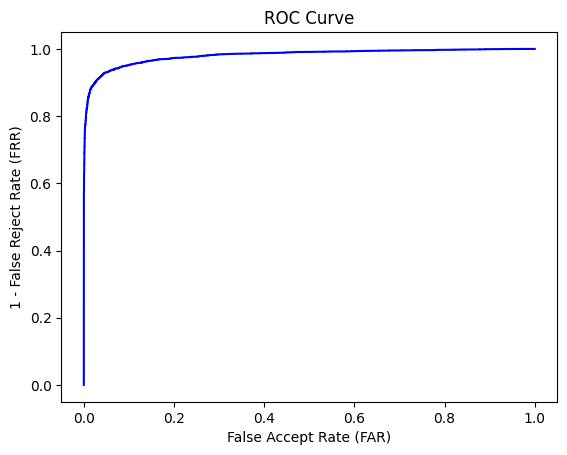

In [80]:
from sklearn.metrics import det_curve
import matplotlib.pyplot as plt


# Extract FAR (False Accept Rate) and FRR (False Reject Rate) from the results
fars = [result[score]['FAR'] for score in result]
frrs = [1-result[score]['FRR'] for score in result]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.title('ROC Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('1 - False Reject Rate (FRR)')
plt.show()

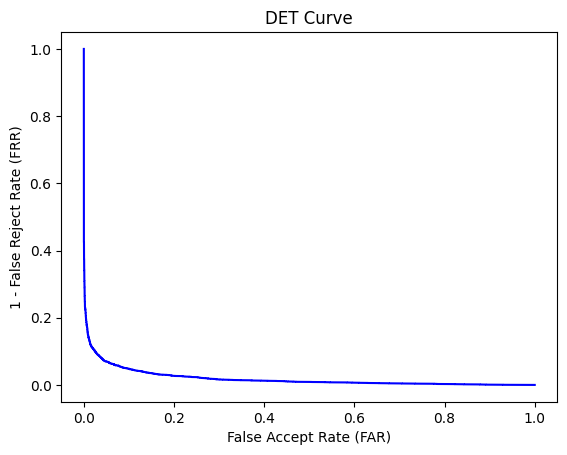

In [89]:
from sklearn.metrics import det_curve
import matplotlib.pyplot as plt

# Extract FAR (False Accept Rate) and FRR (False Reject Rate) from the results
fars = [result[score]['FAR'] for score in result]
frrs = [result[score]['FRR'] for score in result]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.show()

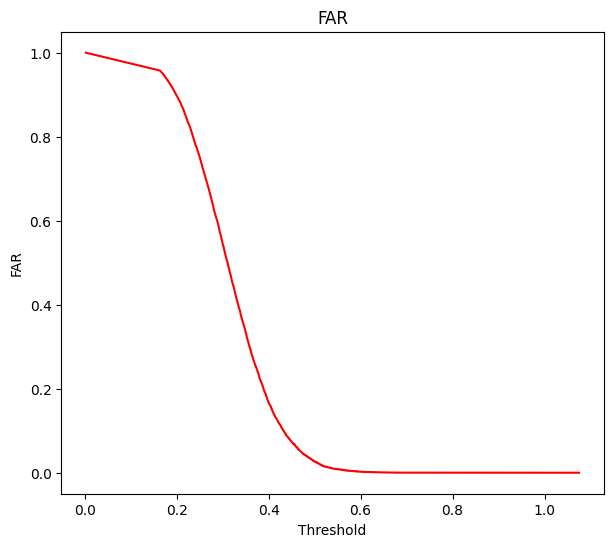

In [86]:
#thresholds = list(result.keys())
thresholds = [key for key in result.keys()]

far = [result[thresh]['FAR'] for thresh in thresholds]

plt.figure(figsize=(7, 6)) 
plt.plot(thresholds, far, linestyle='-', color='r')
plt.title('FAR')
plt.xlabel('Threshold')
plt.ylabel('FAR')
plt.show()

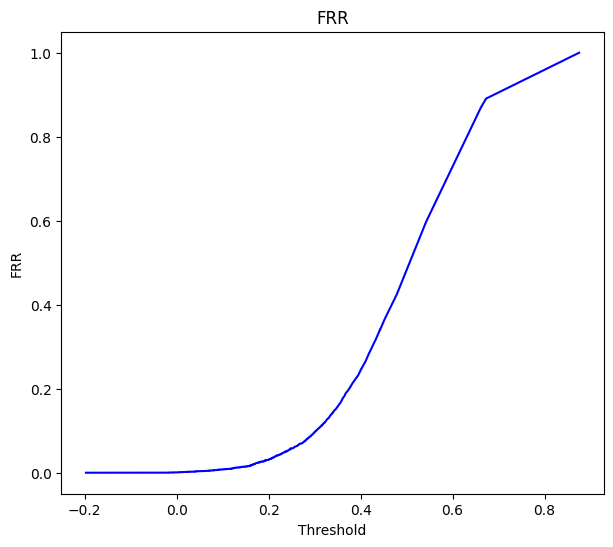

In [78]:
frr = [result[thresh]['FRR'] for thresh in thresholds]

plt.figure(figsize=(7, 6))
plt.plot(thresholds, frr, linestyle='-', color='b')
plt.title('FRR')
plt.xlabel('Threshold')
plt.ylabel('FRR')
plt.show()

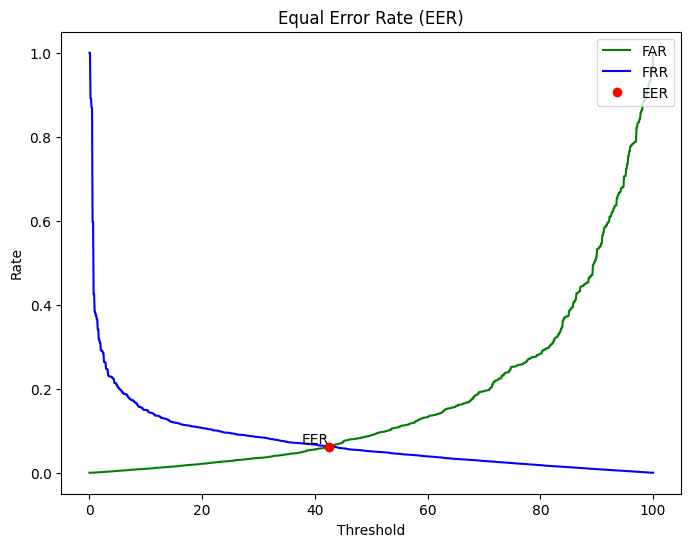

In [41]:
eer_index = np.argmin(np.abs(np.array(far) - np.array(frr)))
eer_FAR = far[eer_index]
eer_threshold = thresholds[eer_index]

# Plot FAR and FRR against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, far, linestyle='-', color='g', label='FAR')
plt.plot(thresholds, frr, linestyle='-', color='b', label='FRR')
plt.plot(eer_threshold, eer_FAR, 'ro', label='EER')
plt.text(eer_threshold, eer_FAR, 'EER', color='black', ha='right', va='bottom')

# Setting up the plot
plt.title('Equal Error Rate (EER)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='upper right')
plt.show()


DET plot problem 

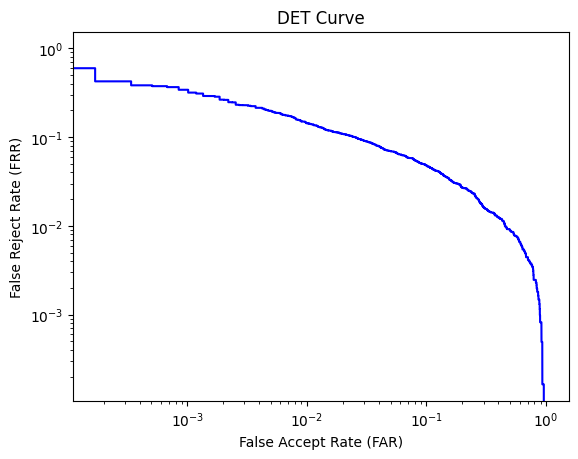

In [117]:
# Extract FAR and FRR values for plotting
thresholds = list(result.keys())
fars = [result[thresh]['FAR'] for thresh in thresholds if thresh != 'inf']
frrs = [result[thresh]['FRR'] for thresh in thresholds if thresh != 'inf']

# Since 'inf' can't be plotted, we remove it from the list of thresholds
# Also, we ensure thresholds are sorted because the plotting assumes this order
sorted_indices = np.argsort(thresholds)
fars = np.array(fars)[sorted_indices]
frrs = np.array(frrs)[sorted_indices]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.xscale('log')
plt.yscale('log')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.show()

In [100]:
def evaluate_model_with_metrics(model, df_pairs):
    scores = []
    true_labels = []

    for index, row in df_pairs.iterrows():
        image_path1 = row['Image1']
        image_path2 = row['Image2']

        if not os.path.exists(image_path1) or not os.path.exists(image_path2):
            print(f"Skipping comparison due to missing image at row {index}")
            continue

        embedding1 = get_embedding(model, image_path1)
        embedding2 = get_embedding(model, image_path2)

        similarity = cosine_similarity(embedding1, embedding2)
        print(f"Row {index}, Similarity: {similarity}")  # Debugging print

        if not np.isnan(similarity):
            scores.append(similarity)
            true_labels.append(row['IsSame'])

    if not scores:
        print("No valid scores to process.")
        return
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)

    # Trim thresholds to ensure they are non-negative
    valid_indices = np.where(thresholds >= 0)[0]
    fpr = fpr[valid_indices]
    tpr = tpr[valid_indices]
    thresholds = thresholds[valid_indices]

    metrics_by_threshold = {}

    for i, threshold in enumerate(thresholds):
        ga = tpr[i]
        gr = 1 - fpr[i]
        far = fpr[i]
        frr = 1 - tpr[i]

        metrics_by_threshold[threshold] = {
            'FAR': far,
            'FRR': frr,
            'GA (Genuine Acceptance Rate)': ga,
            'GR (Genuine Rejection Rate)': gr,
            'ROC AUC': roc_auc
        }
    return metrics_by_threshold

In [101]:
result2 = evaluate_model_with_metrics(load_model, test2_df)

1/1 [==============================] - 0s 32ms/step
Row 28331, Similarity: 0.08401147276163101
1/1 [==============================] - 0s 31ms/step
Row 12709, Similarity: 0.23336441814899445
1/1 [==============================] - 0s 34ms/step
Row 16477, Similarity: 0.1957797110080719
1/1 [==============================] - 0s 30ms/step
Row 11839, Similarity: 0.031464409083127975
1/1 [==============================] - 0s 31ms/step
Row 23140, Similarity: 0.6444793343544006
1/1 [==============================] - 0s 31ms/step
Row 11783, Similarity: -0.037015046924352646
1/1 [==============================] - 0s 33ms/step
Row 24218, Similarity: 0.17389442026615143
1/1 [==============================] - 0s 32ms/step
Row 4844, Similarity: 0.10175292938947678
1/1 [==============================] - 0s 30ms/step
Row 3243, Similarity: 0.05720915272831917
1/1 [==============================] - 0s 31ms/step
Row 12724, Similarity: 0.36296021938323975
1/1 [==============================] - 0s 31ms/step

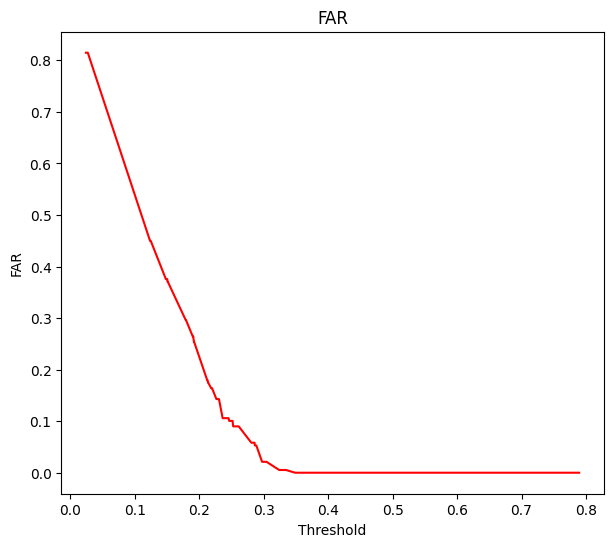

In [111]:
thresholds = list(result2.keys())

far = [result2[thresh]['FAR'] for thresh in thresholds]

plt.figure(figsize=(7, 6)) 
plt.plot(thresholds, far, linestyle='-', color='r')
plt.title('FAR')

plt.xlabel('Threshold')
plt.ylabel('FAR')
plt.show()

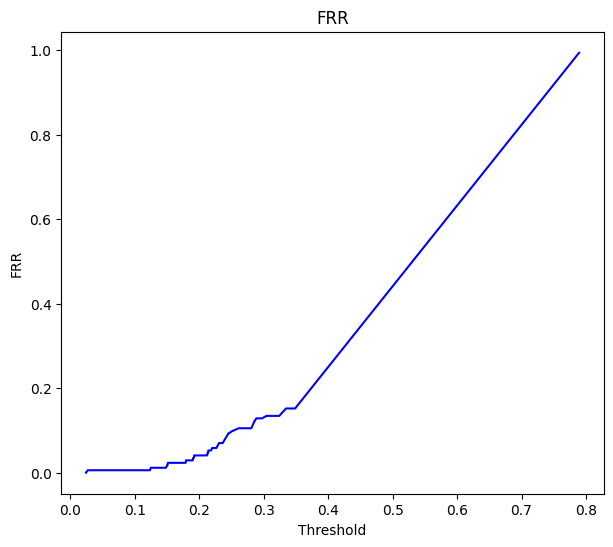

In [104]:
frr = [result2[thresh]['FRR'] for thresh in thresholds]

plt.figure(figsize=(7, 6))
plt.plot(thresholds, frr, linestyle='-', color='b')
plt.title('FRR')
plt.xlabel('Threshold')
plt.ylabel('FRR')
plt.show()

Text(0, 0.5, '1 - False Reject Rate (FRR)')

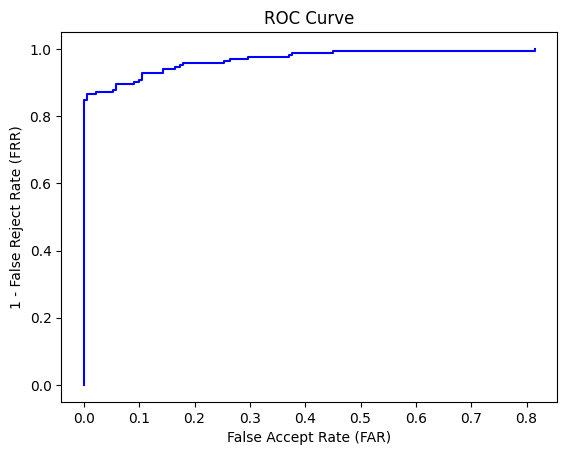

In [112]:
from sklearn.metrics import det_curve
import matplotlib.pyplot as plt

# Extract FAR (False Accept Rate) and FRR (False Reject Rate) from the results
fars = [result2[score]['FAR'] for score in result2]
frrs = [1-result2[score]['FRR'] for score in result2]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.title('ROC Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('1 - False Reject Rate (FRR)')

In [ ]:
from sklearn.metrics import det_curve

# Assuming 'scores' are the similarity scores and 'true_labels' are the actual matching labels
fmr, fnmr, thresholds = det_curve(true_labels, scores)

# Plotting the DET curve
plt.figure(figsize=(10, 10))
plt.plot(fmr, fnmr, color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('False Match Rate')
plt.ylabel('False Non-Match Rate')
plt.title('DET Curve')
plt.grid(True)
plt.show()


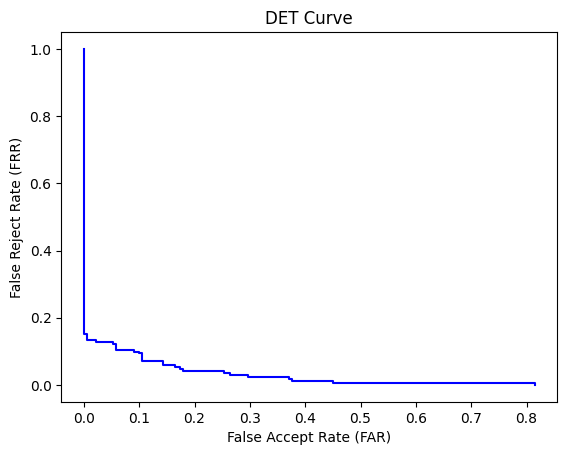

In [108]:
from sklearn.metrics import det_curve
import matplotlib.pyplot as plt

# Extract FAR (False Accept Rate) and FRR (False Reject Rate) from the results
fars = [result2[score]['FAR'] for score in result2]
frrs = [result2[score]['FRR'] for score in result2]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.show()

In [113]:
print(result2)

{inf: {'FAR': 0.0, 'FRR': 1.0, 'GA (Genuine Acceptance Rate)': 0.0, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9736377981992017}, 0.78934354: {'FAR': 0.0, 'FRR': 0.9941520467836258, 'GA (Genuine Acceptance Rate)': 0.005847953216374269, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9736377981992017}, 0.348675: {'FAR': 0.0, 'FRR': 0.15204678362573099, 'GA (Genuine Acceptance Rate)': 0.847953216374269, 'GR (Genuine Rejection Rate)': 1.0, 'ROC AUC': 0.9736377981992017}, 0.3345781: {'FAR': 0.005291005291005291, 'FRR': 0.15204678362573099, 'GA (Genuine Acceptance Rate)': 0.847953216374269, 'GR (Genuine Rejection Rate)': 0.9947089947089947, 'ROC AUC': 0.9736377981992017}, 0.32407174: {'FAR': 0.005291005291005291, 'FRR': 0.13450292397660824, 'GA (Genuine Acceptance Rate)': 0.8654970760233918, 'GR (Genuine Rejection Rate)': 0.9947089947089947, 'ROC AUC': 0.9736377981992017}, 0.3043997: {'FAR': 0.021164021164021163, 'FRR': 0.13450292397660824, 'GA (Genuine Acceptance Rate)': 0.865497076

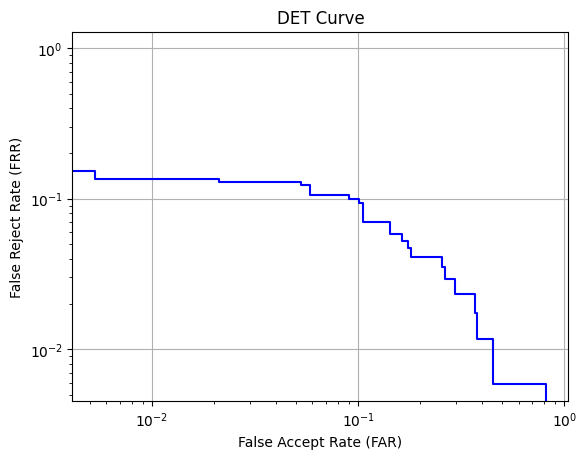

In [116]:
# Extract FAR and FRR values for plotting
thresholds = list(result2.keys())
fars = [result2[thresh]['FAR'] for thresh in thresholds if thresh != 'inf']
frrs = [result2[thresh]['FRR'] for thresh in thresholds if thresh != 'inf']

# Since 'inf' can't be plotted, we remove it from the list of thresholds
# Also, we ensure thresholds are sorted because the plotting assumes this order
sorted_indices = np.argsort(thresholds)
fars = np.array(fars)[sorted_indices]
frrs = np.array(frrs)[sorted_indices]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.xscale('log')
plt.yscale('log')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.grid(True)
plt.show()
